In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bcnf.simulation.physics import physics_ODE_simulation, calculate_point_of_impact
from bcnf.camera import record_trajectory

In [2]:
def get_cam2_position(l):
    cam2_x = 25 * np.cos(l)
    cam2_y = 25 * np.sin(l)
    cam2_z = 1.5

    return np.array([cam2_x, cam2_y, cam2_z])

# create function to sample uniformy for the ballisitc parameters

def sample_ballistic_parameters():
    # pos
    x0_x = np.random.uniform(-40, 40)   # person can stand outside the circle, but not too far away
    x0_y = np.random.uniform(-40, 40)
    x0_z = np.random.uniform(1, 2)      # height of the average persones head is somewhere here

    x0 = np.array([x0_x, x0_y, x0_z])

    # velo
    v0_x = np.random.uniform(-25, 25)   # 25 m/s (90 km/h) is very well possible for a handball throw
    v0_y = np.random.uniform(-25, 25)
    v0_z = np.random.uniform(-25, 25)

    v0 = np.array([v0_x, v0_y, v0_z])

    # grav
    g_z = np.random.uniform(-0.08 * 9.81, -2.5 * 9.8) # from ~0.779 up to ~24.79 (Triton to Jupiter)

    g = np.array([0, 0, g_z])

    # wind
    w_x = np.random.uniform(-20, 20)    # includes up to the definition of "stürmischer Wind" (https://de.wikipedia.org/wiki/Windgeschwindigkeit)
    w_y = np.random.uniform(-20, 20)
    w_z = np.random.uniform(-20, 20)

    w = np.array([w_x, w_y, w_z])

    # b
    # density of atmosphere
    rho = np.random.uniform(0, 1.5)     # excluding venus with insane 67 kg/m^3...
    
    # area of thown object
    A = np.random.uniform(0.003, 0.15)  # from a small ball (3 cm radius) to a big ball (20 cm radius)

    # drag coefficient
    Cd = np.random.uniform(0.04, 1.42)  # reference for 3D objects (https://en.wikipedia.org/wiki/Drag_coefficient)

    b = rho * A * Cd    # drag coefficient (do we need a factor of 0.5 here?)

    # mass
    m = np.random.uniform(0.056, 0.62)  # from a tennis ball (56 g) to a basketball (620 g)

    # thrust
    a_x = np.random.uniform(-5, 5)      # thats just wild guessing
    a_y = np.random.uniform(-5, 5)
    a_z = np.random.uniform(-5, 5)

    a = np.array([a_x, a_y, a_z])

    # second cam position
    l = np.random.uniform(0, 2 * np.pi)

    # average radius of ball
    r = (A/np.pi)**0.5

    return x0, v0, g, w, b, m, a, l, r, A, Cd, rho

In [3]:
# sample uniformly while the pandas df has less than 1000 rows


df = pd.DataFrame(columns=[
    'x0_x', 'x0_y', 'x0_z',
    'v0_x', 'v0_y', 'v0_z',
    'g', 
    'w_x', 'w_y', 'w_z',
    'b', 'A', 'Cd', 'rho', 'm', 
    'a_x', 'a_y', 'a_z',
    'l', 'r'])

SPF = 1 / 30
T = 3
cam1_pos = np.array([-25, 0, 1.5])

while df.shape[0] < 10000:
    x0, v0, g, w, b, m, a, l, r, A, Cd, rho = sample_ballistic_parameters()
    traj = physics_ODE_simulation(x0, v0, g, w, b, m, a, T, SPF)
    
    # check whether ball is thrown further than 5 m
    poi = calculate_point_of_impact(x0, v0, g, w, b, m, a, dt=0.01)[:2]
    if np.linalg.norm(poi - x0[:2]) > 5:
        # check if ball is throw less than 100 m
        if np.linalg.norm(poi - x0[:2]) < 100:
            cam2_pos = get_cam2_position(l)

            cam1 = record_trajectory(traj, (16,9), 70.0, cam1_pos, make_gif = False, radius=r)
            cam2 = record_trajectory(traj, (16,9), 70.0, cam2_pos, make_gif = False, radius=r)

            # check whether the ball is visible in at least 80 % of the combined frames
            if np.sum(cam1 + cam2) / (2 * len(cam1)) > 0.8:
                # add parameters to df
                df = pd.concat([
                    df,
                    pd.DataFrame({
                        'x0_x': x0[0],
                        'x0_y': x0[1],
                        'x0_z': x0[2],
                        'v0_x': v0[0],
                        'v0_y': v0[1],
                        'v0_z': v0[2],
                        'g': g[2],
                        'w_x': w[0],
                        'w_y': w[1],
                        'w_z': w[2],
                        'b': b,
                        'A': A,
                        'Cd': Cd,
                        'rho': rho,
                        'm': m,
                        'a_x': a[0],
                        'a_y': a[1],
                        'a_z': a[2],
                        'l': l,
                        'r': r
                    }, index=[0])
                ], ignore_index=True)

C:\Users\Chris\AppData\Local\Temp\ipykernel_14988\3931758384.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


In [4]:
print(df)

           x0_x       x0_y      x0_z       v0_x       v0_y       v0_z  \
0     -6.501012  18.030560  1.810655   8.312977 -18.779229  -3.515415   
1      1.454436  12.181184  1.348133  10.111520 -16.116786   4.182325   
2     -4.649527   9.787200  1.281590  -0.695617   2.416825  19.189776   
3     -6.493239  -9.560688  1.338859  19.879529  -7.829289  18.307708   
4      2.379746 -22.721110  1.975999  16.239820  -0.863199   9.623442   
...         ...        ...       ...        ...        ...        ...   
9995  17.029313   4.069780  1.601397 -17.592400 -12.643223  20.732217   
9996  23.023412  -2.814138  1.303588  10.497115 -18.886244  14.958313   
9997  38.623621  31.984440  1.645345  21.598378   5.453033  -5.719964   
9998  29.798473  -4.875867  1.908408 -10.634306  23.673502  20.631412   
9999  -4.544137   1.996042  1.652816 -18.661787  -6.791276  -2.003706   

              g        w_x        w_y        w_z         b         A  \
0    -20.700648   2.731661   2.476868  -8.911446  0

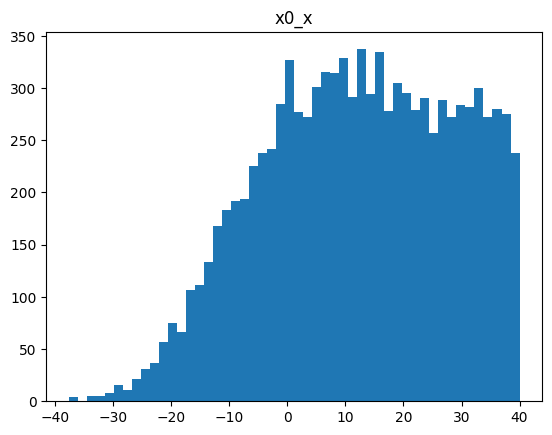

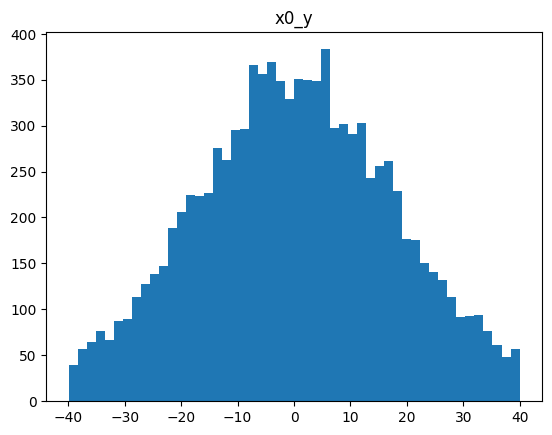

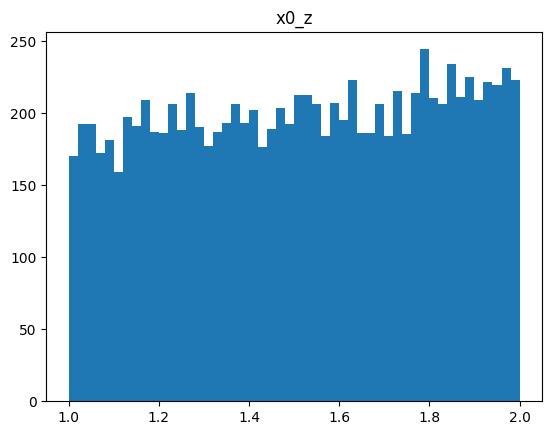

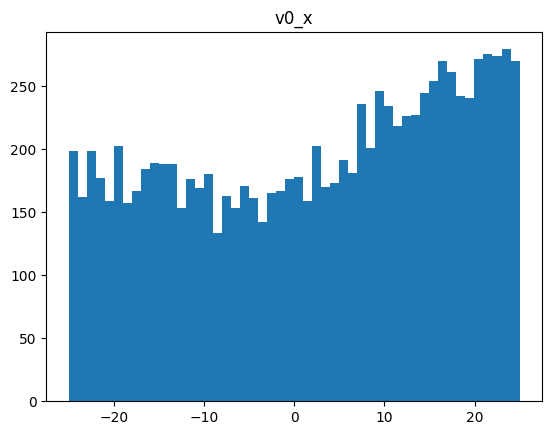

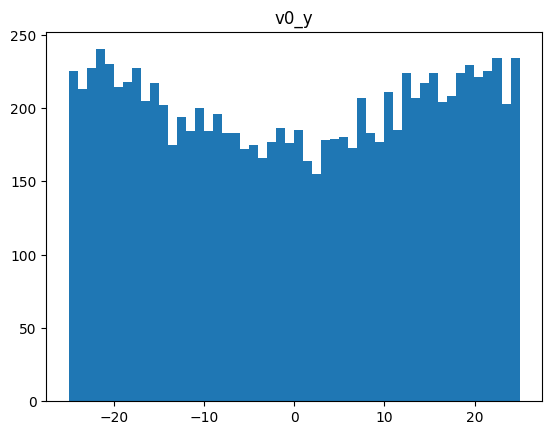

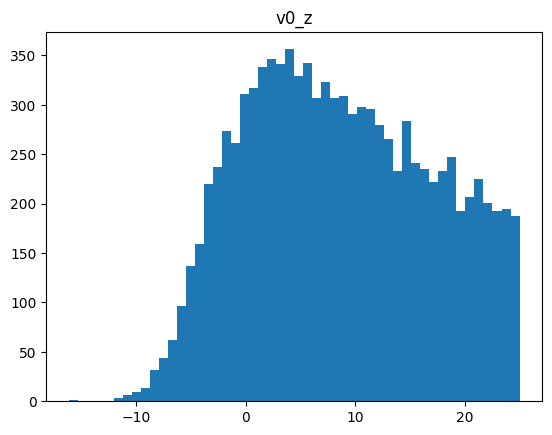

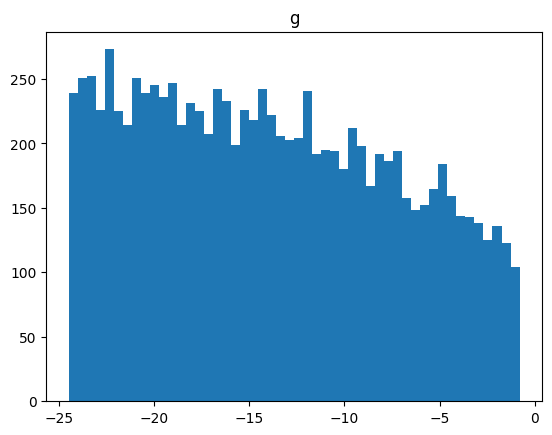

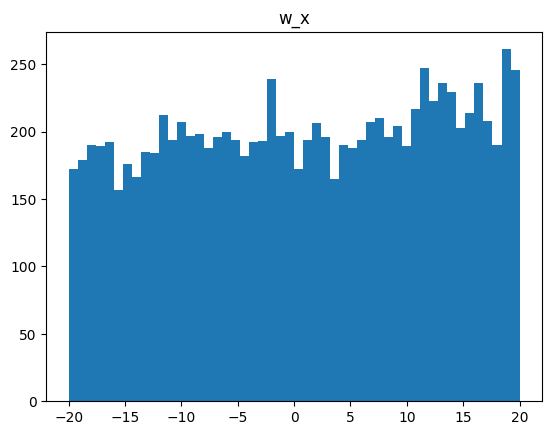

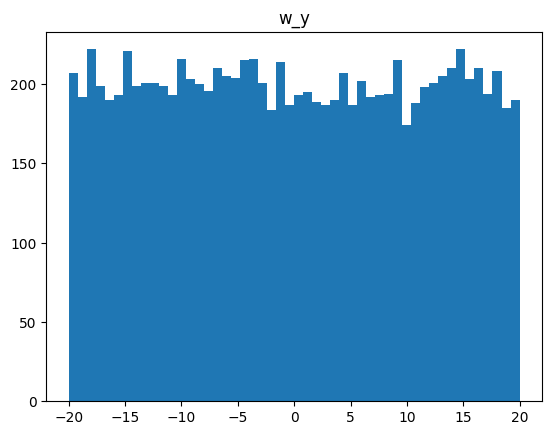

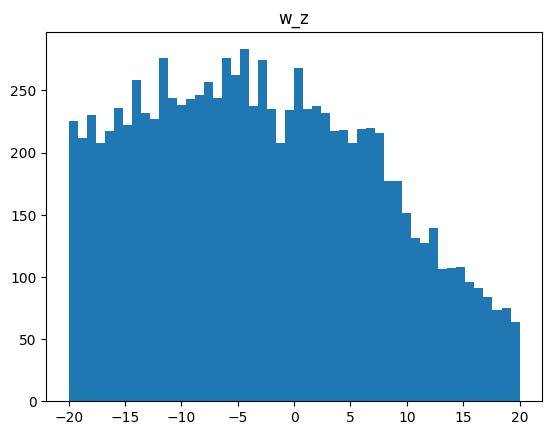

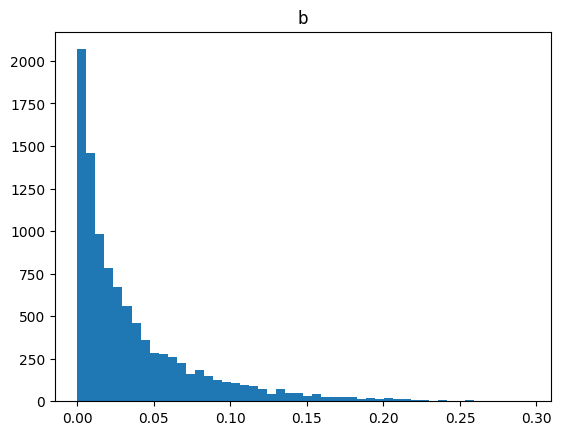

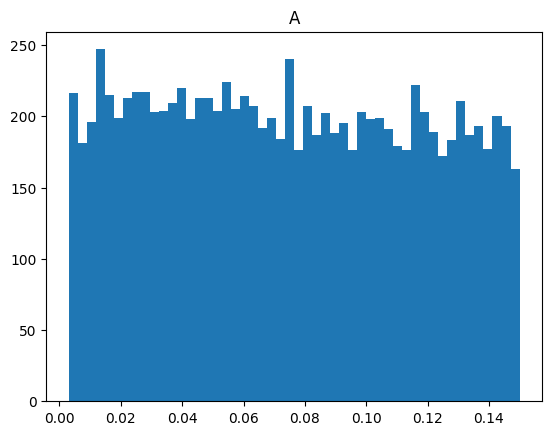

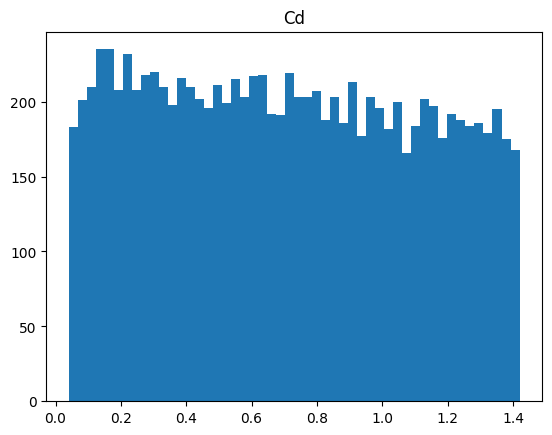

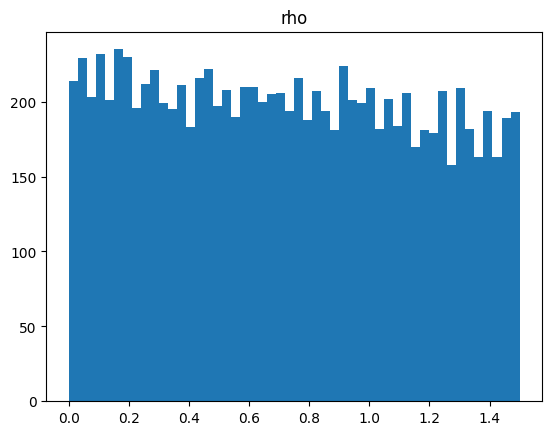

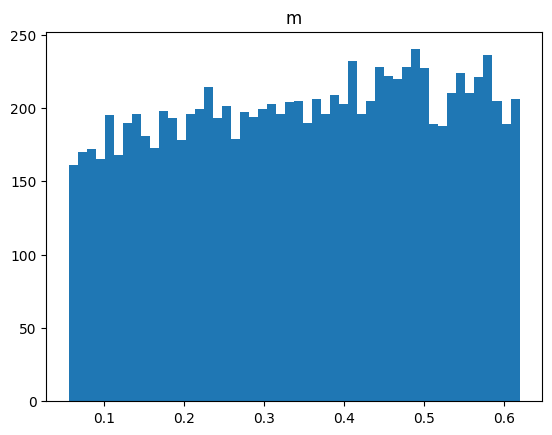

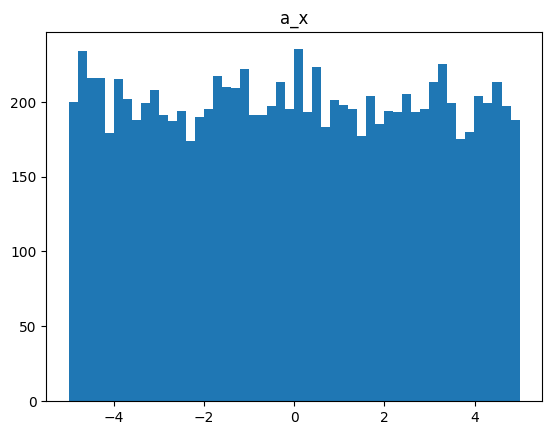

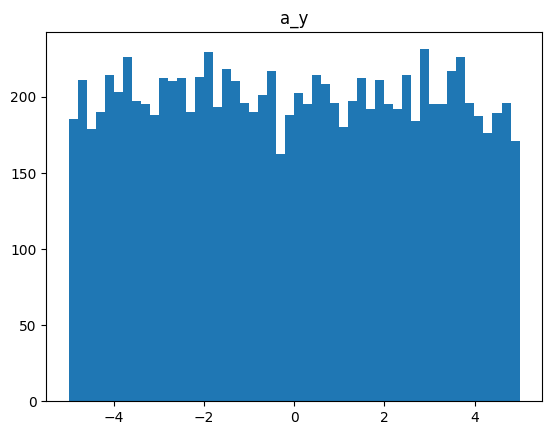

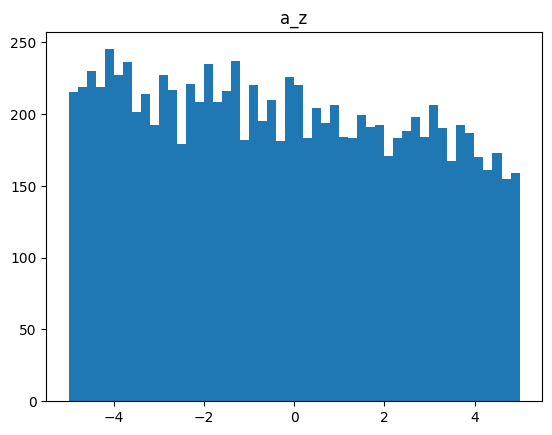

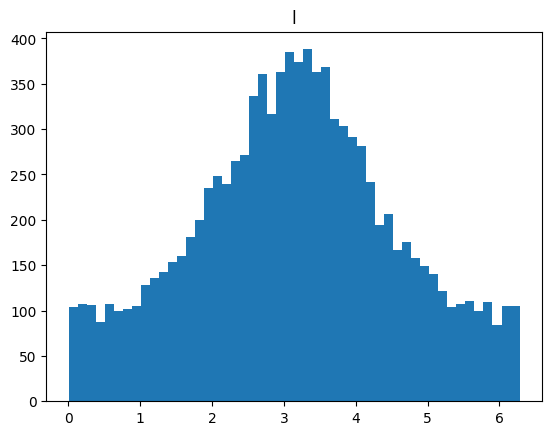

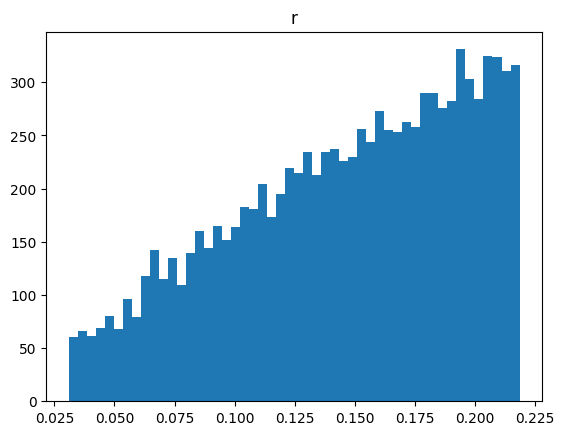

In [5]:
# plot each variable
for col in df.columns:
    plt.hist(df[col], bins=50)
    plt.title(col)
    plt.show()

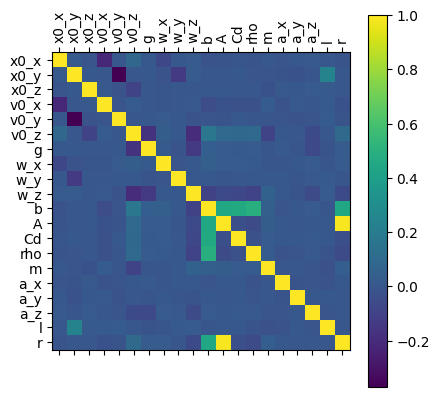

In [6]:
# plot correlation matrix
plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

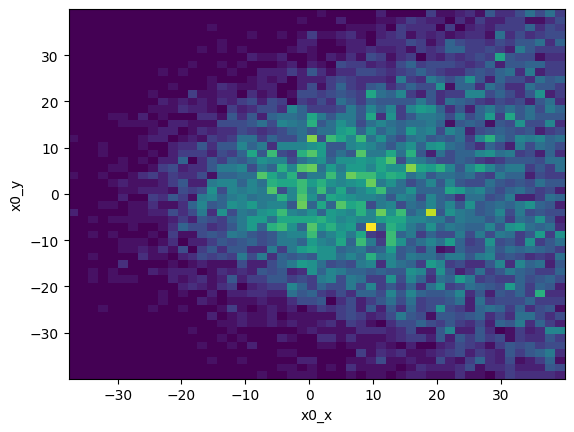

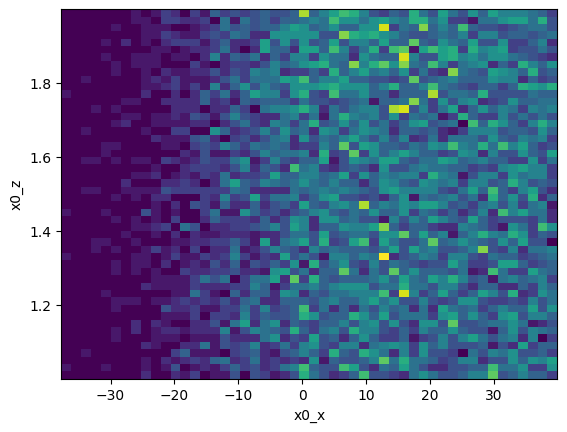

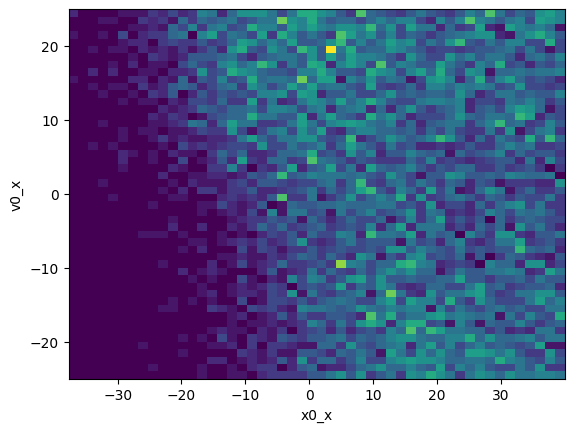

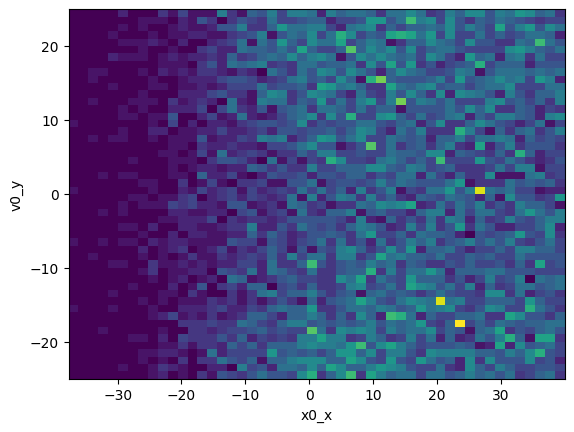

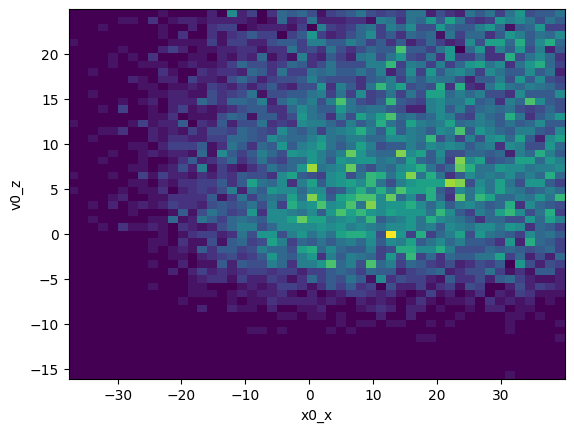

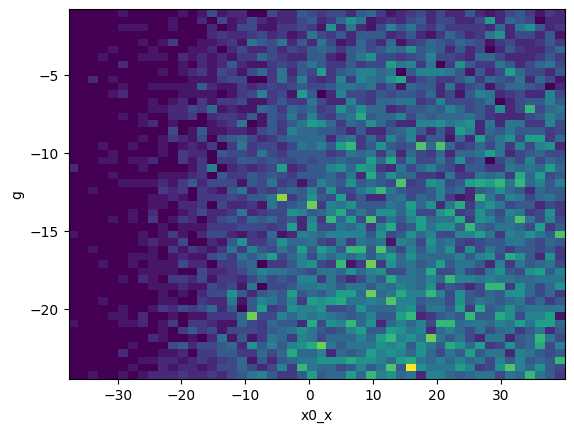

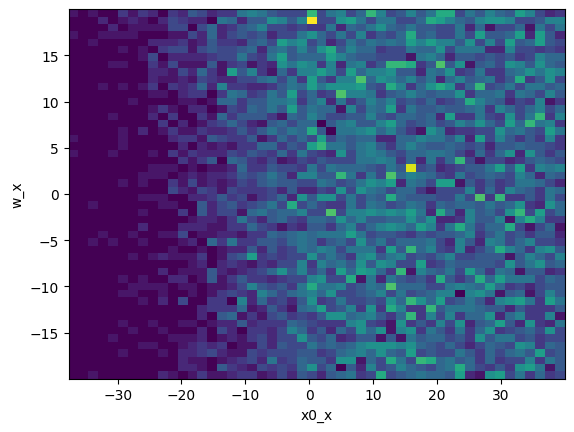

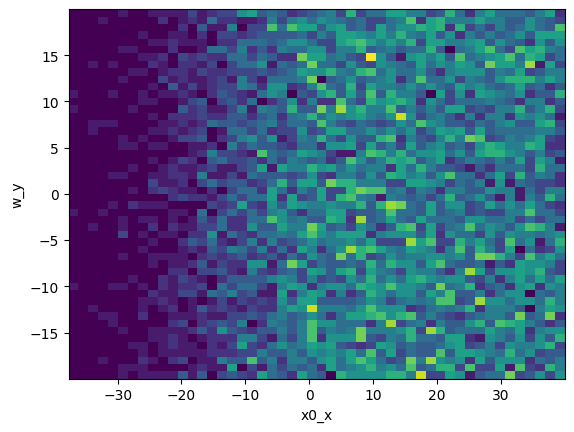

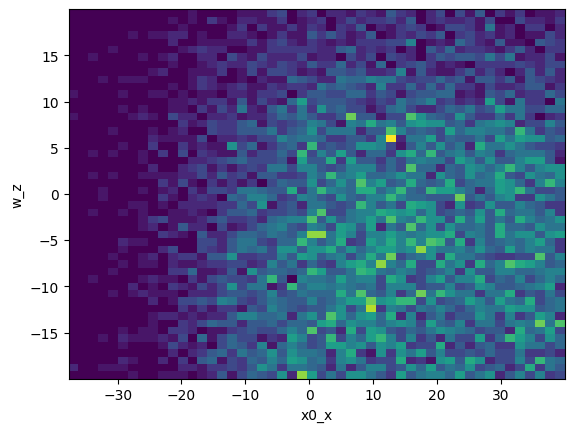

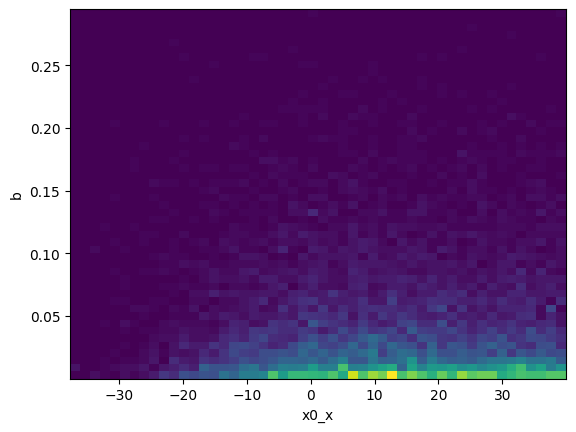

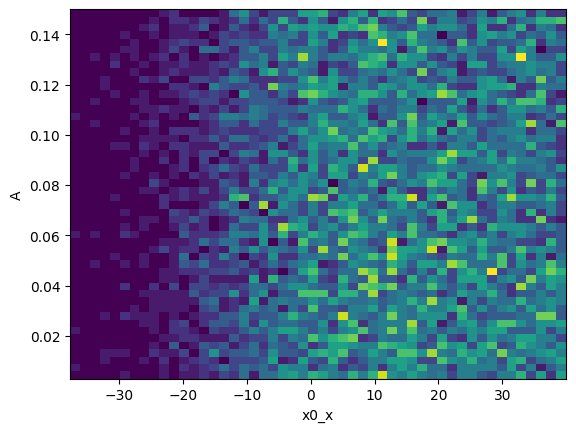

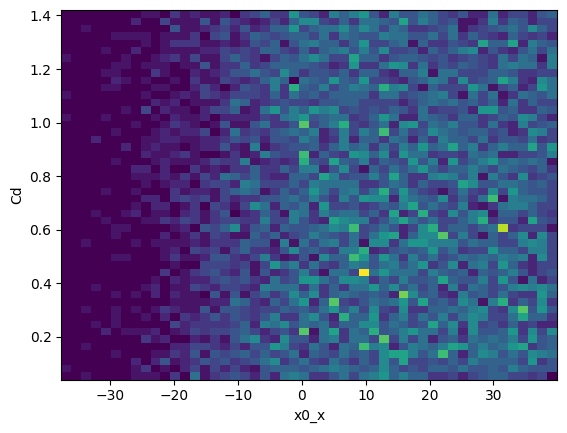

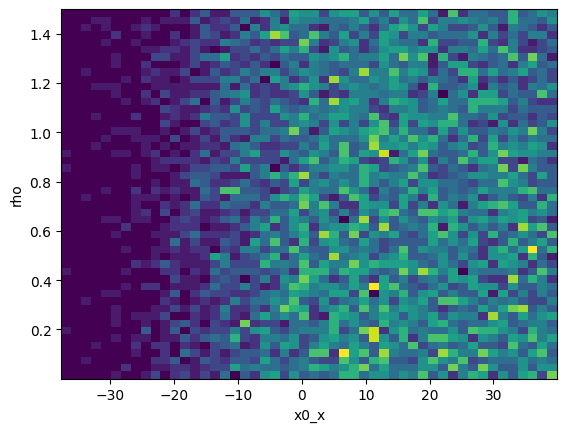

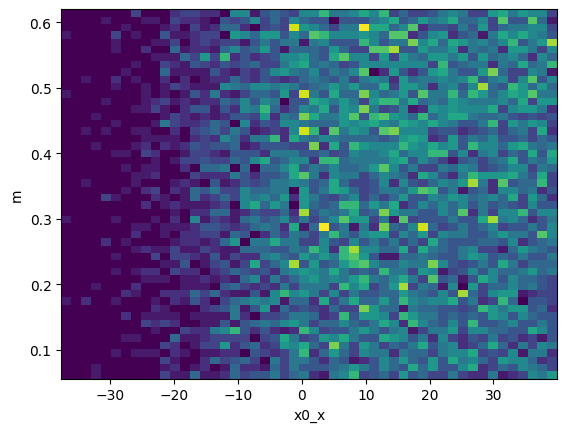

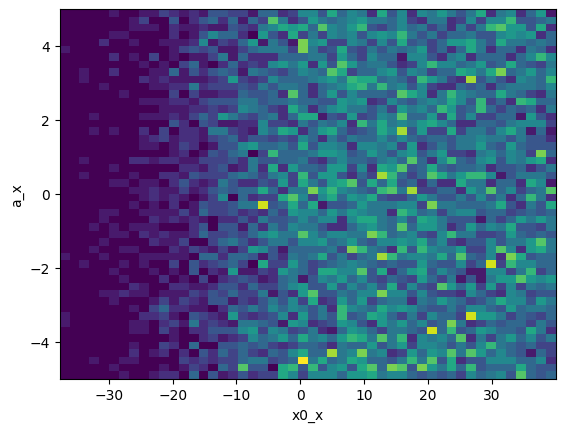

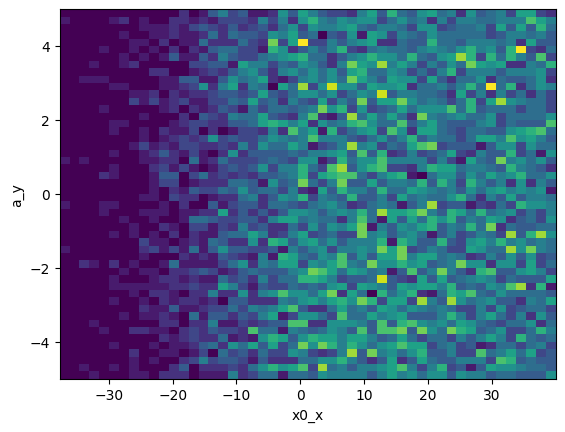

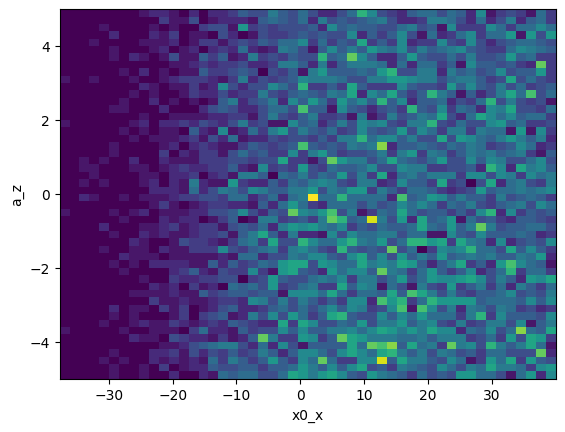

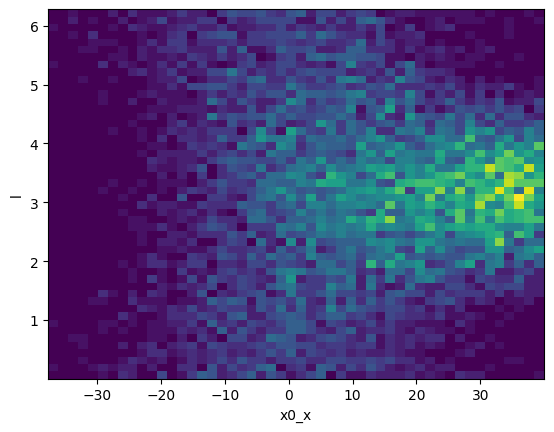

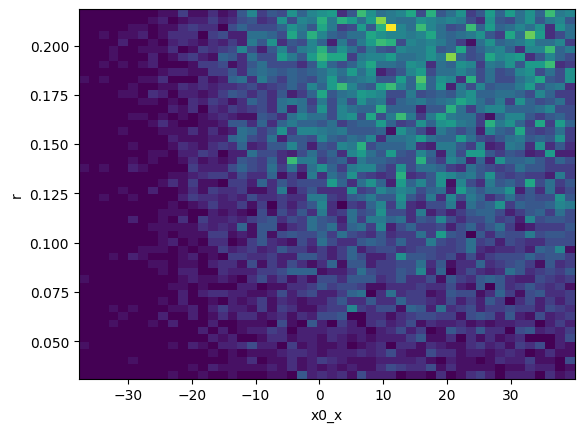

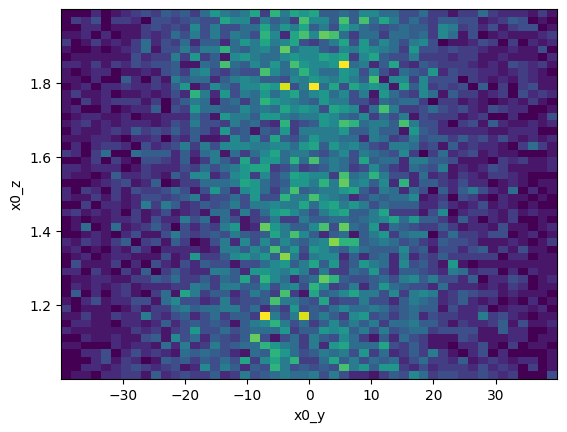

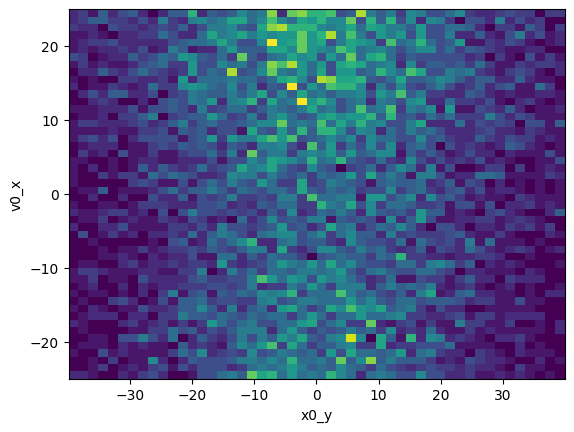

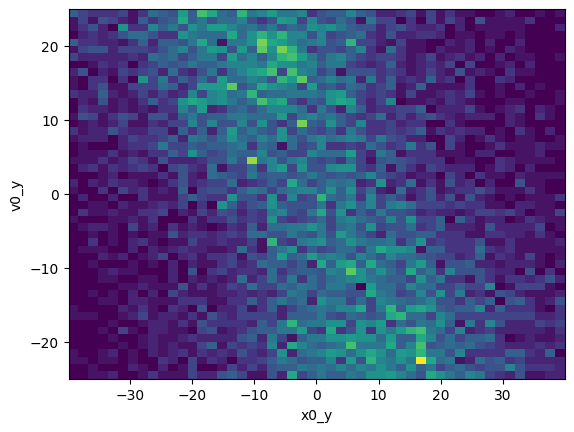

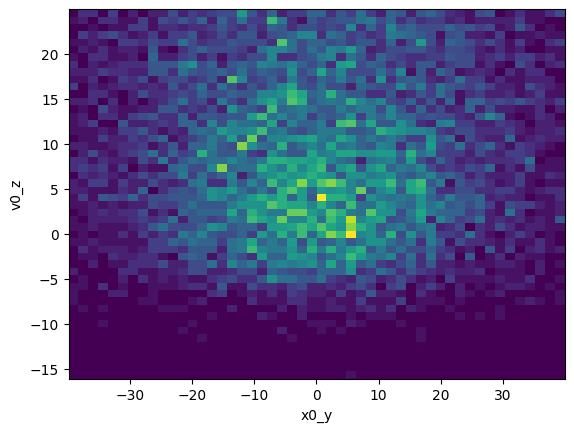

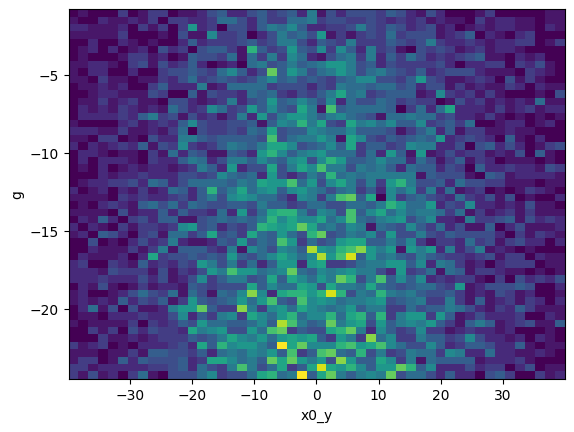

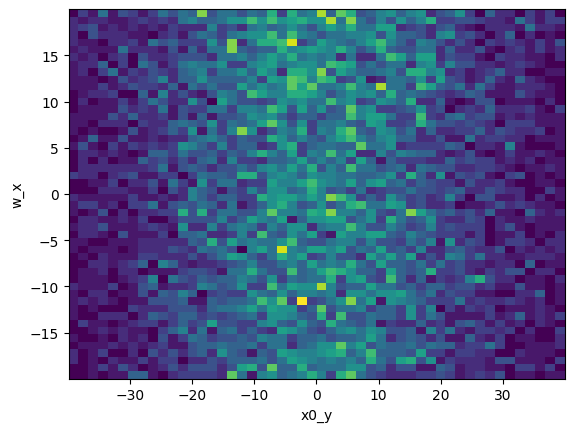

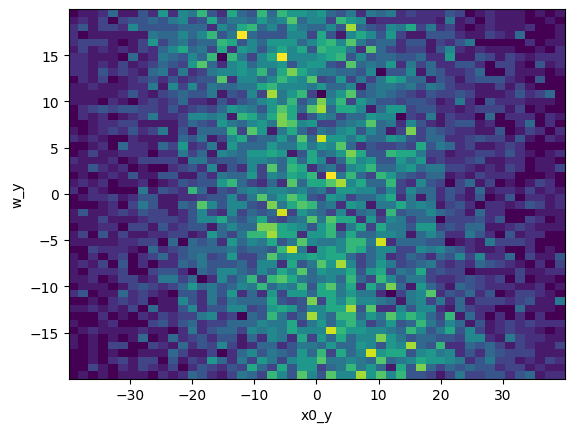

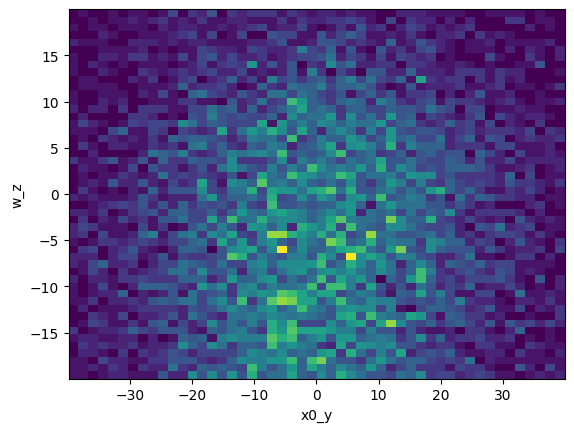

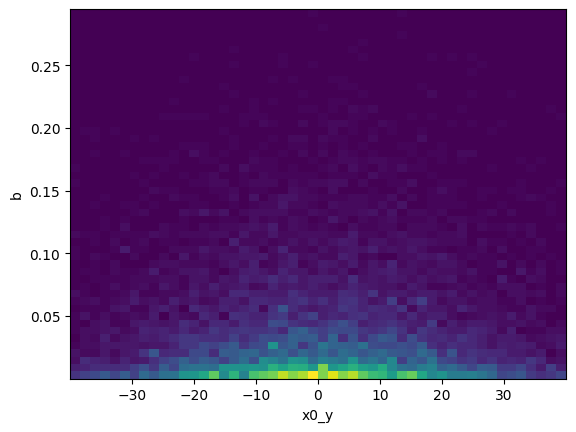

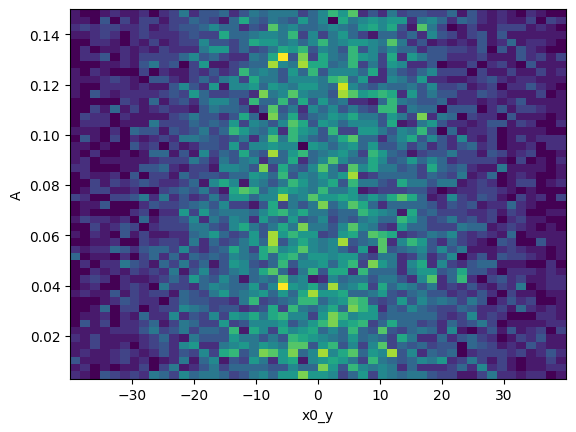

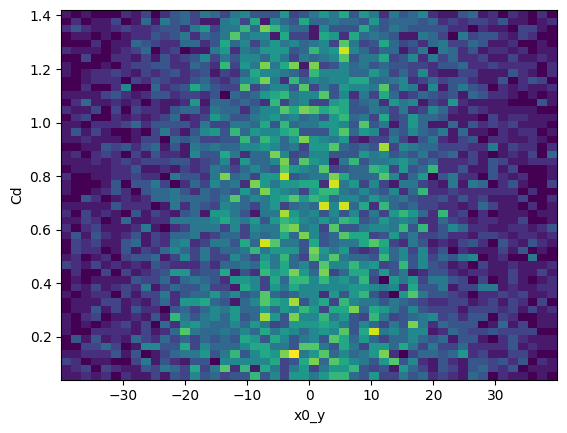

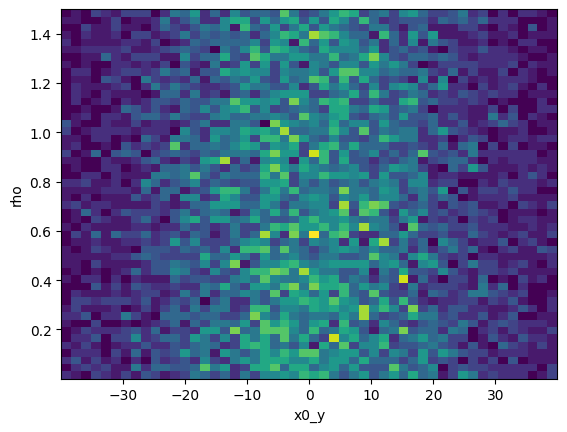

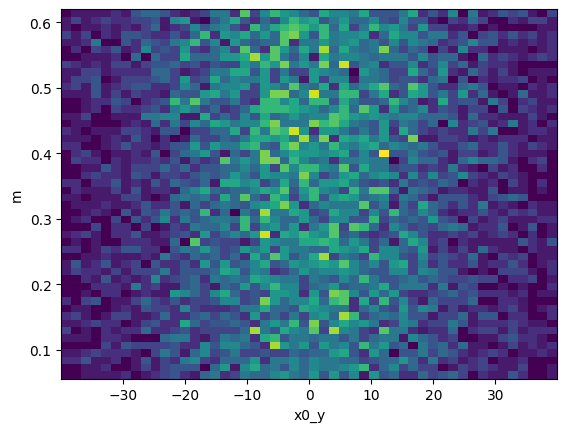

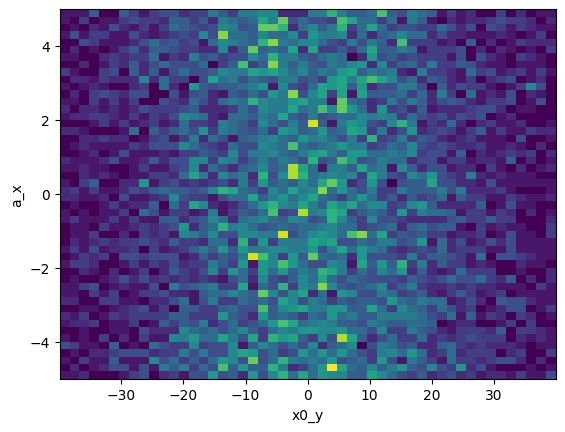

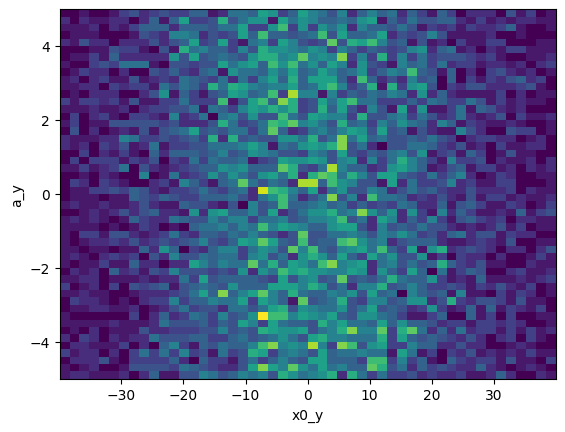

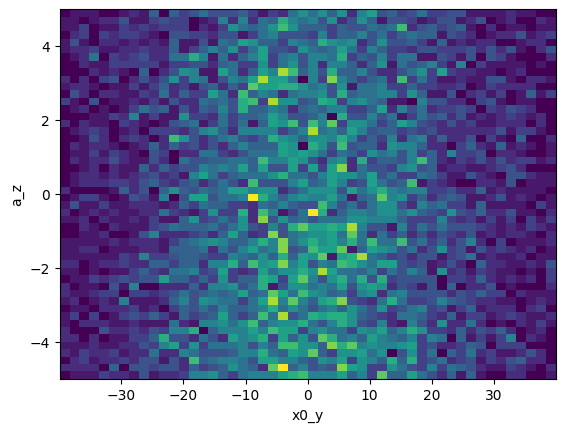

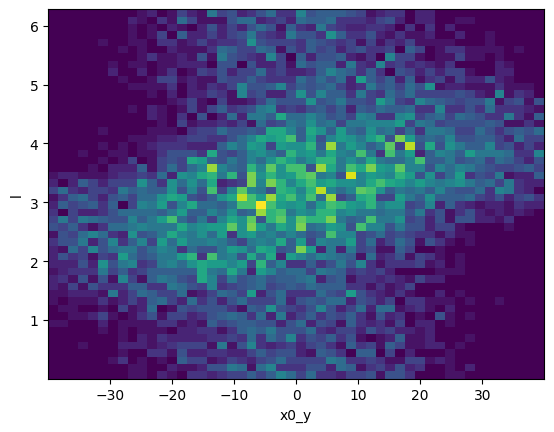

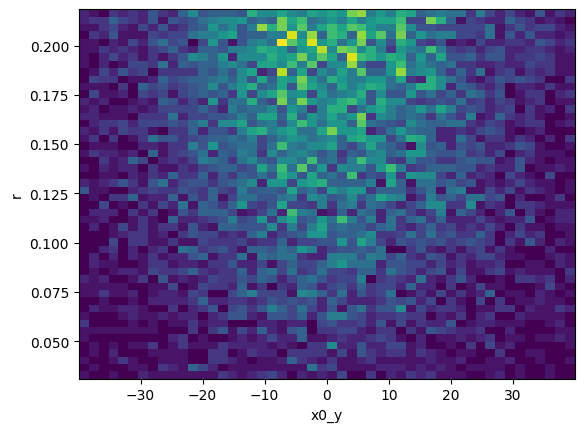

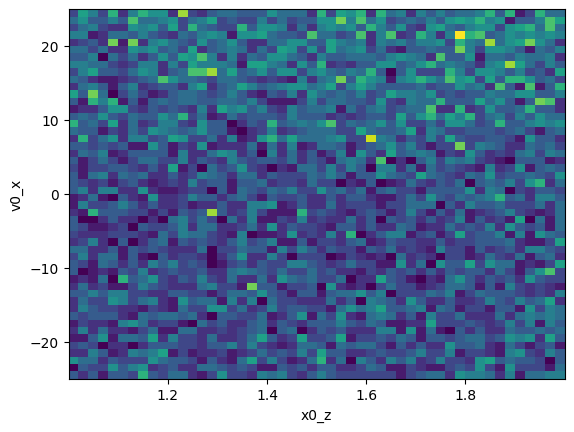

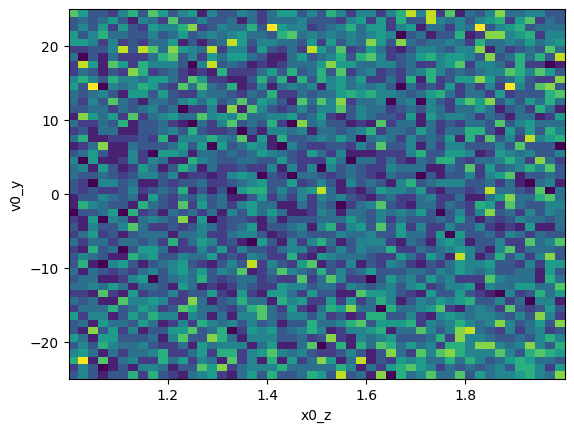

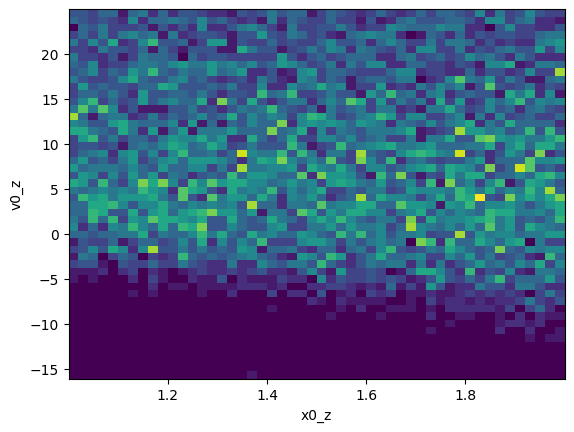

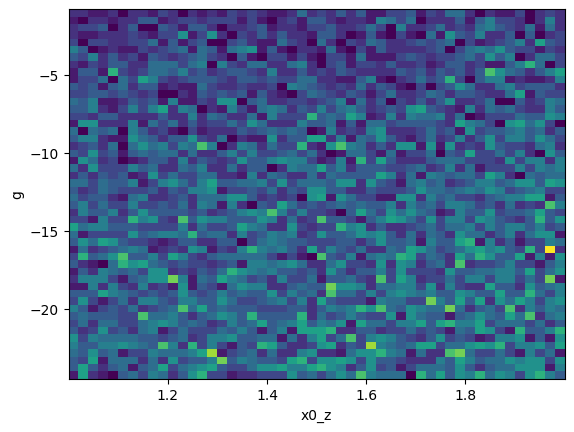

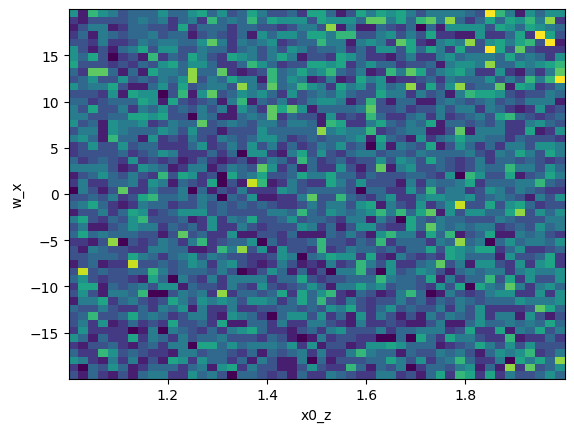

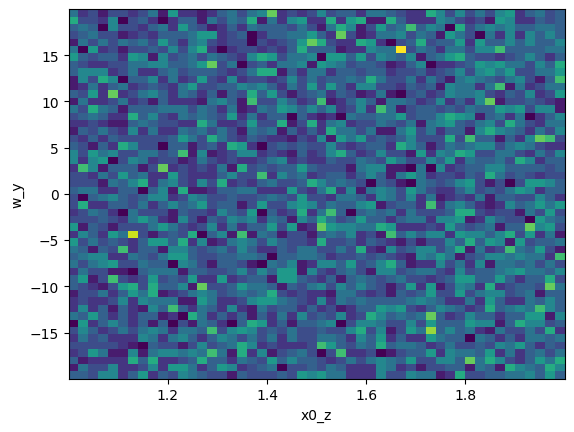

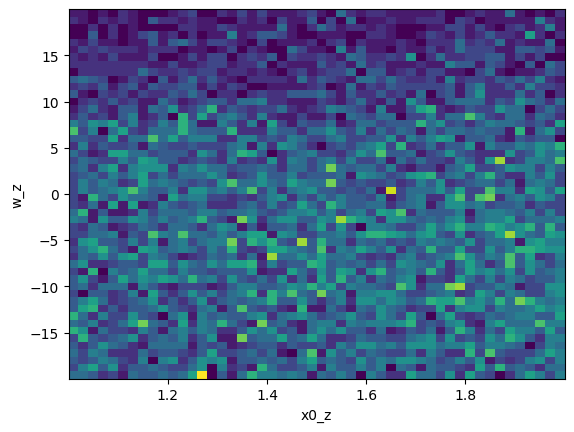

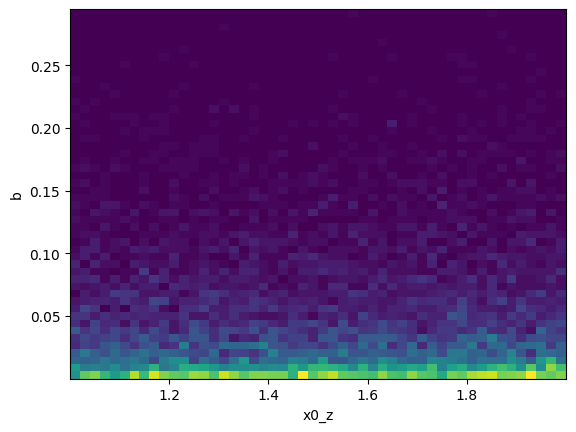

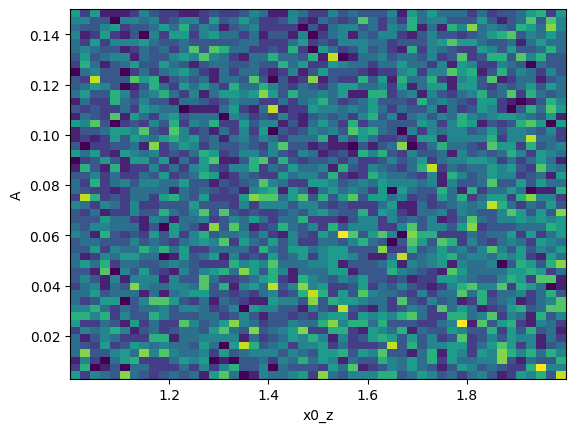

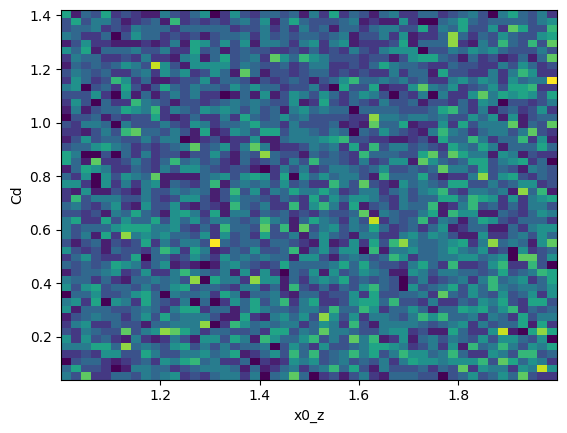

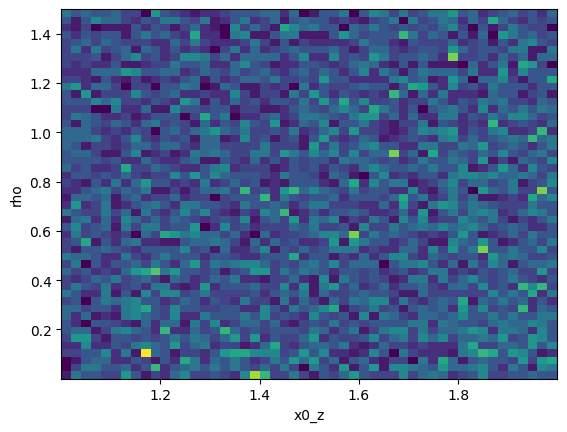

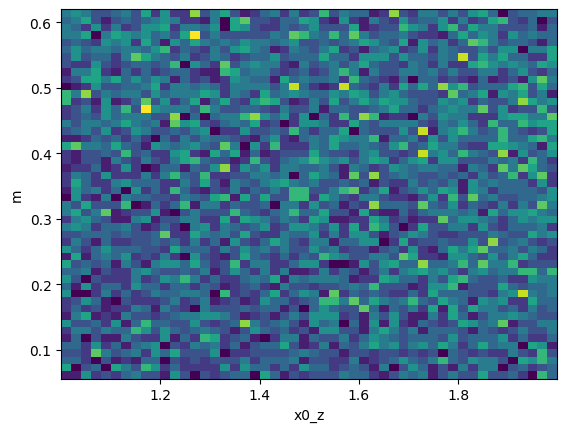

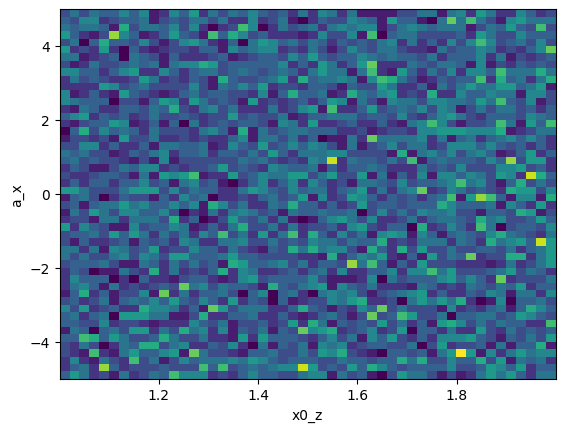

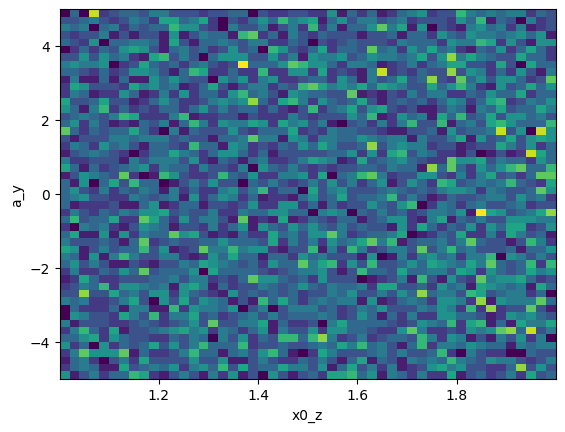

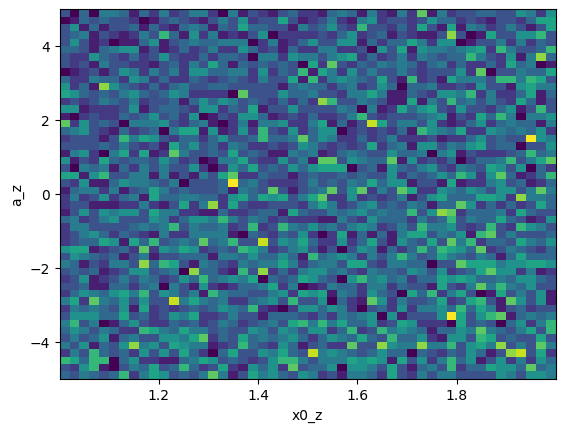

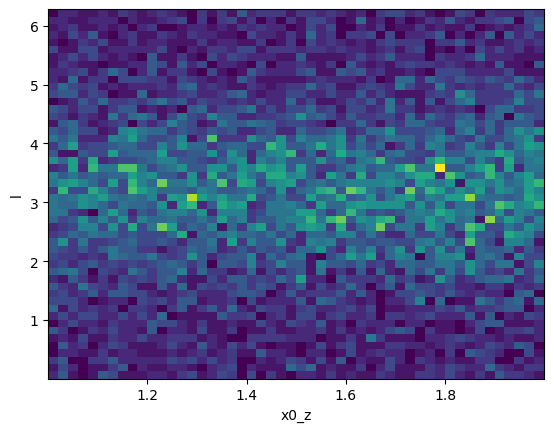

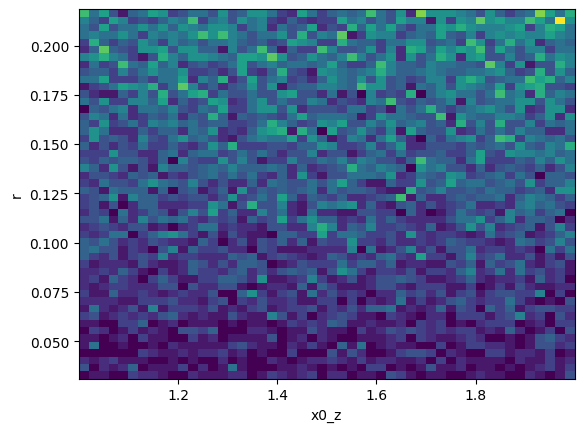

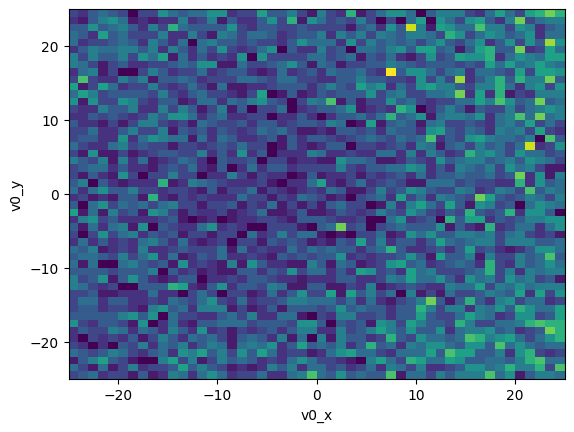

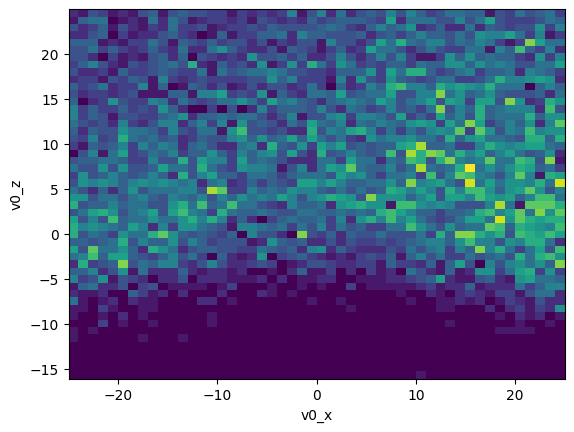

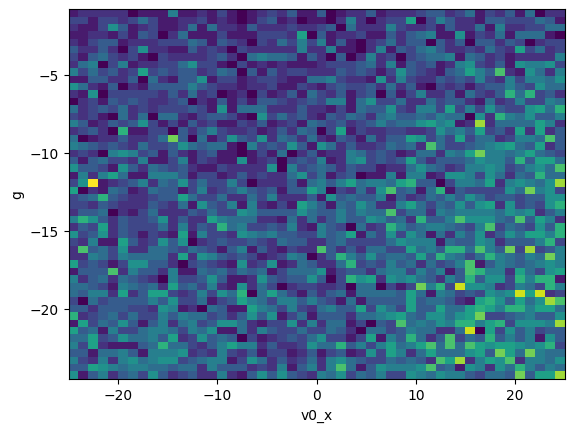

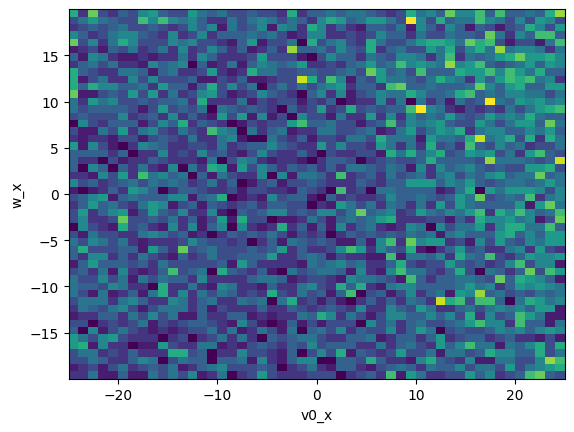

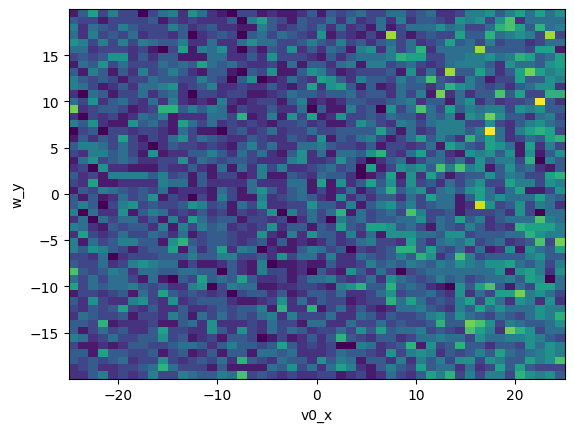

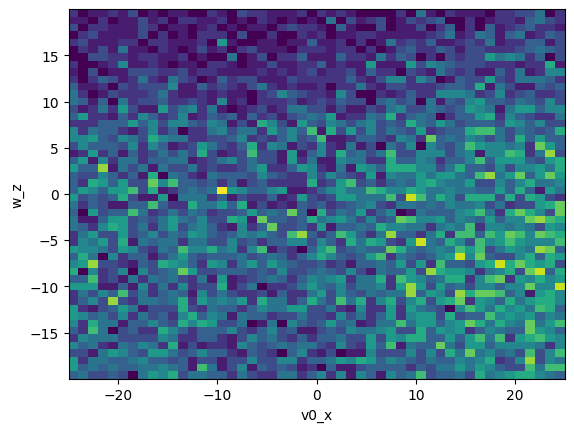

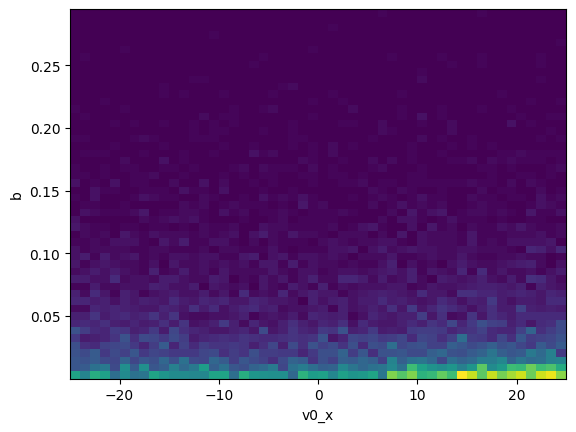

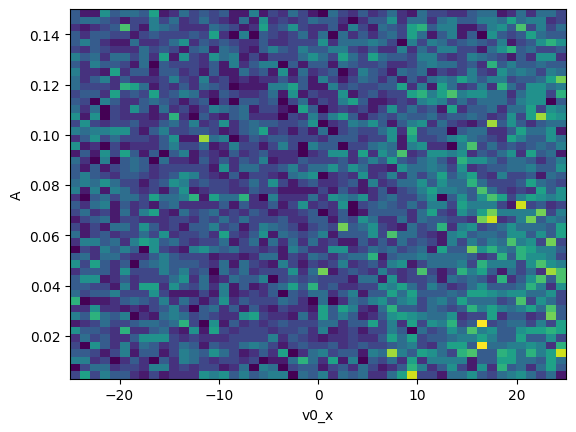

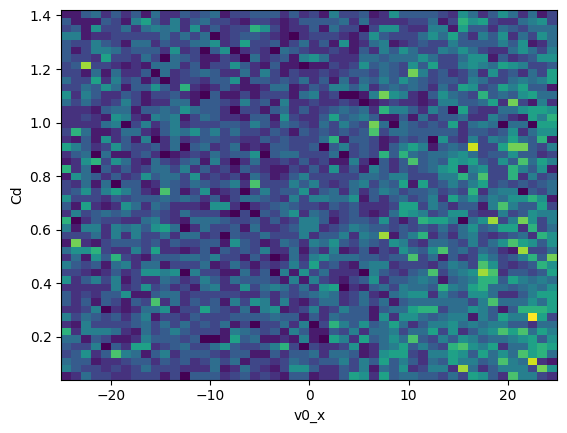

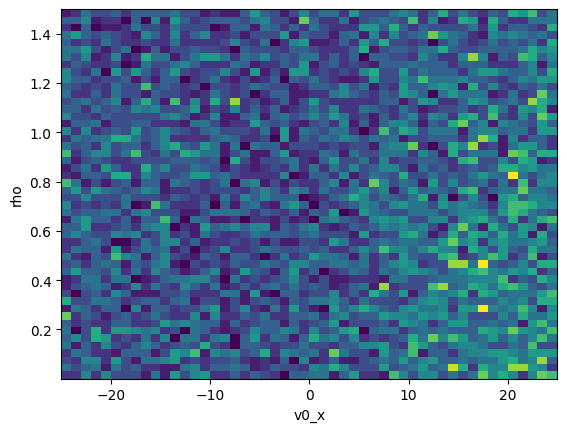

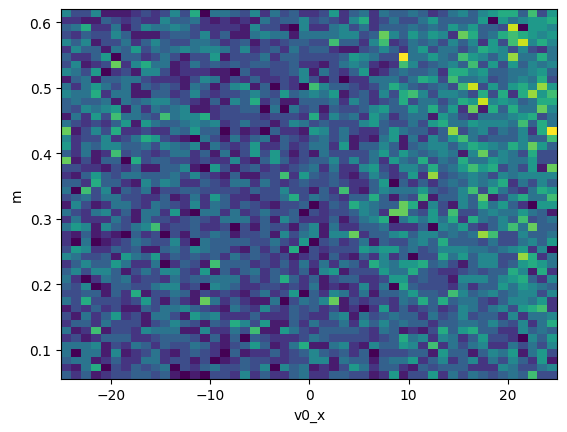

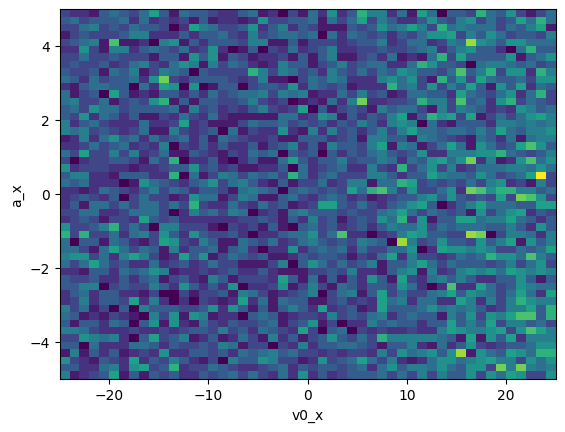

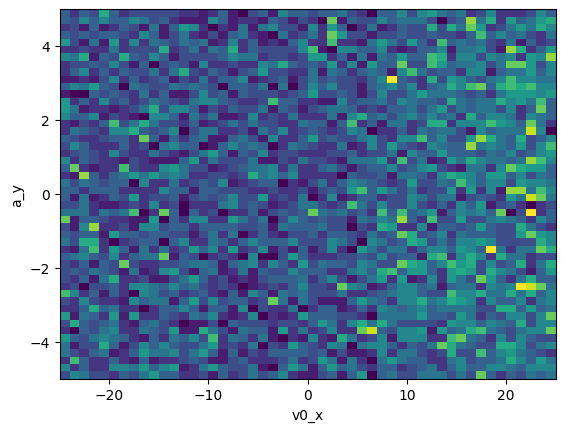

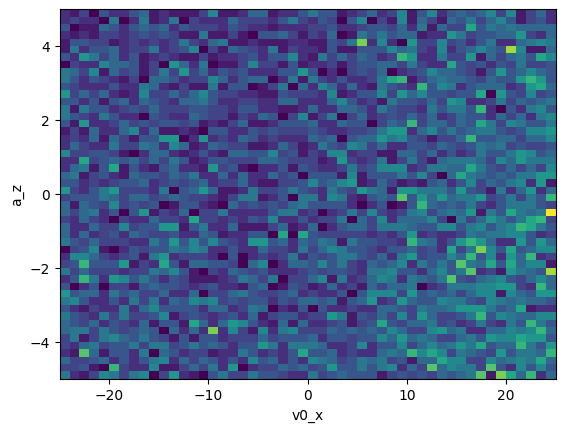

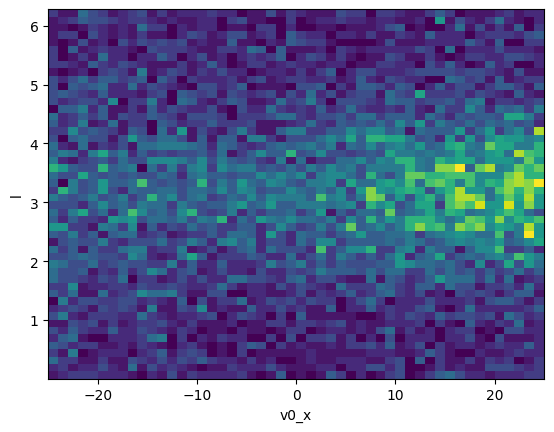

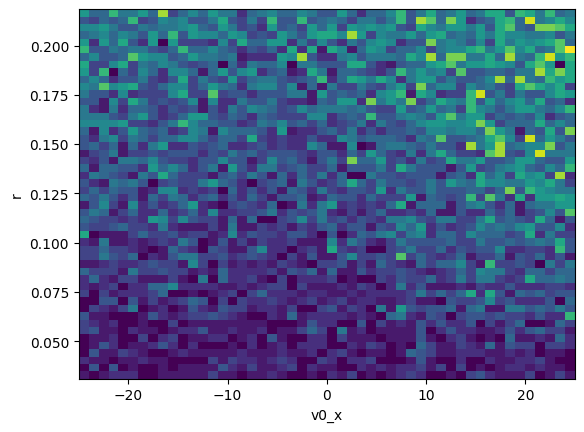

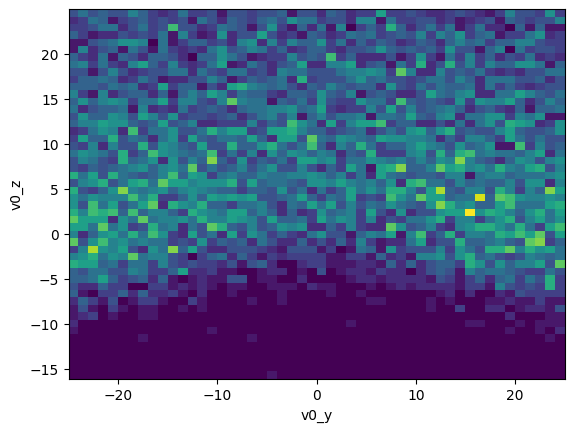

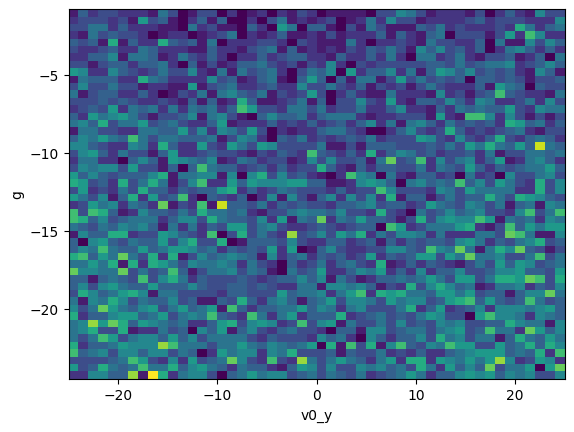

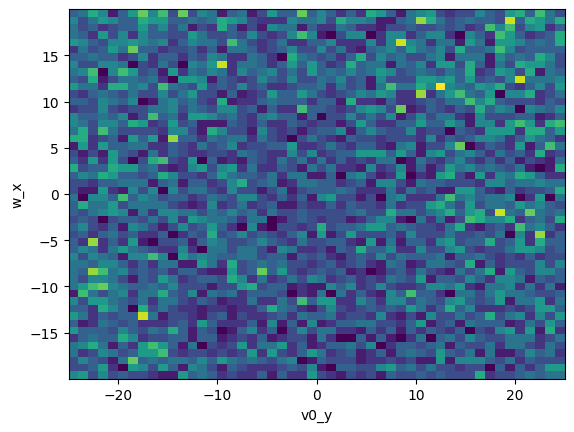

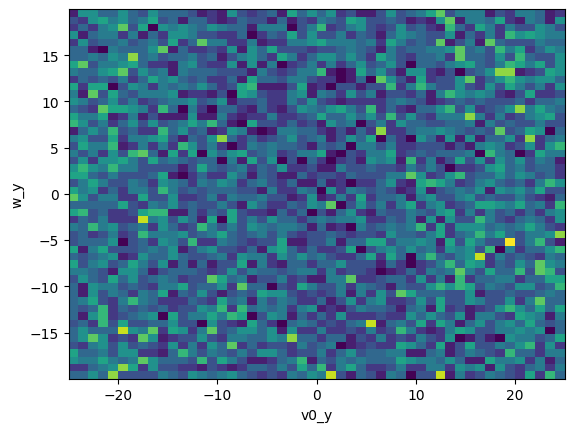

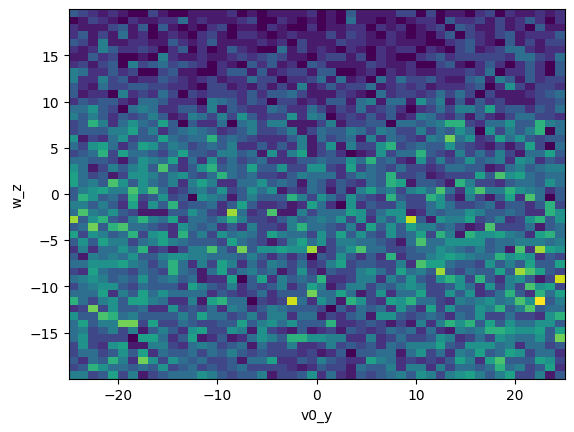

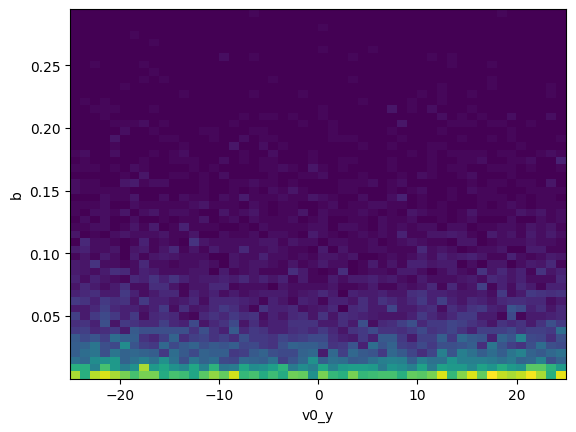

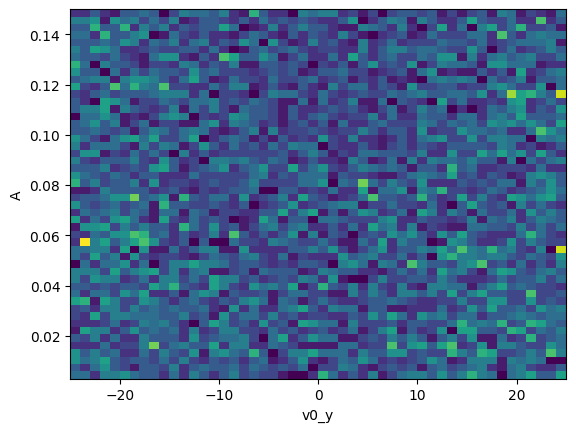

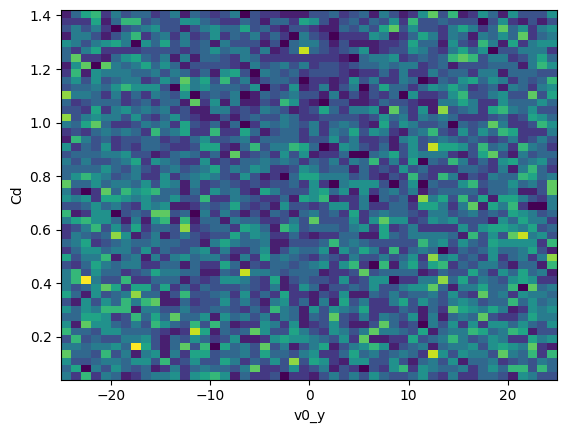

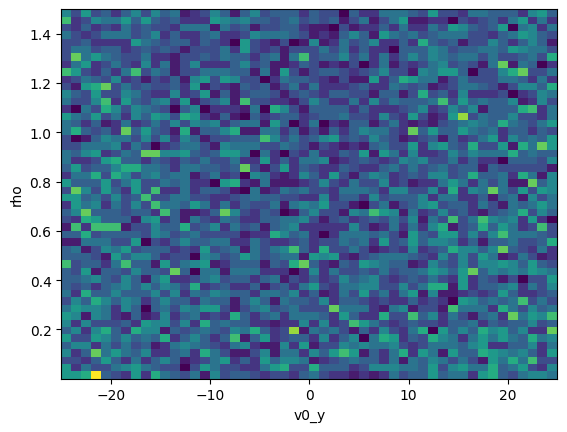

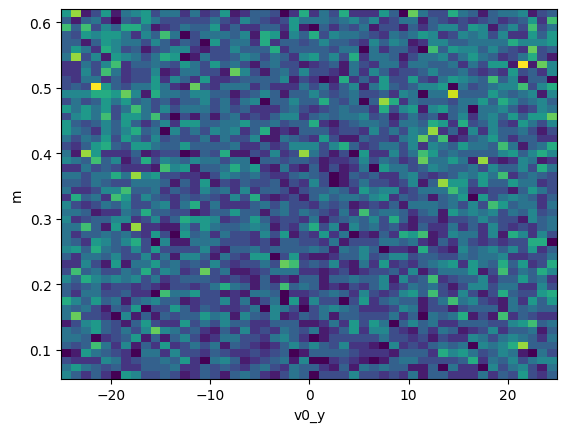

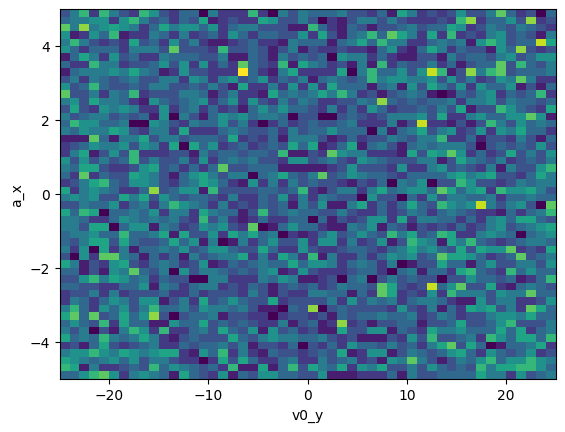

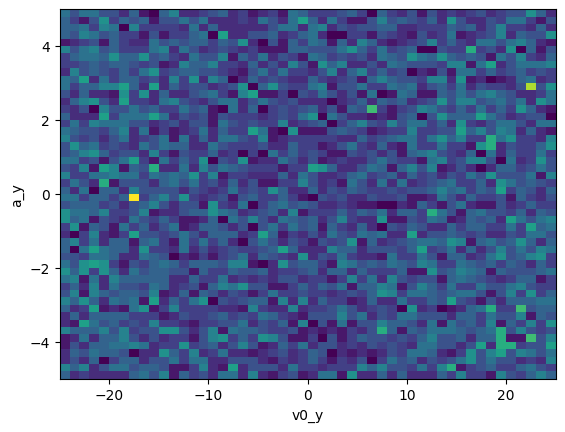

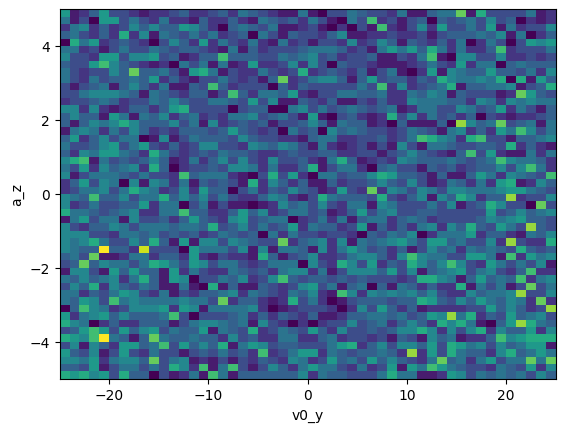

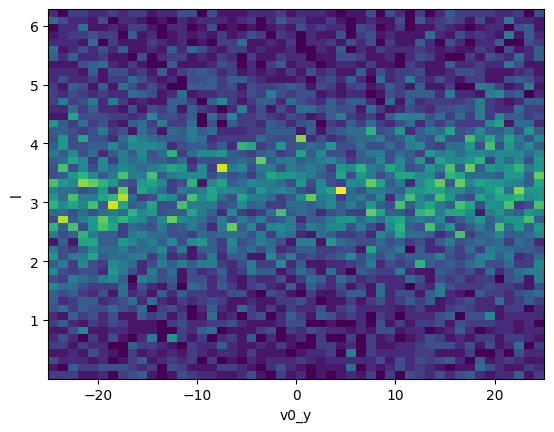

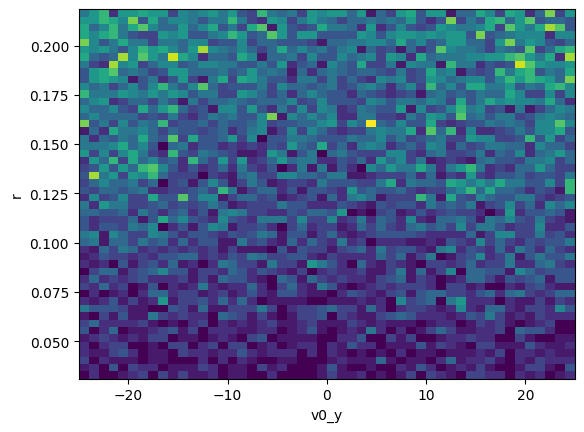

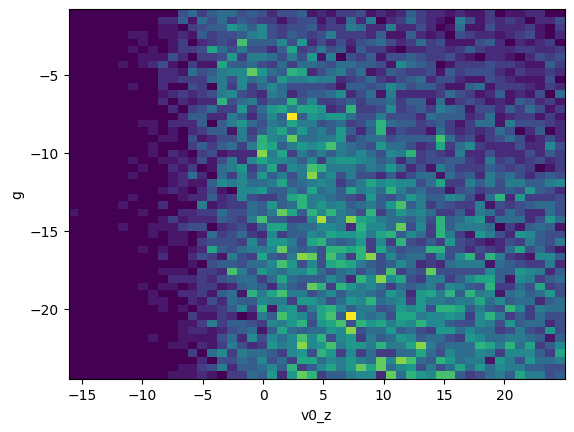

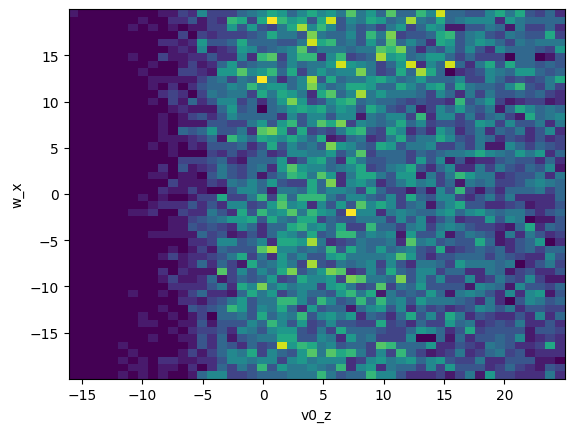

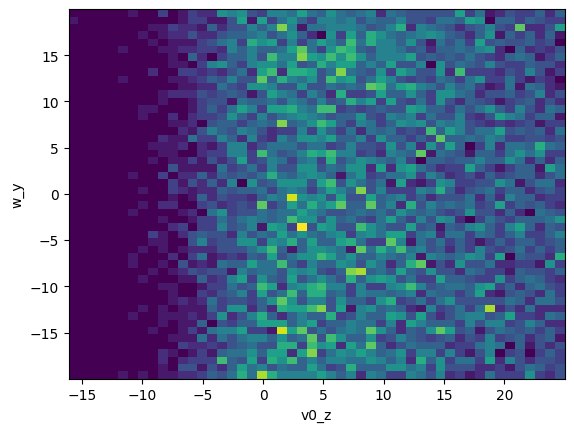

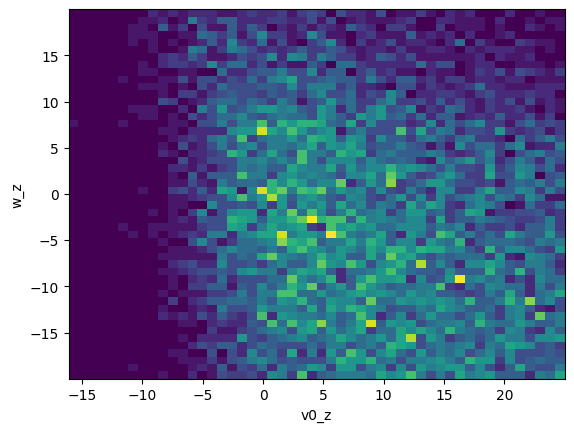

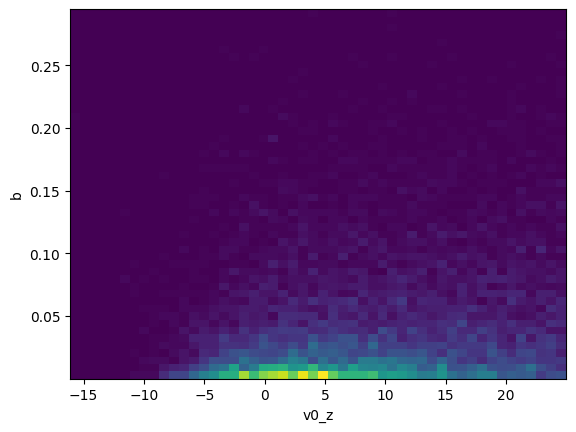

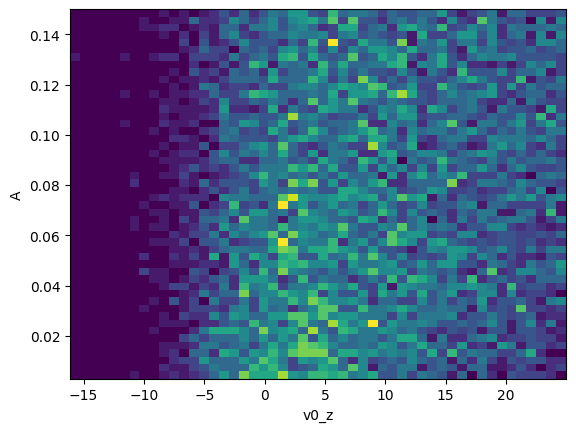

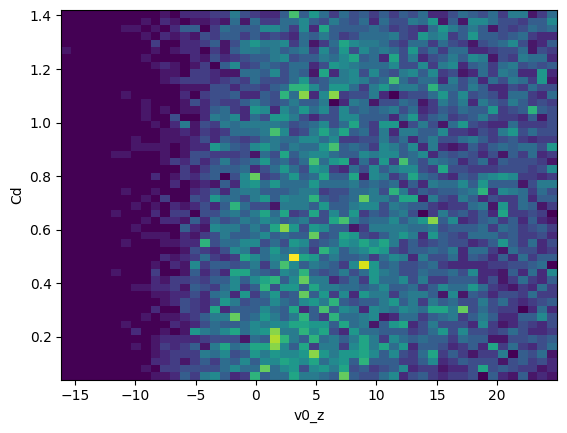

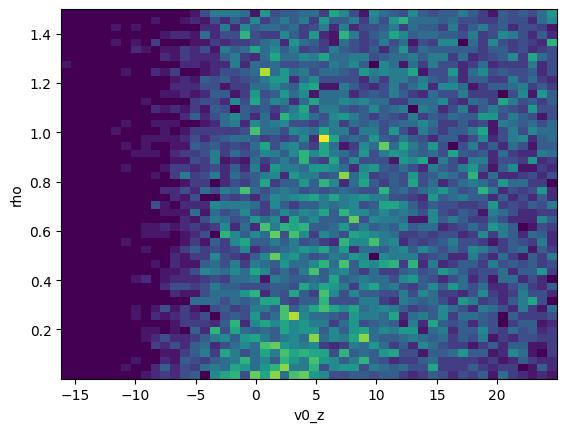

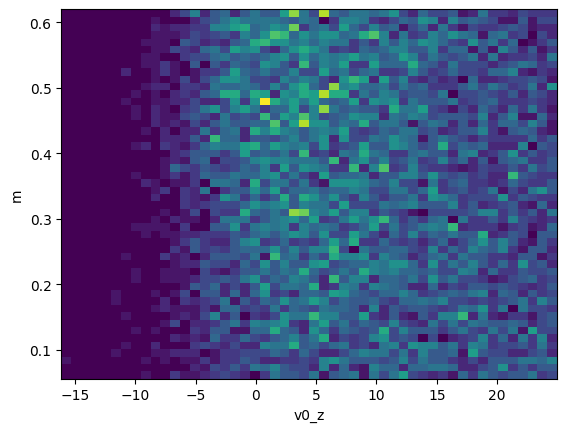

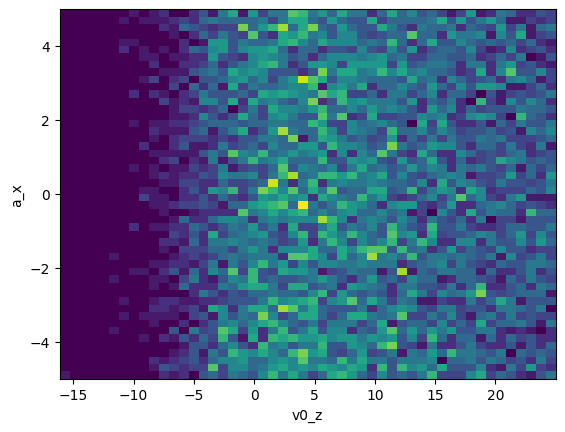

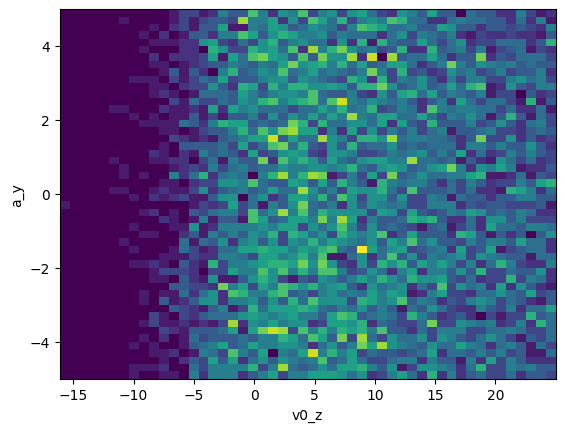

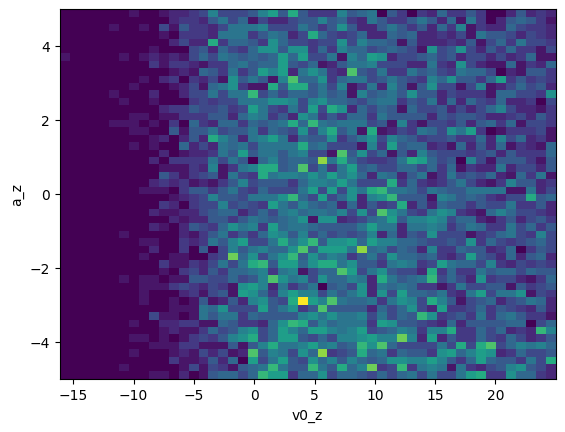

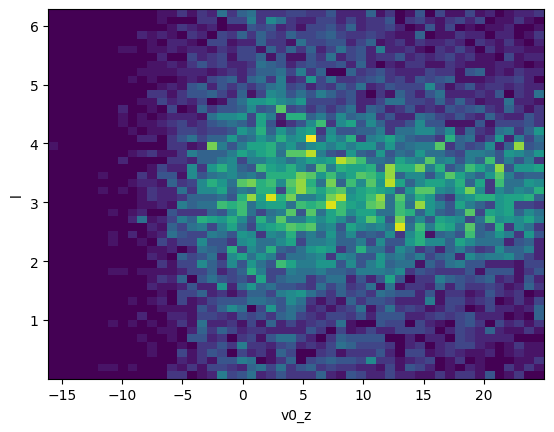

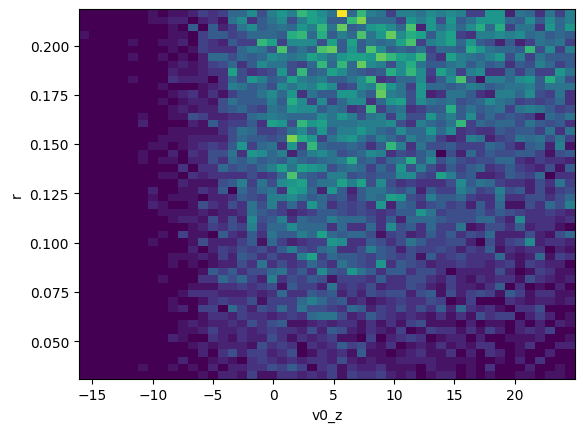

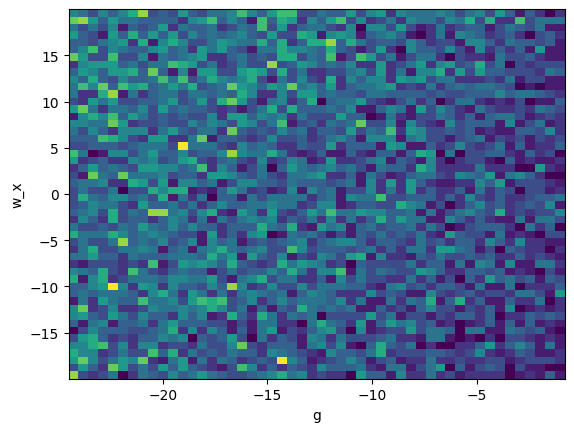

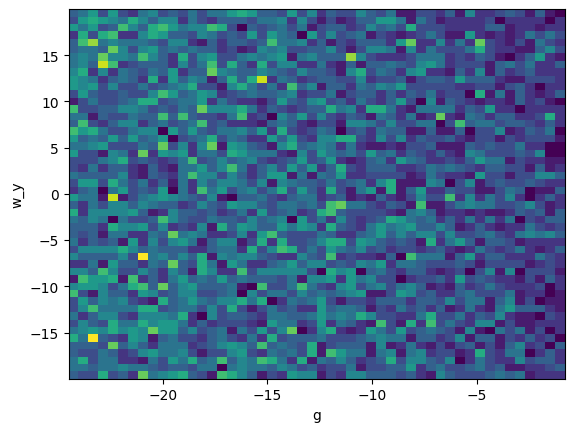

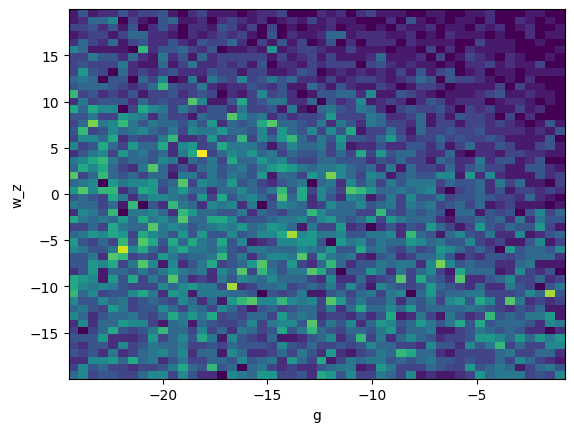

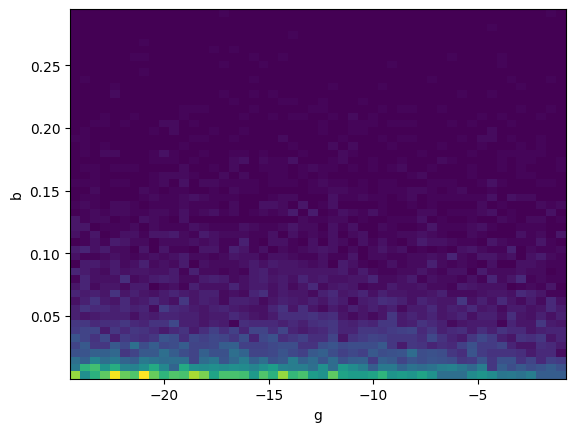

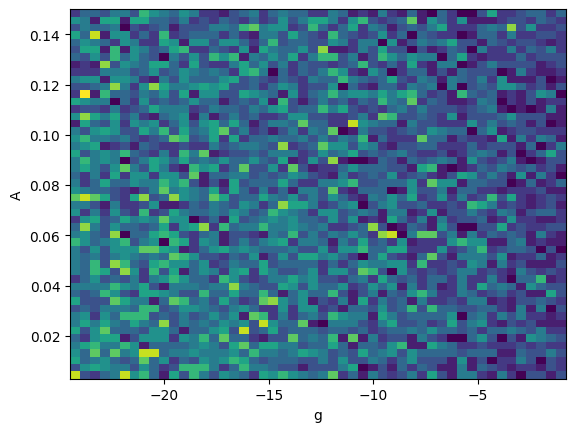

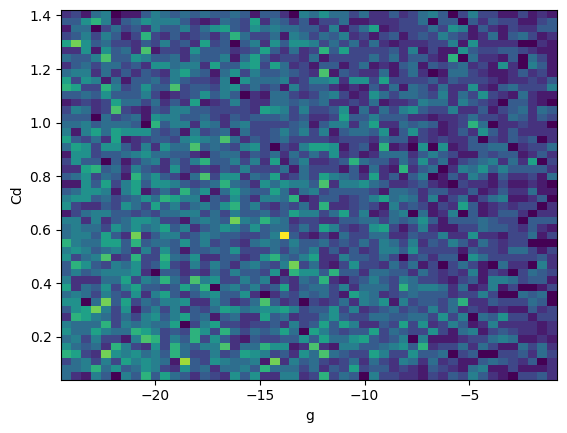

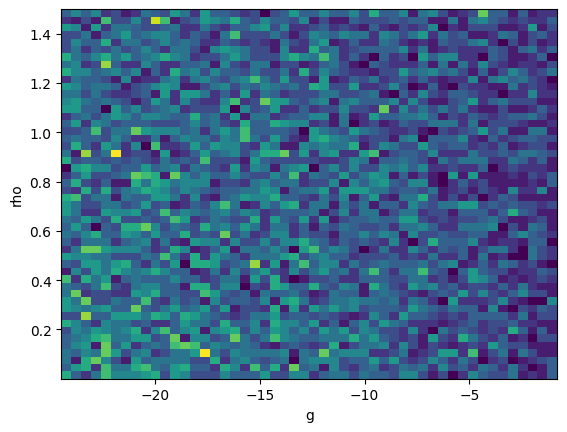

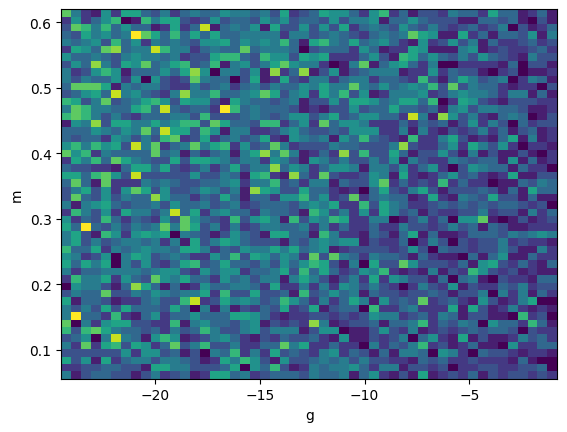

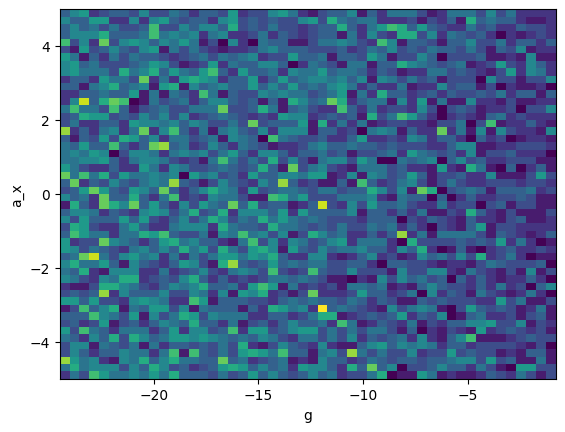

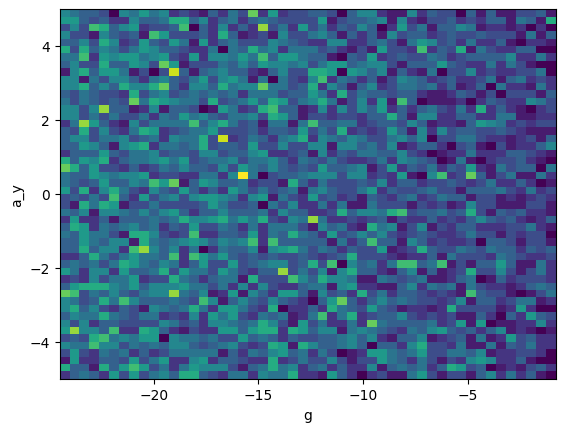

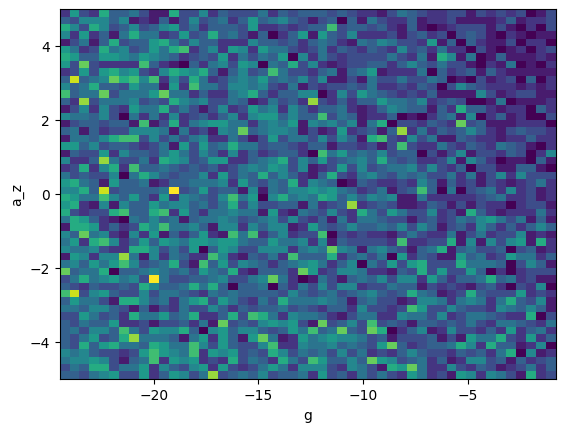

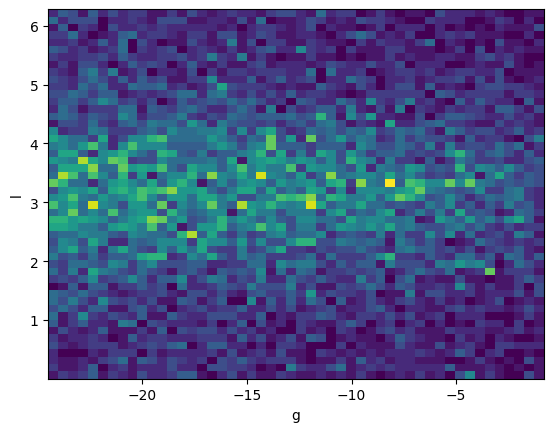

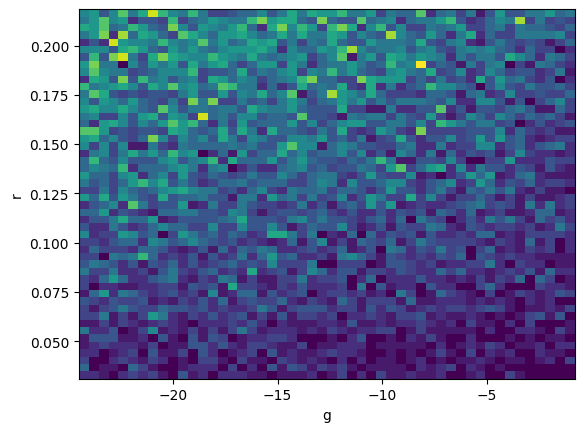

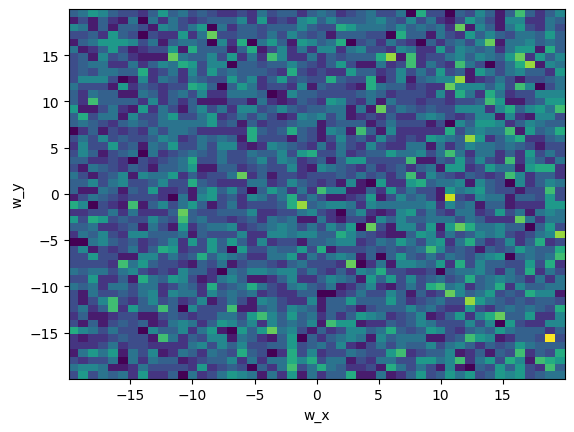

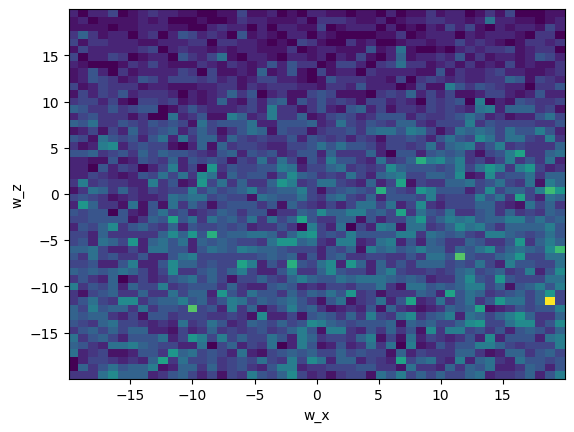

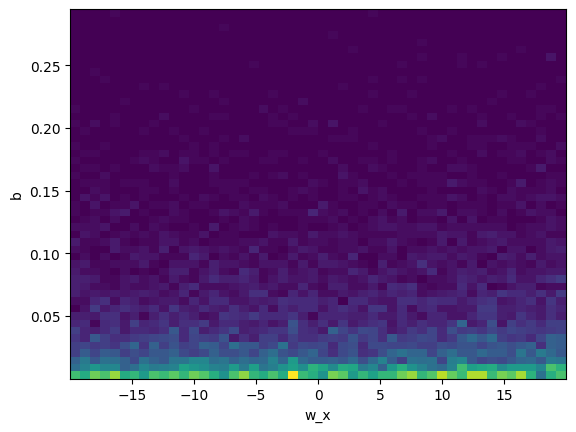

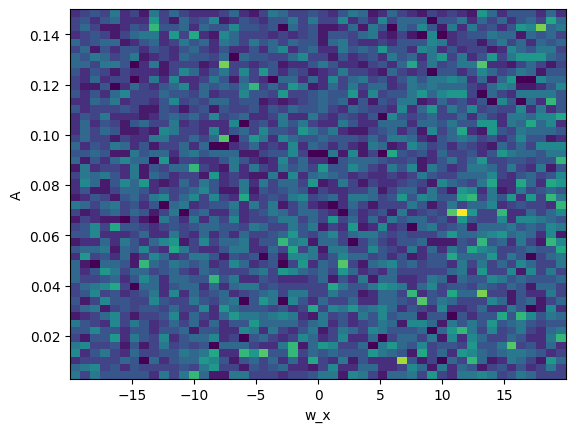

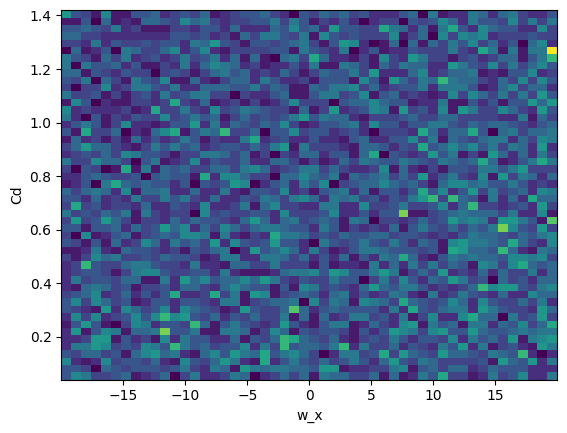

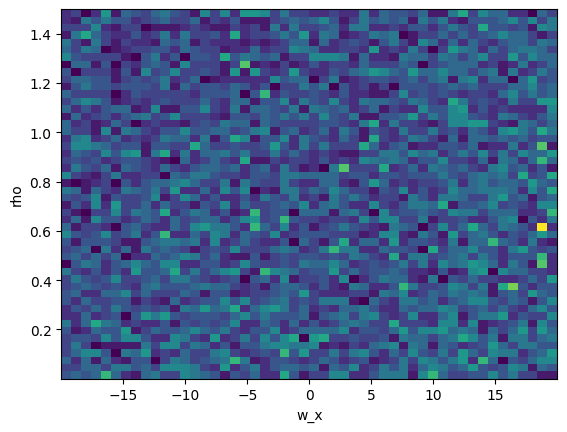

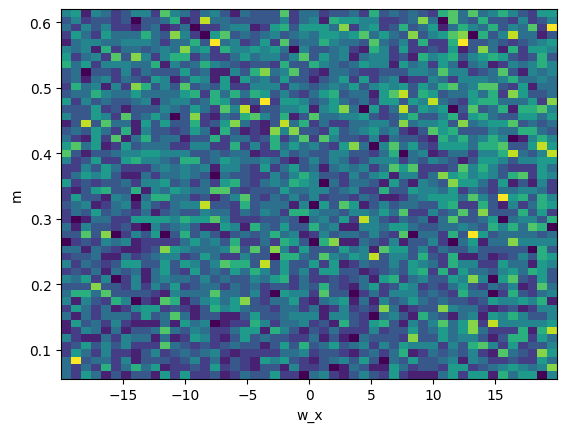

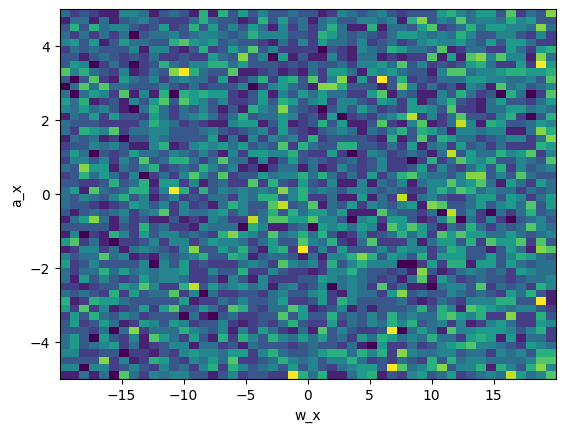

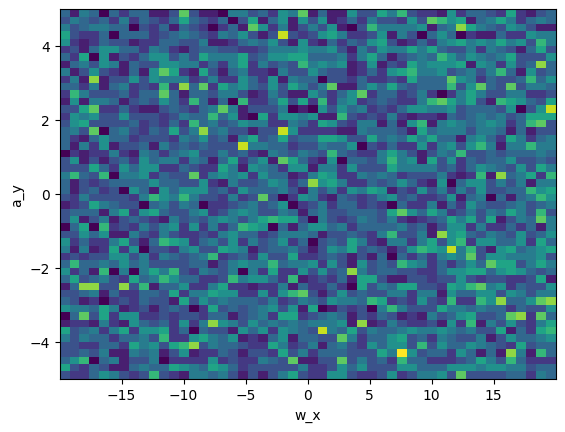

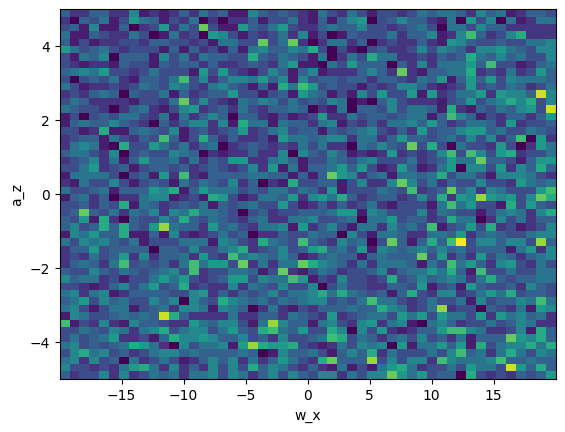

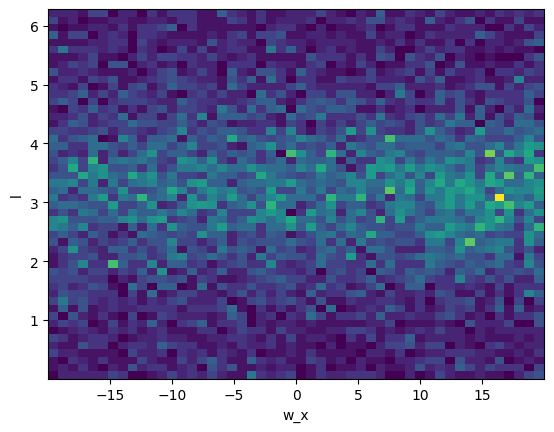

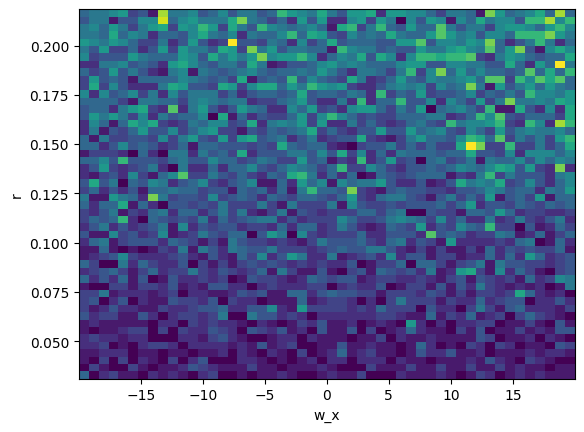

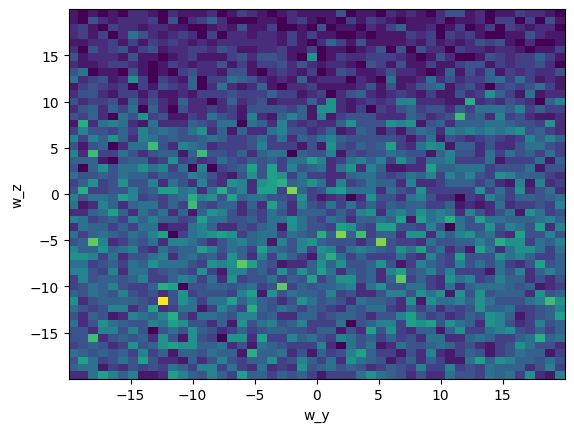

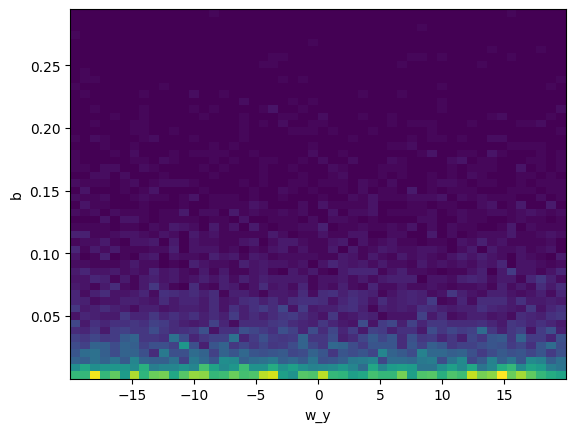

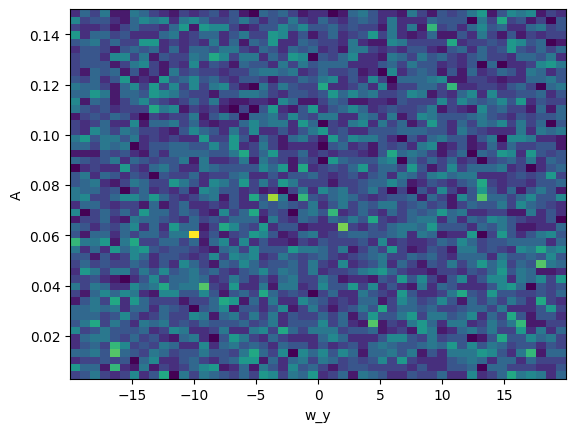

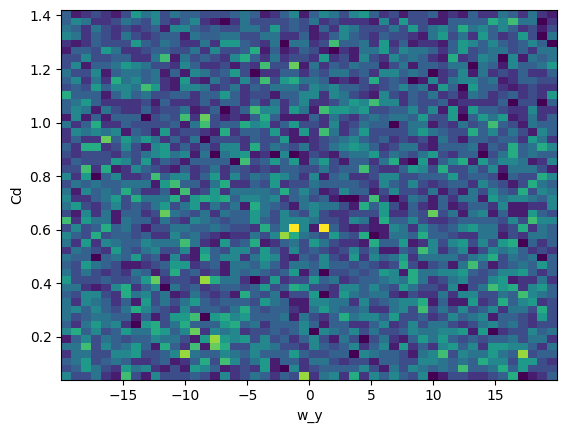

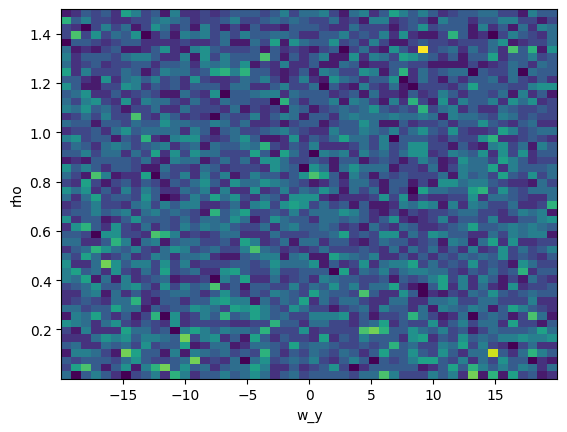

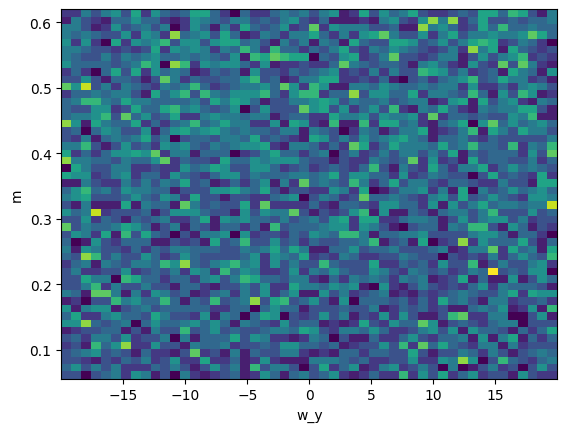

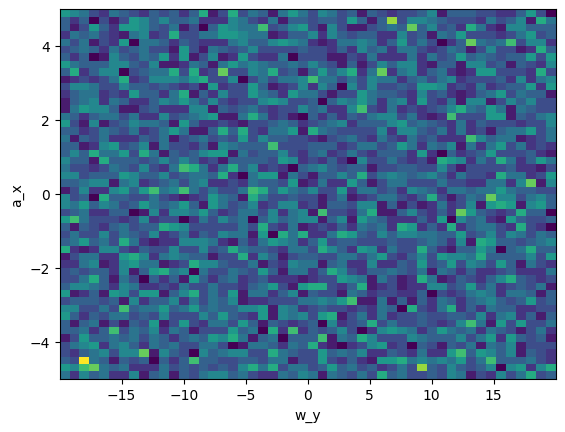

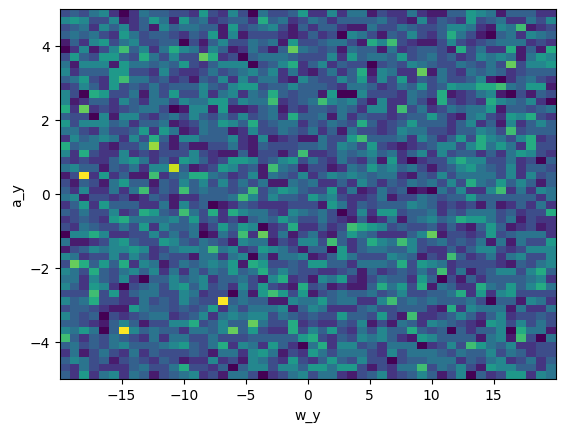

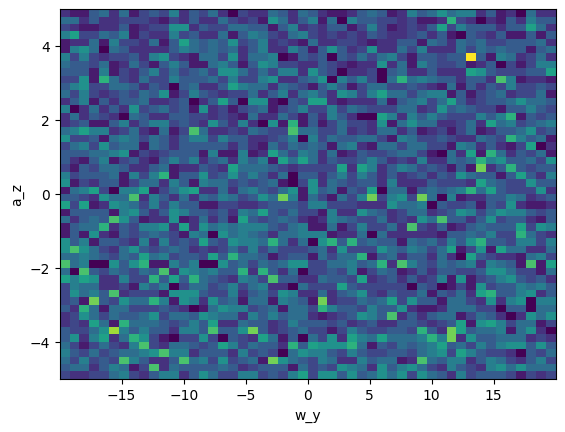

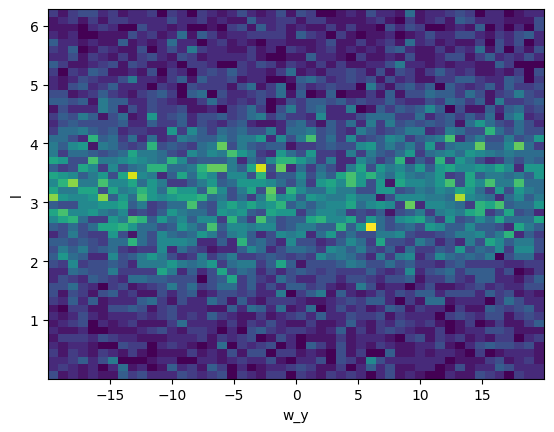

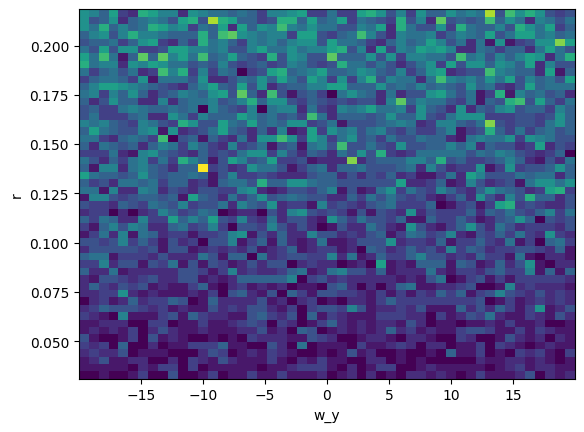

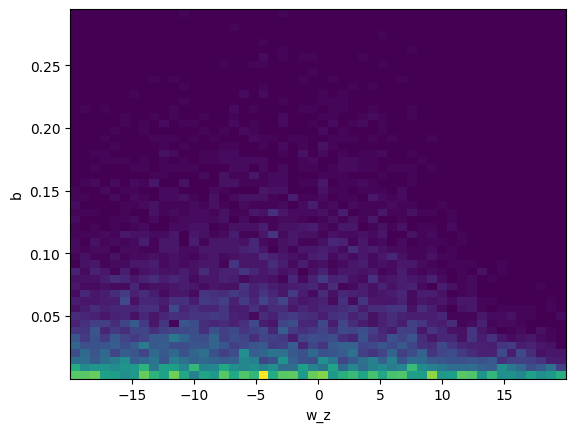

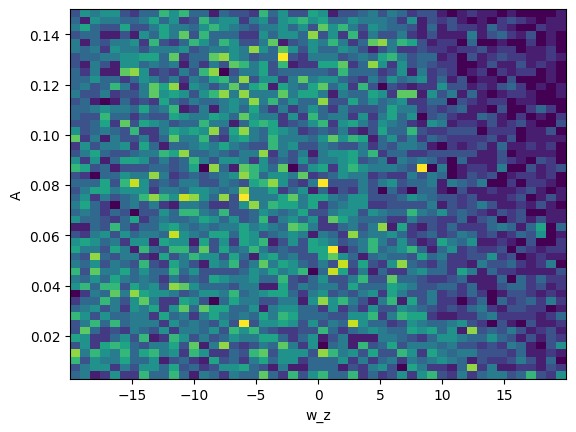

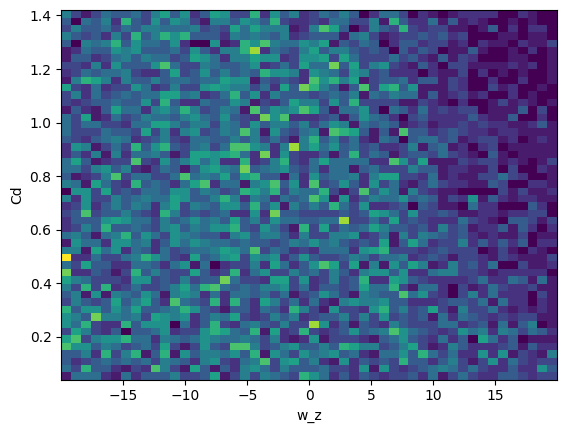

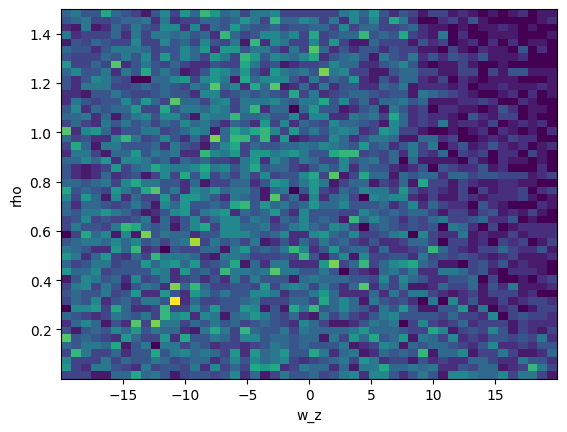

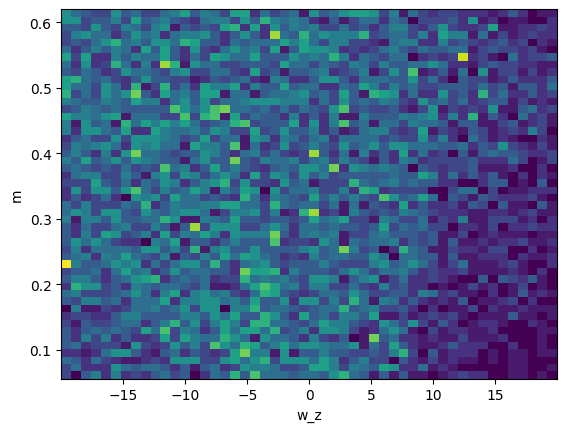

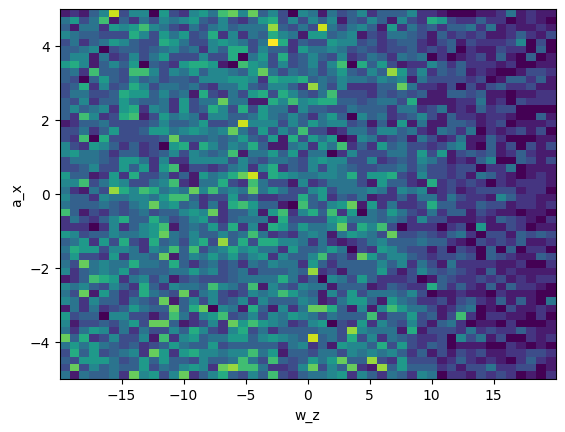

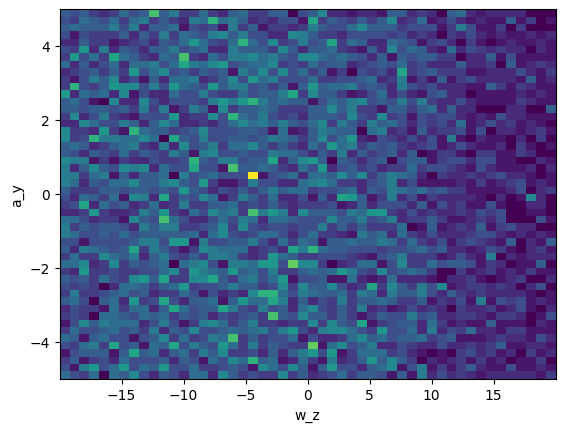

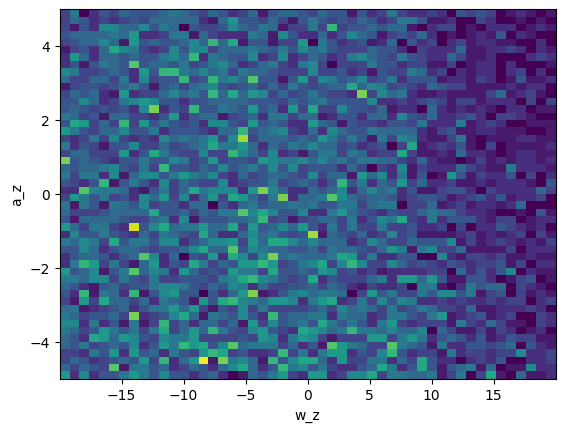

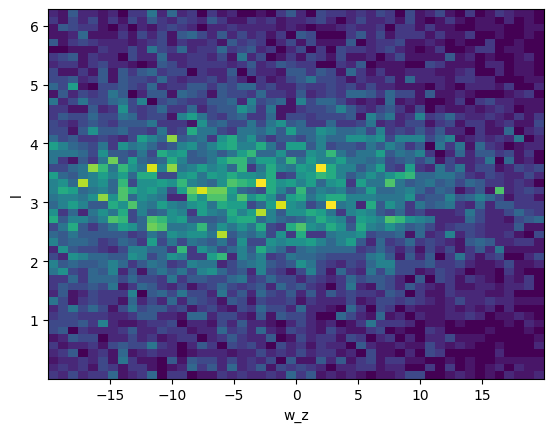

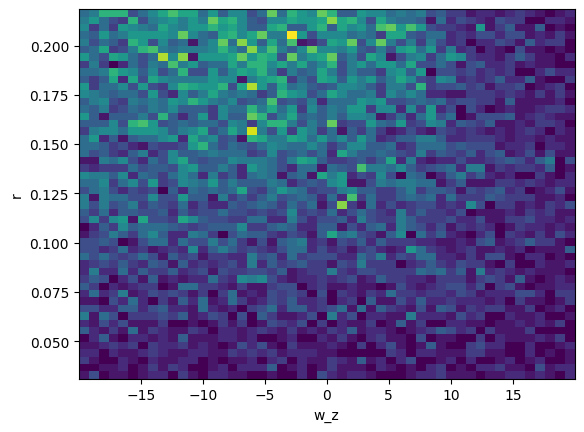

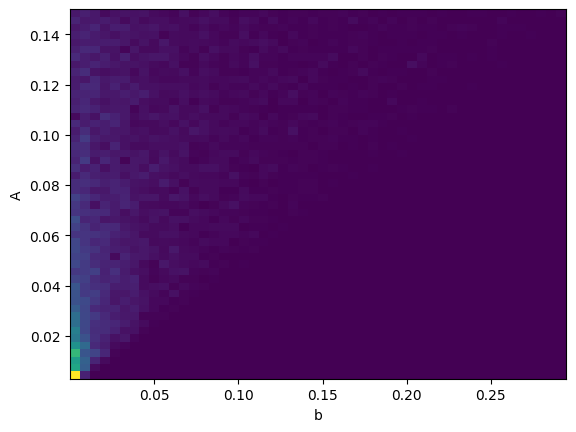

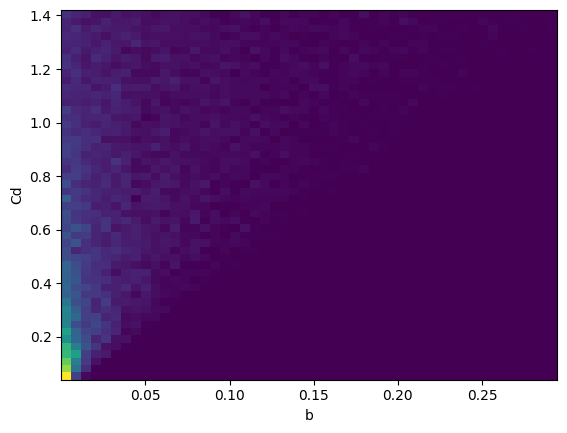

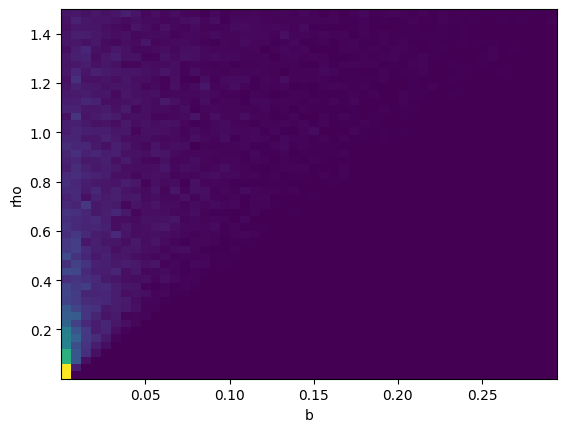

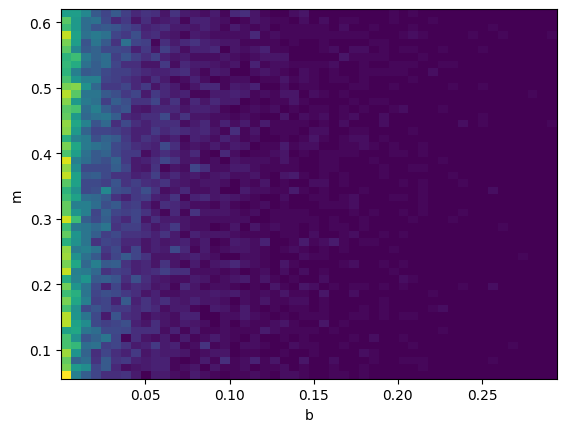

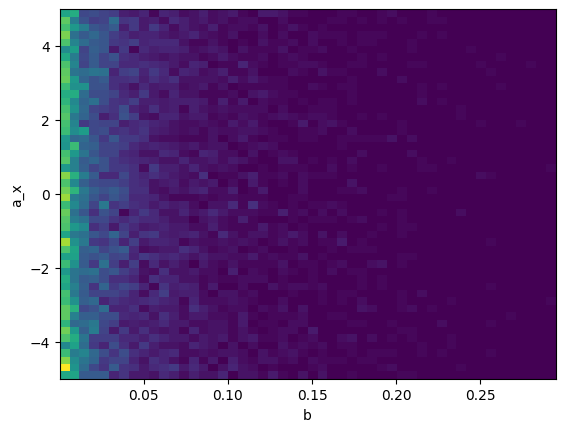

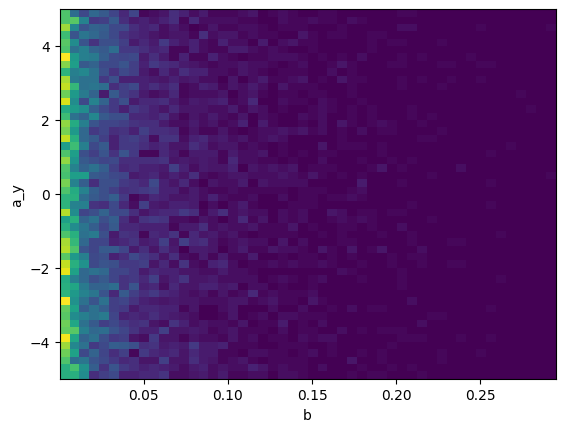

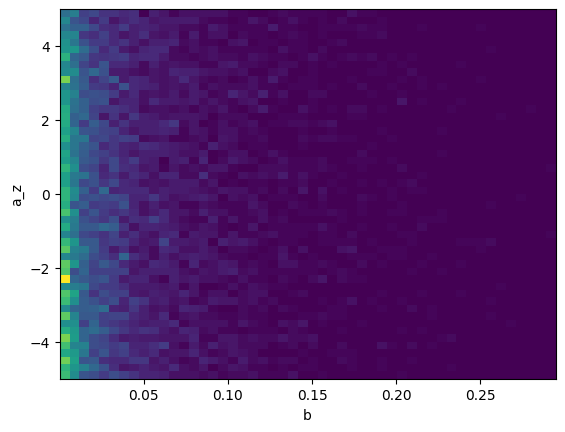

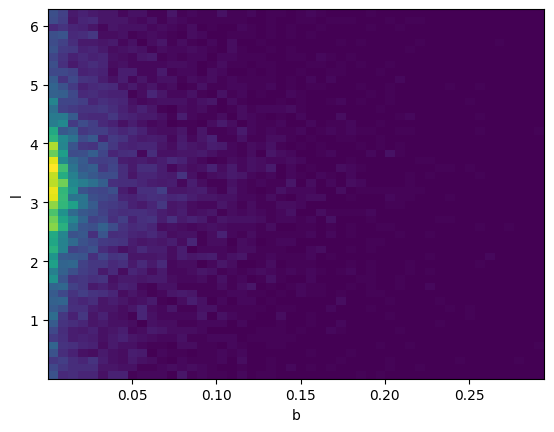

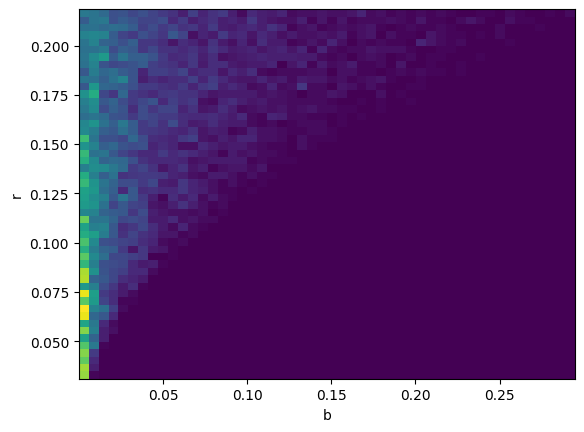

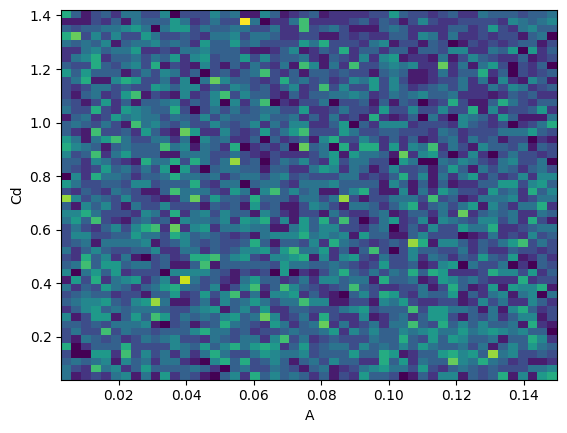

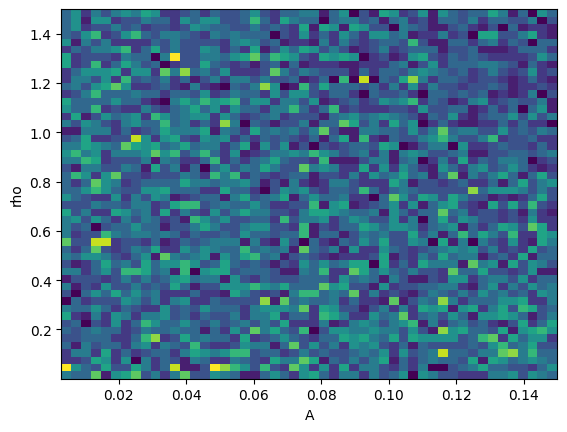

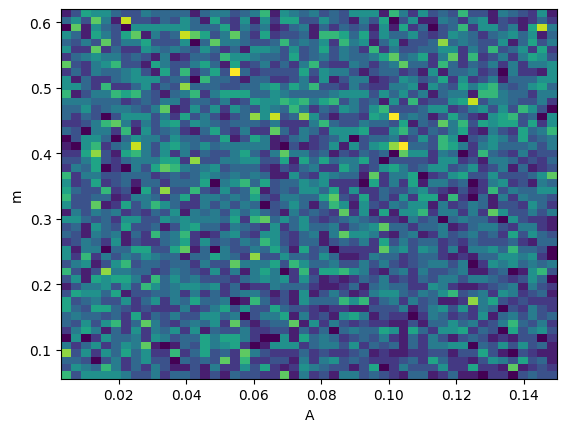

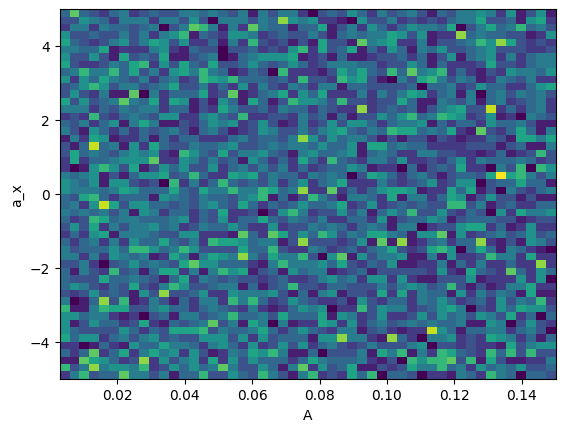

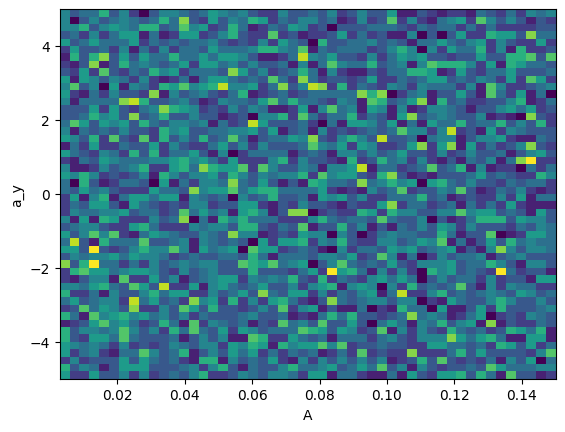

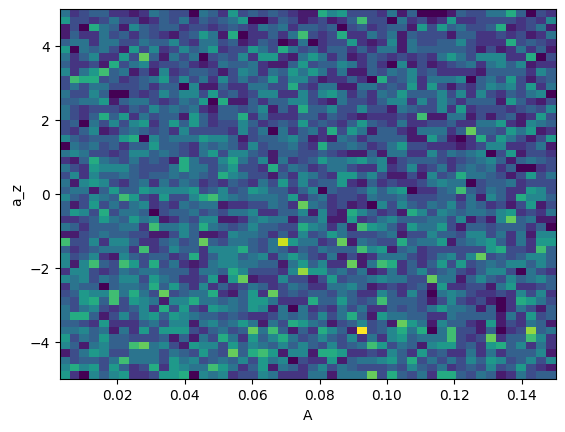

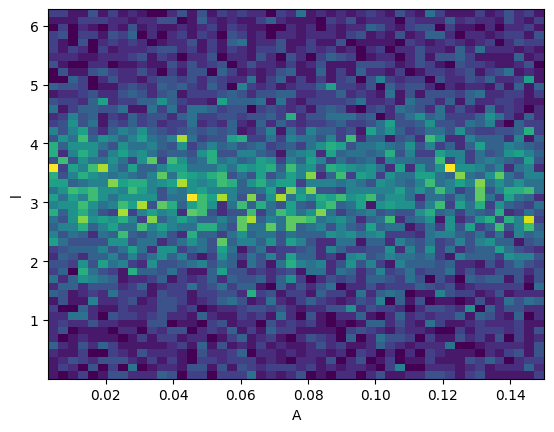

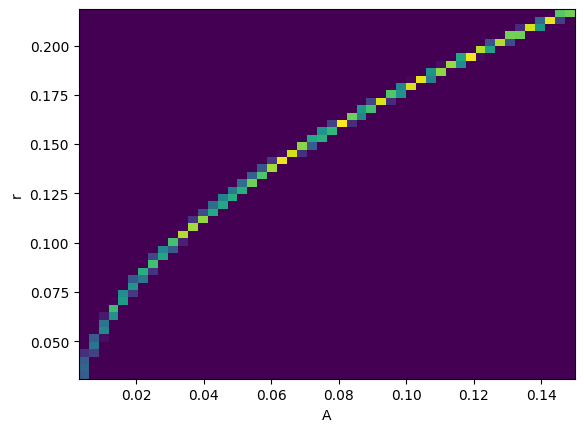

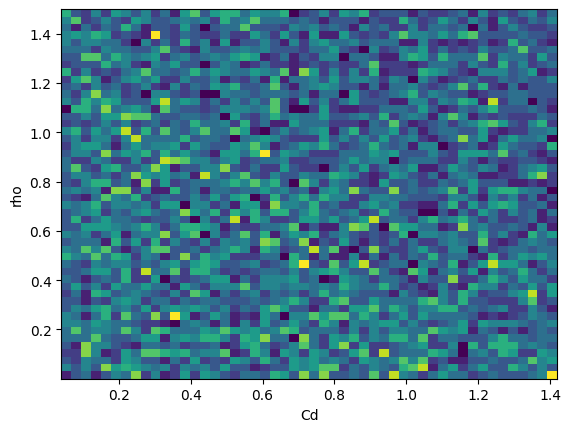

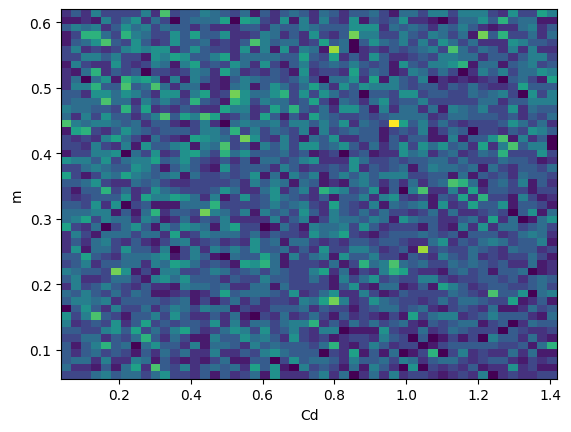

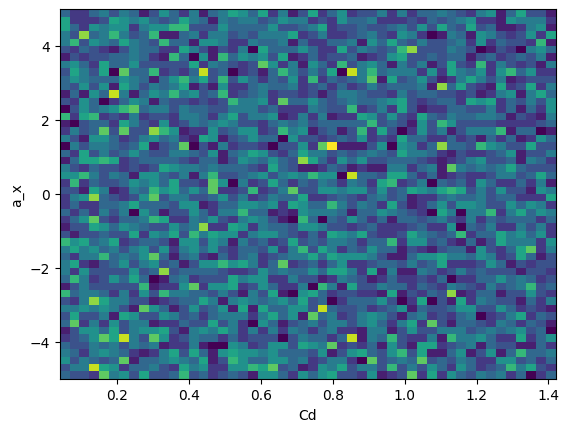

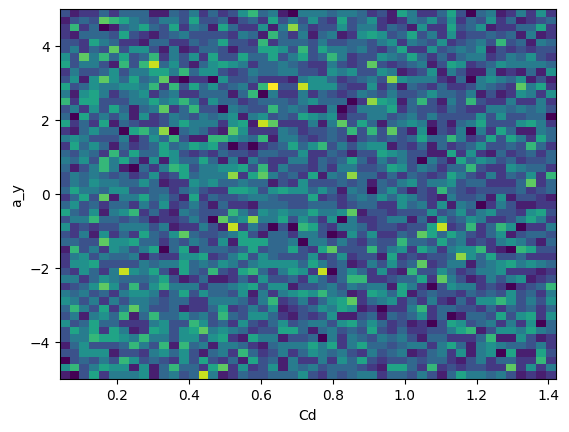

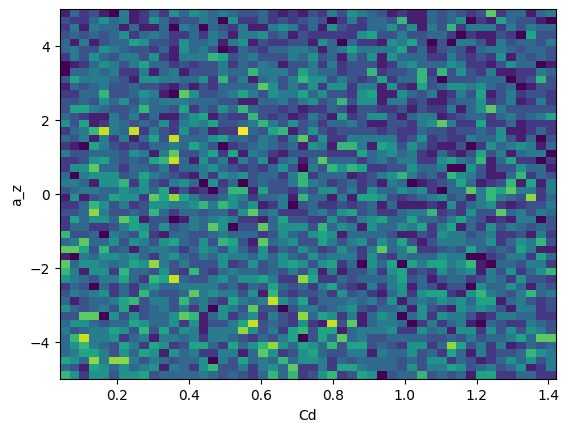

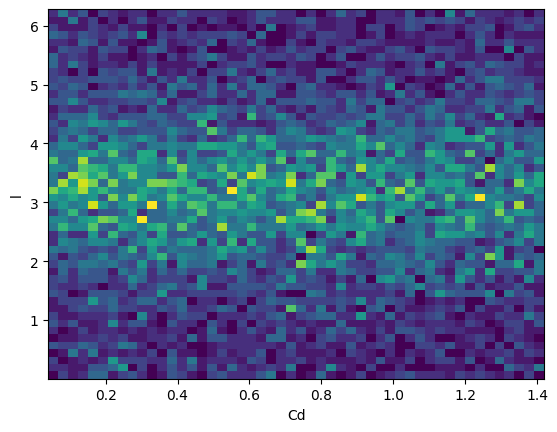

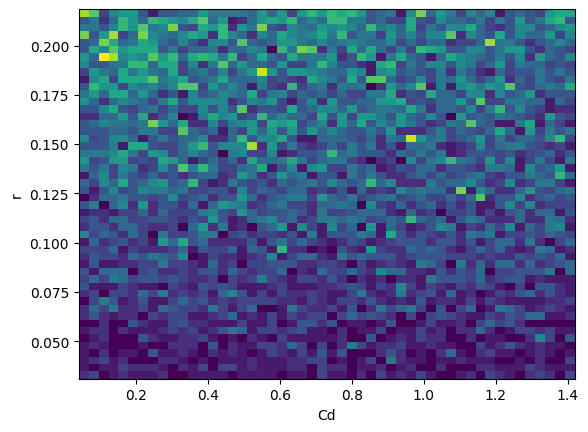

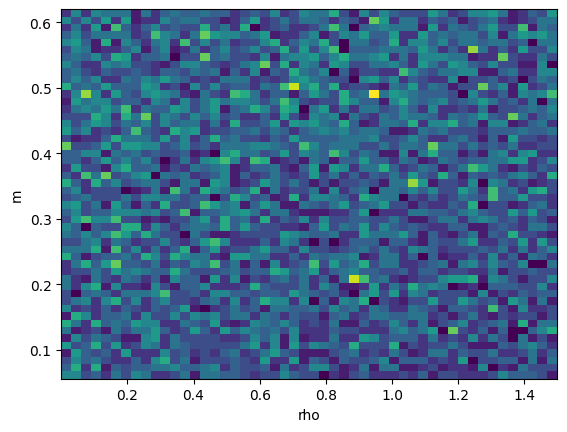

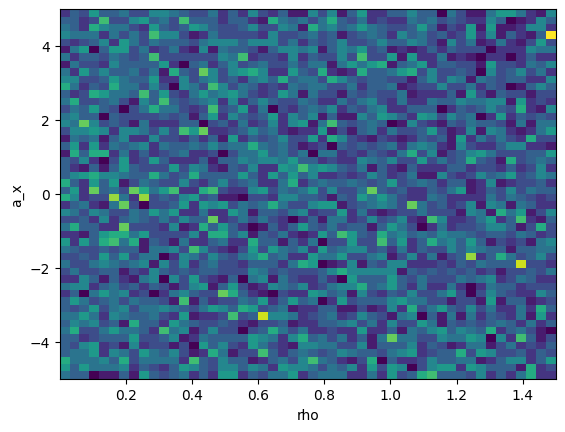

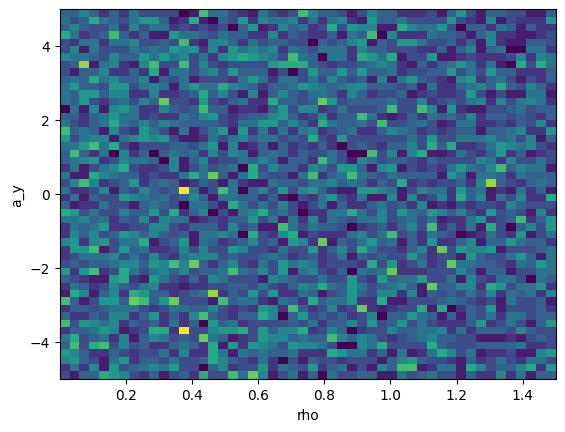

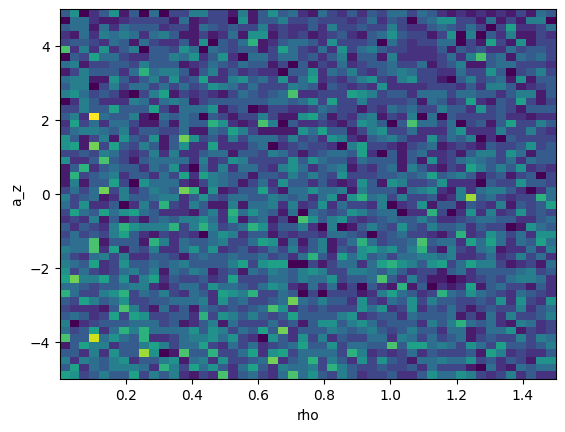

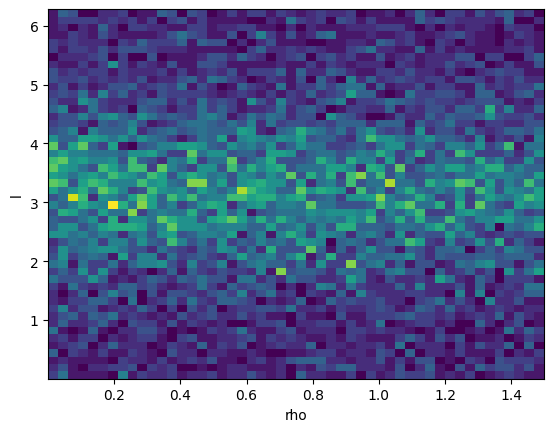

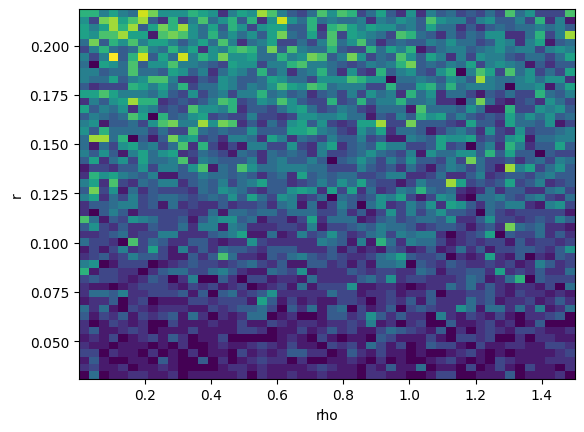

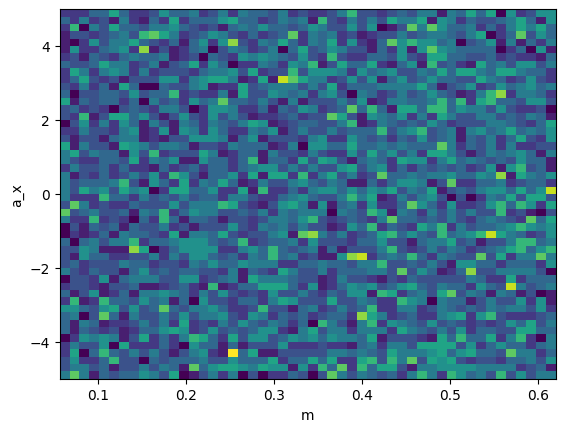

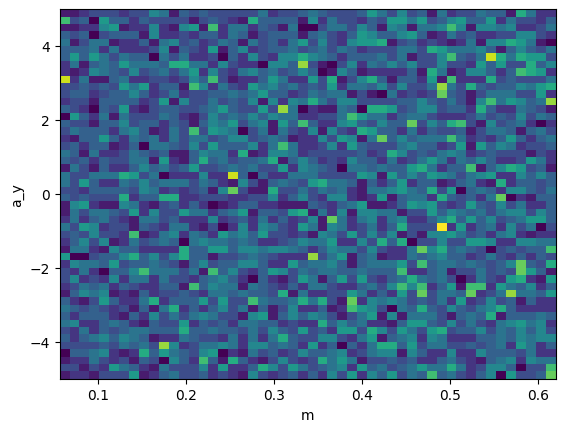

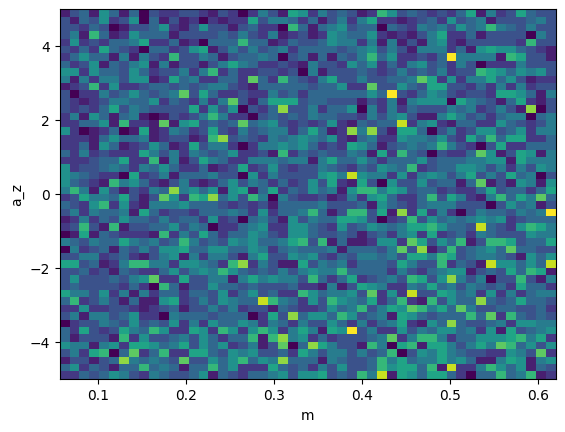

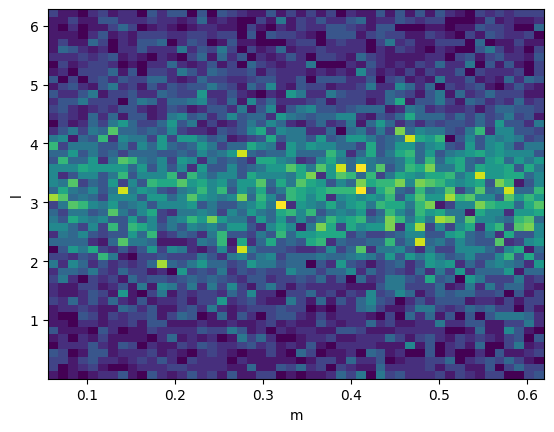

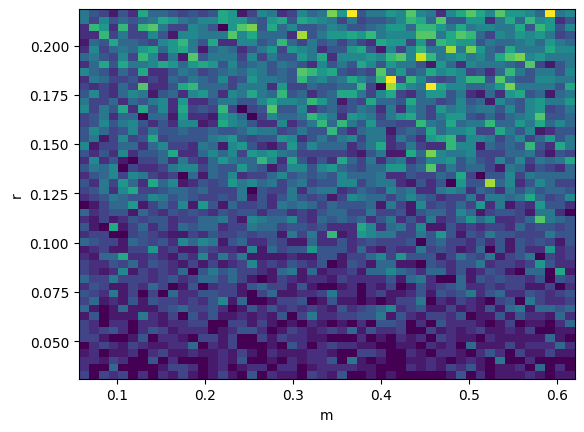

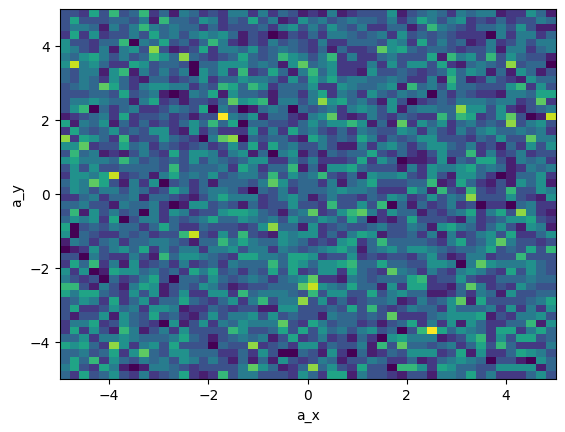

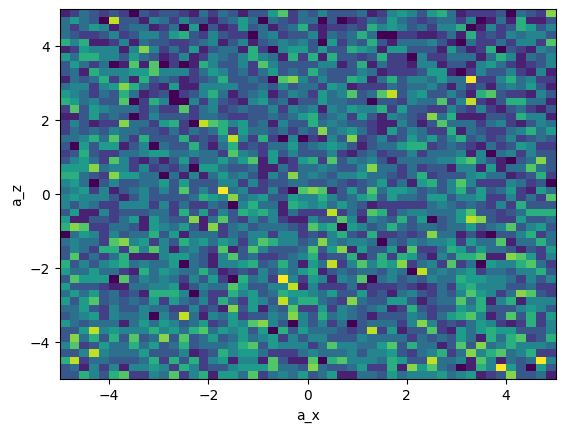

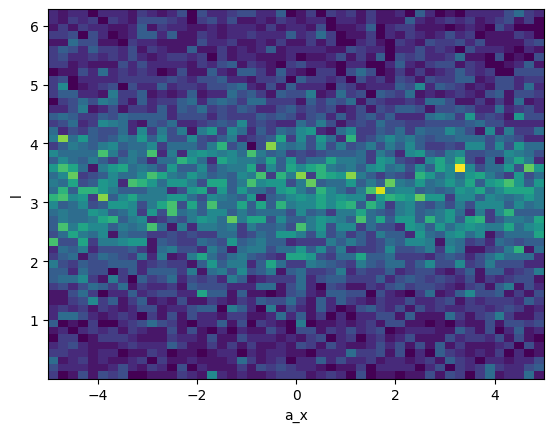

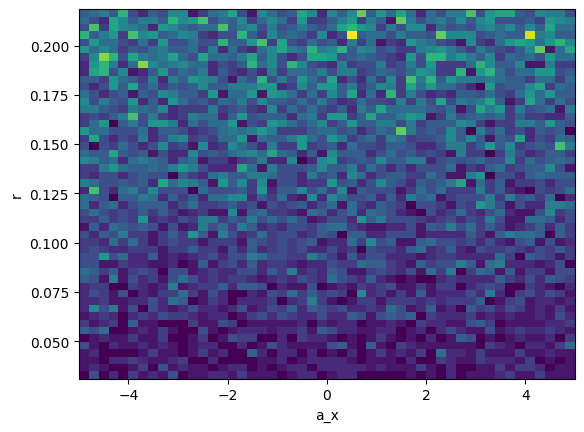

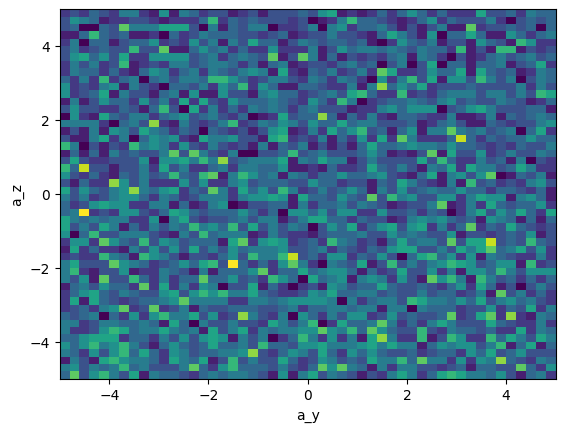

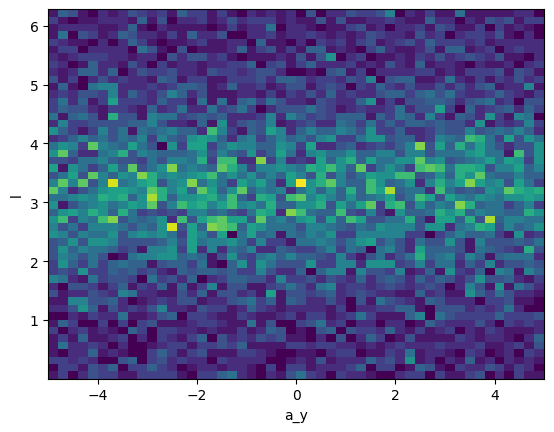

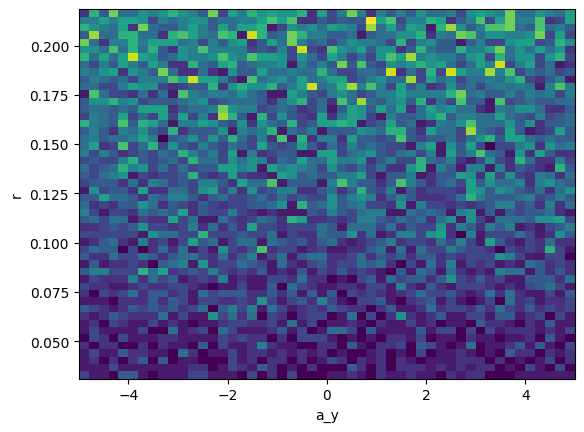

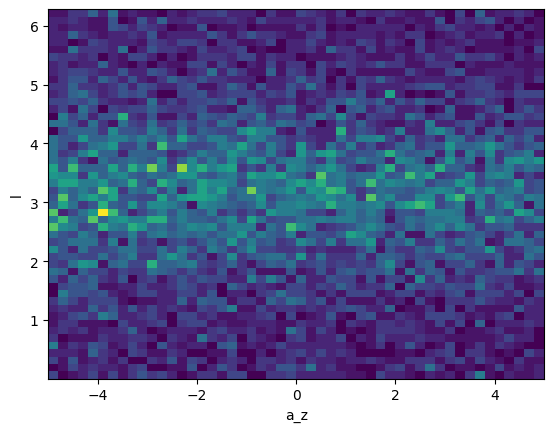

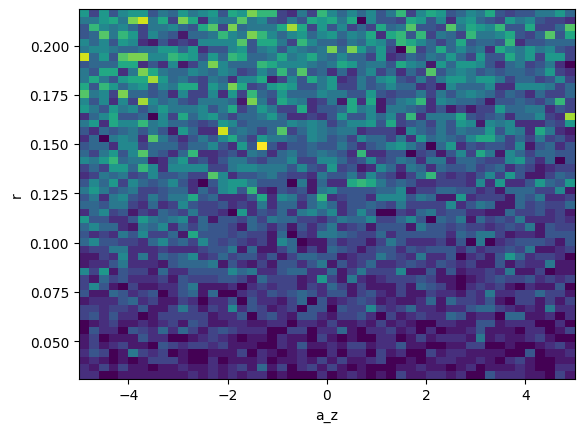

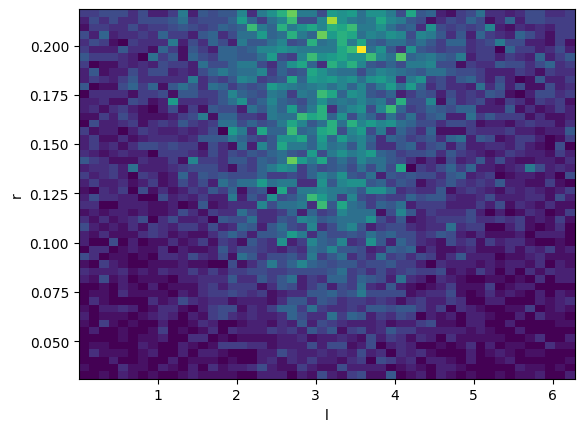

In [7]:
# plot 2d hist of all pairs
for i in range(df.shape[1]):
    for j in range(i + 1, df.shape[1]):
        plt.hist2d(df.iloc[:, i], df.iloc[:, j], bins=50)
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.show()

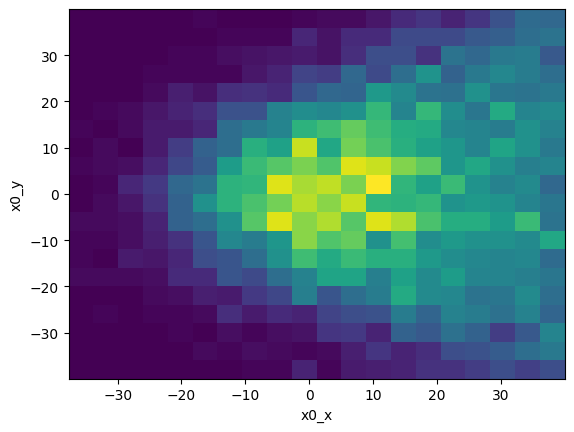

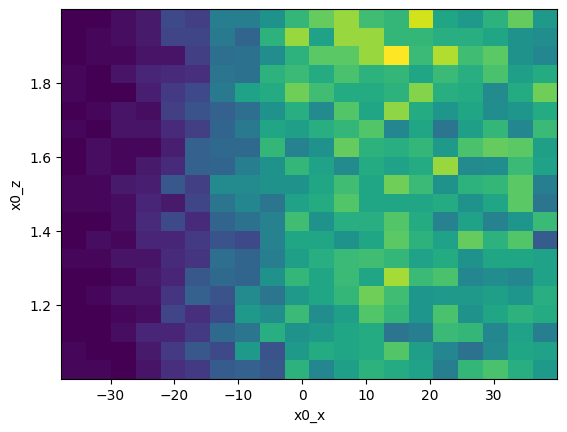

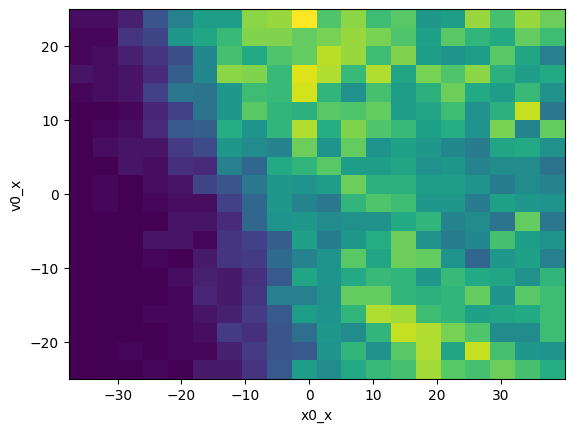

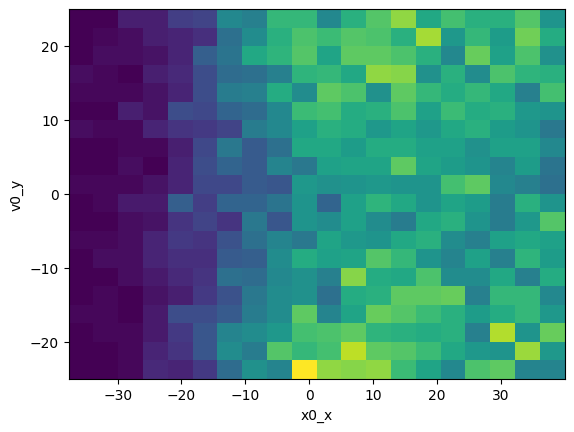

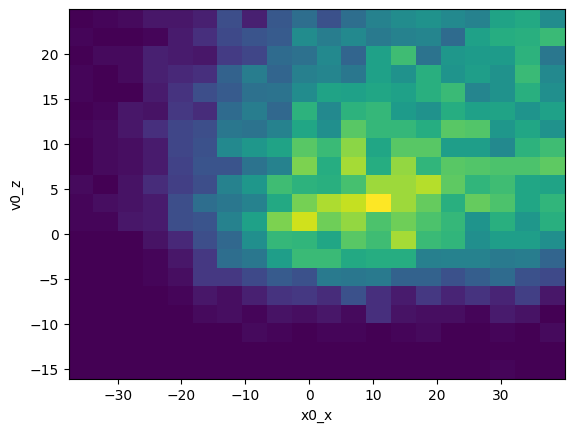

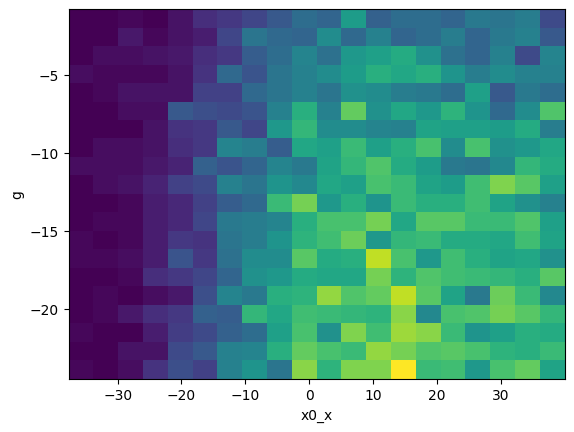

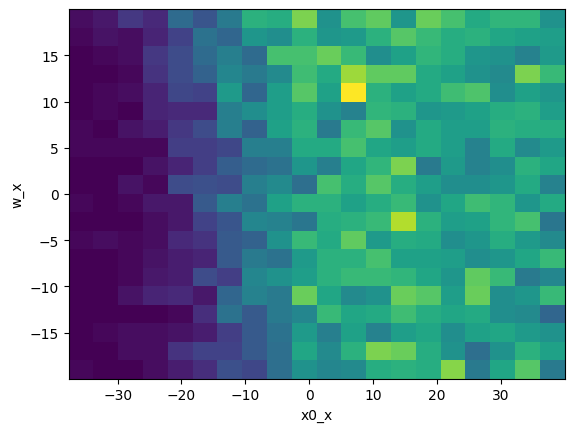

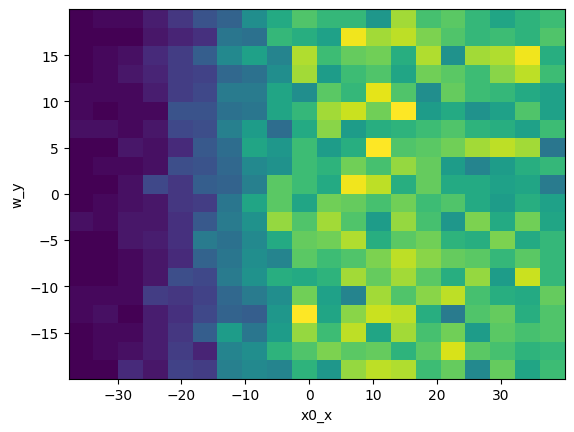

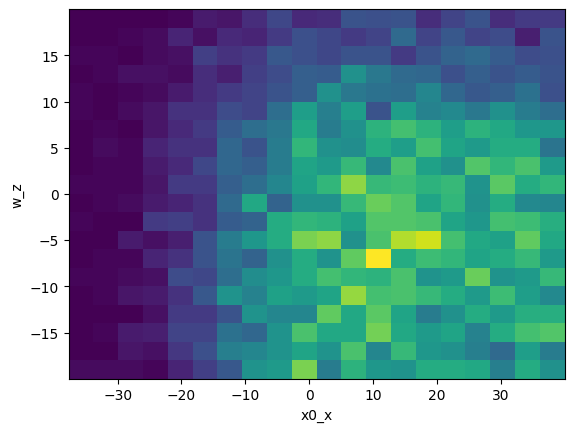

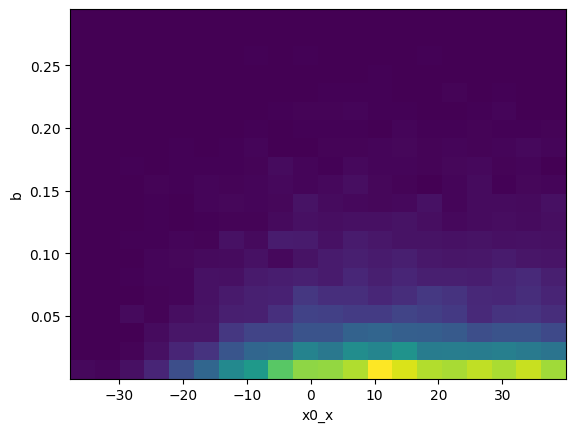

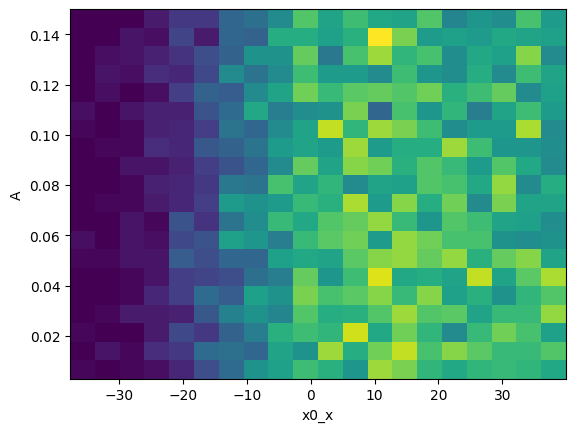

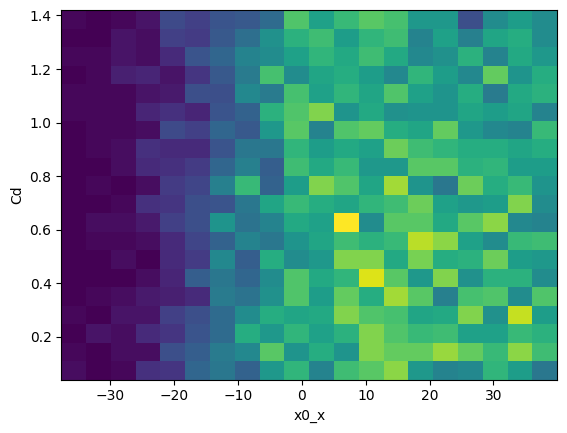

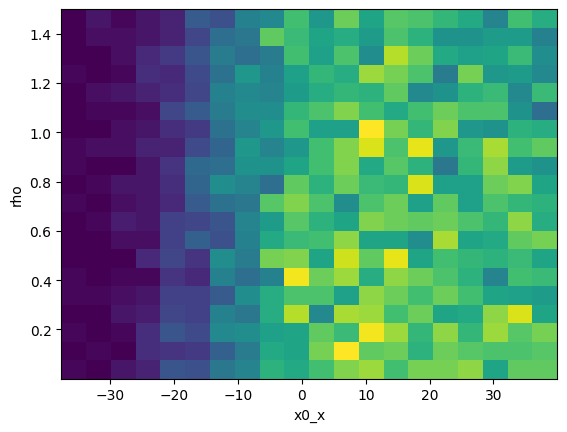

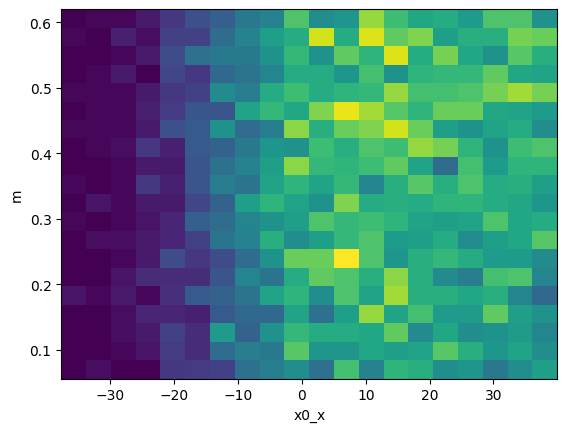

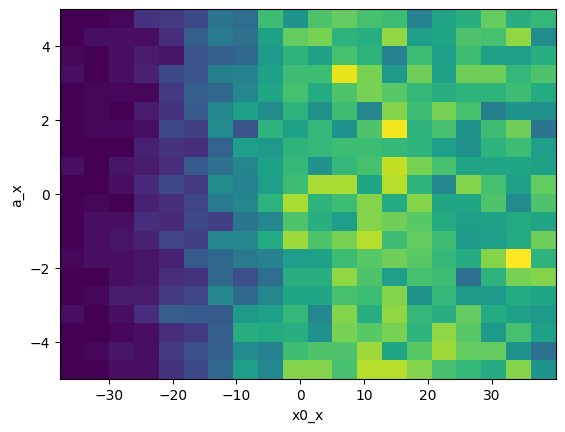

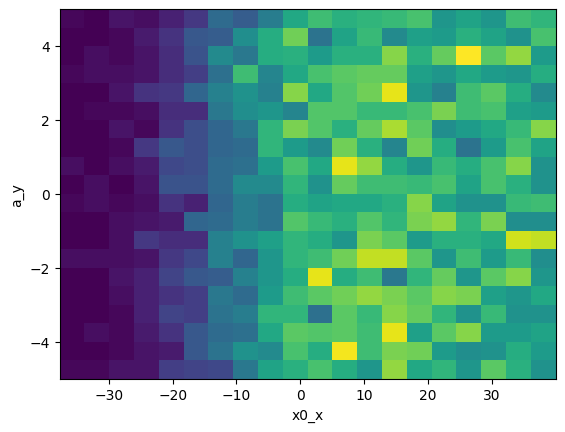

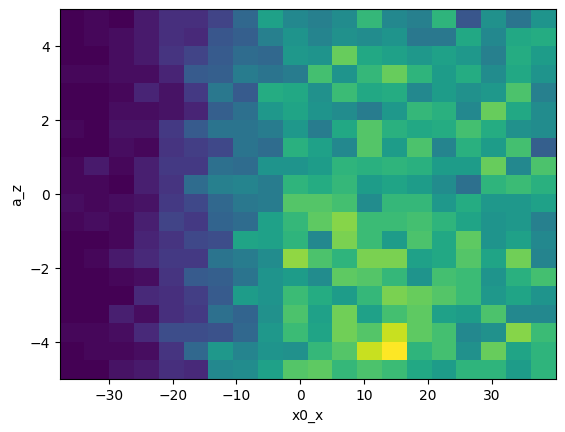

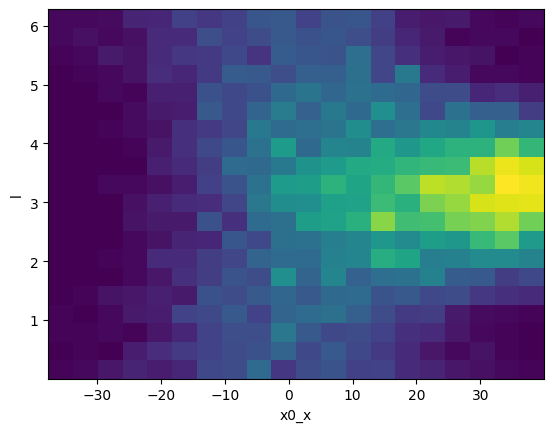

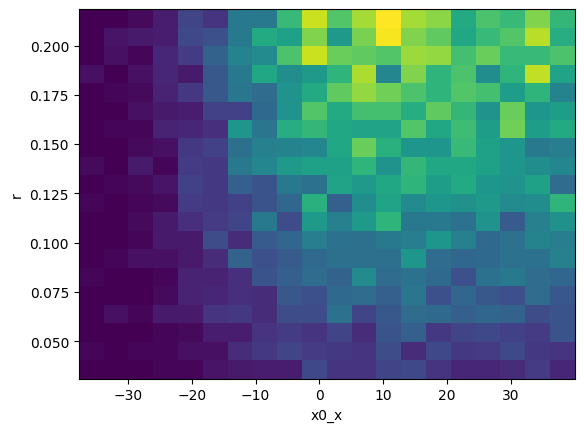

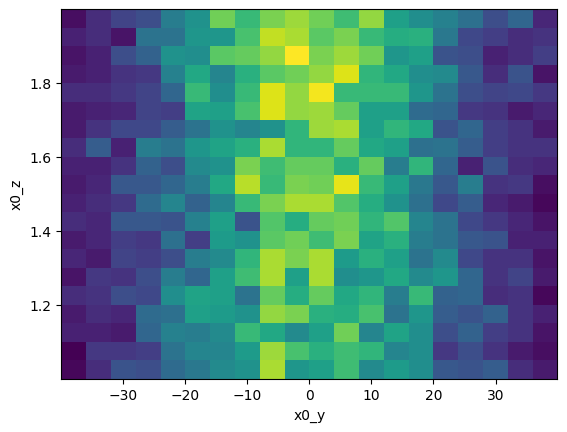

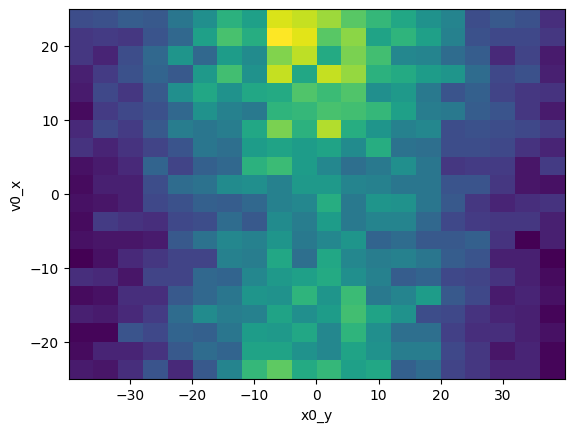

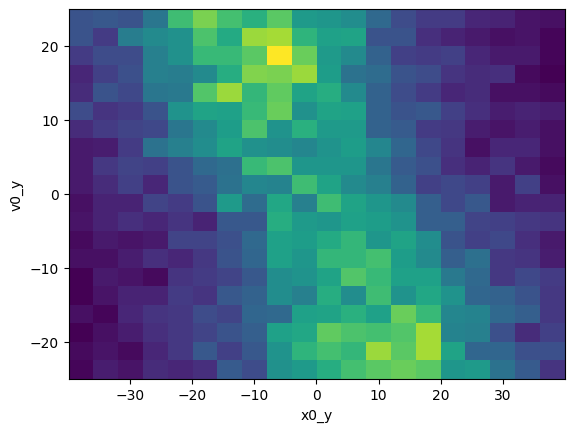

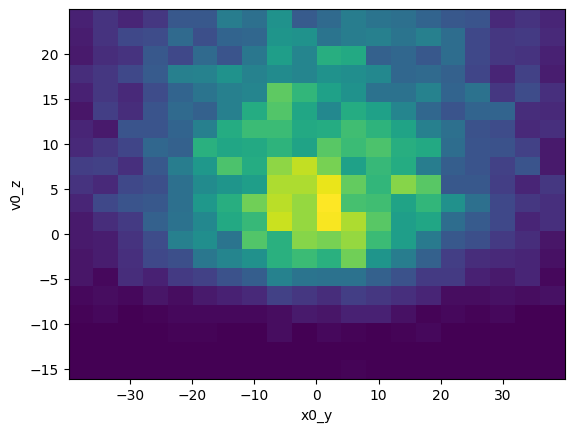

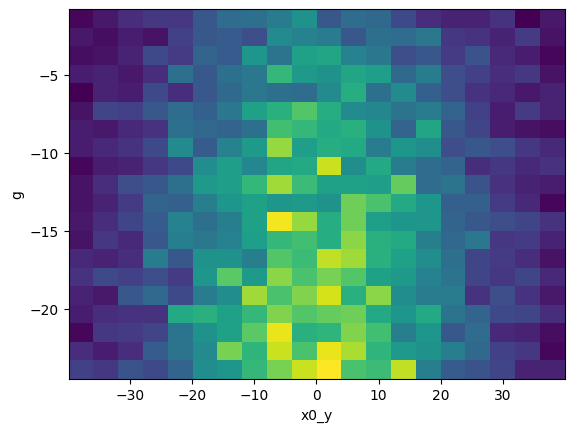

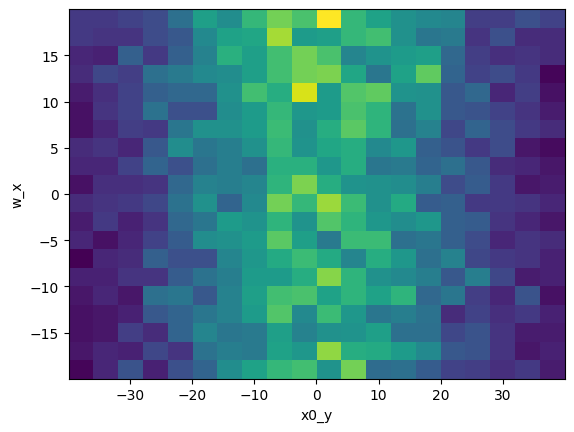

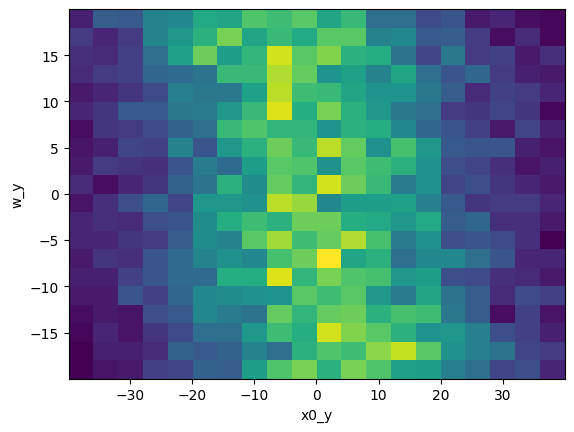

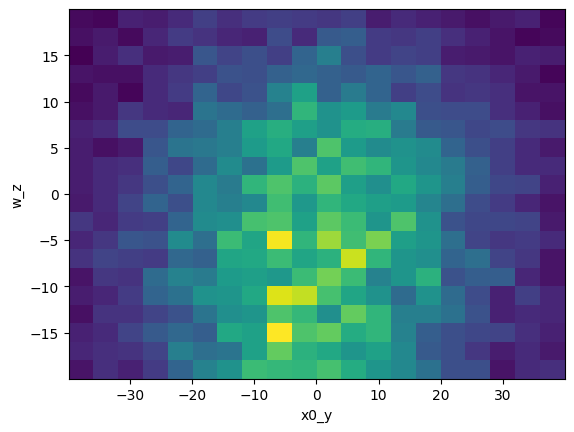

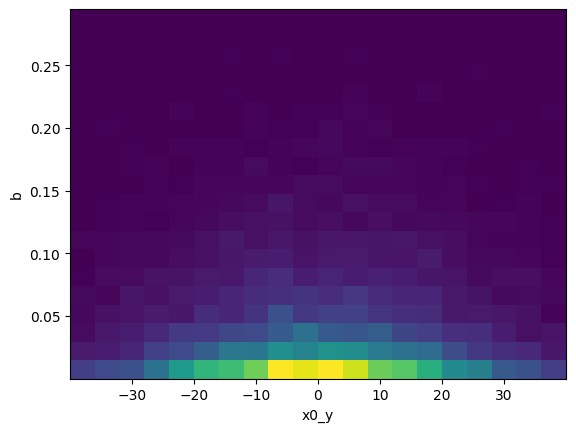

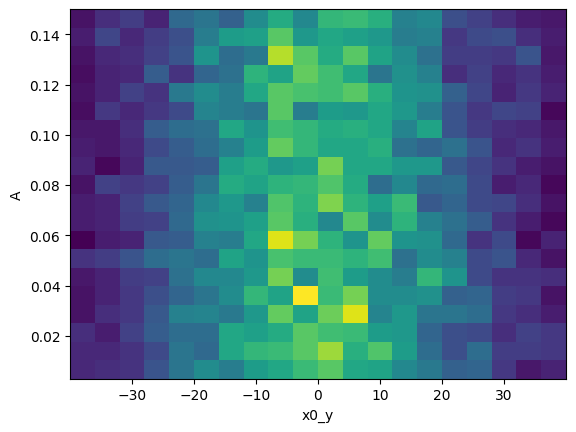

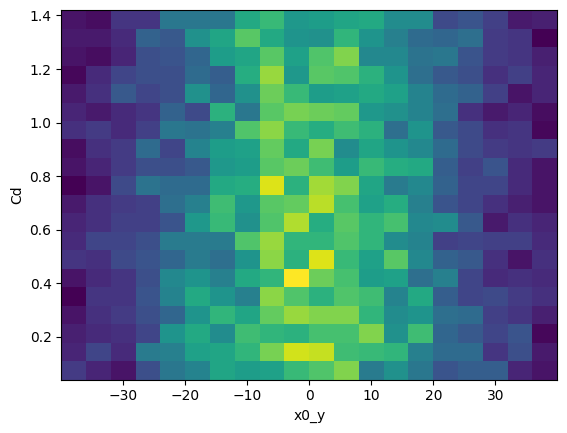

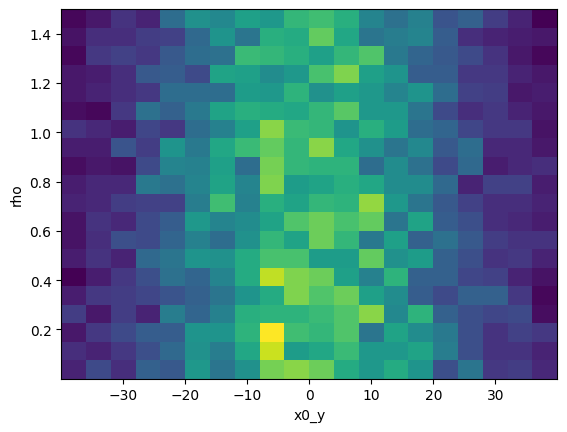

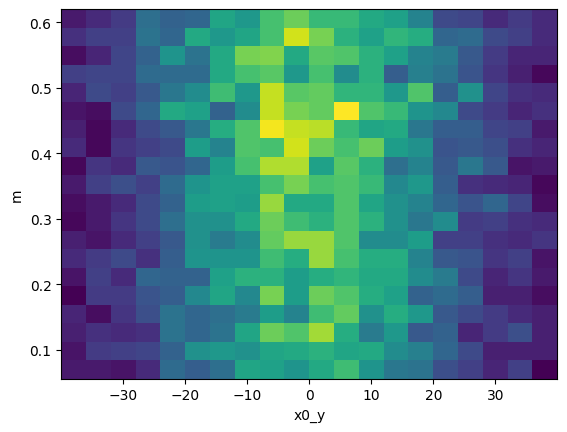

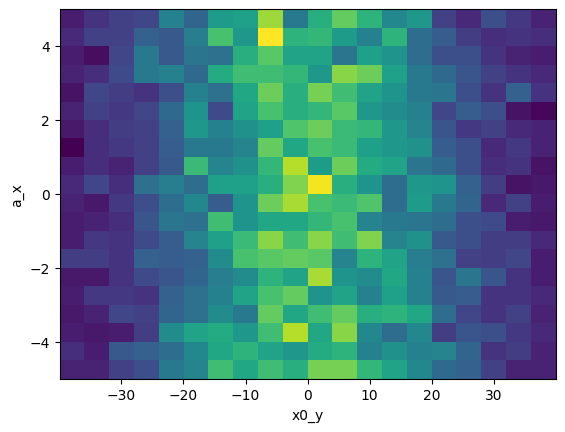

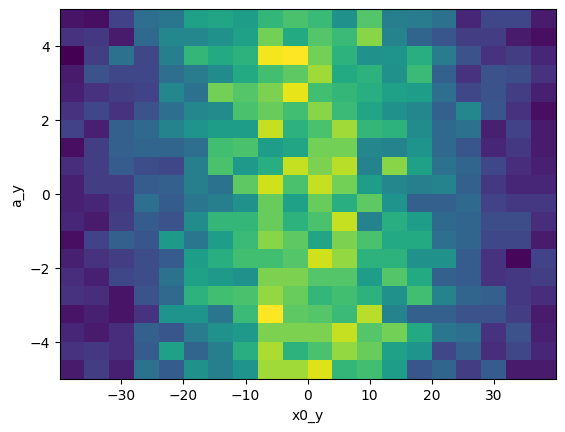

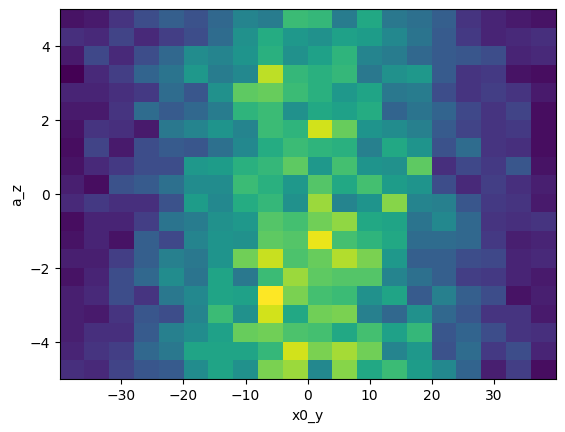

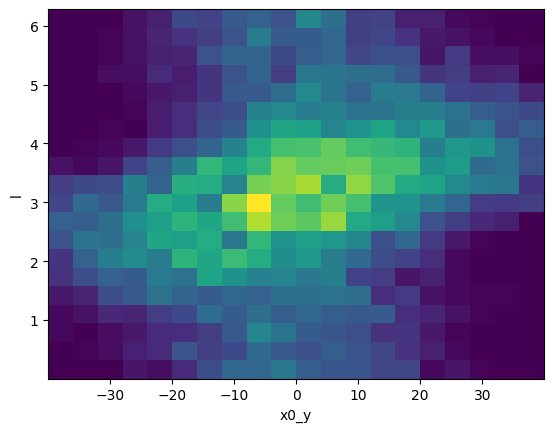

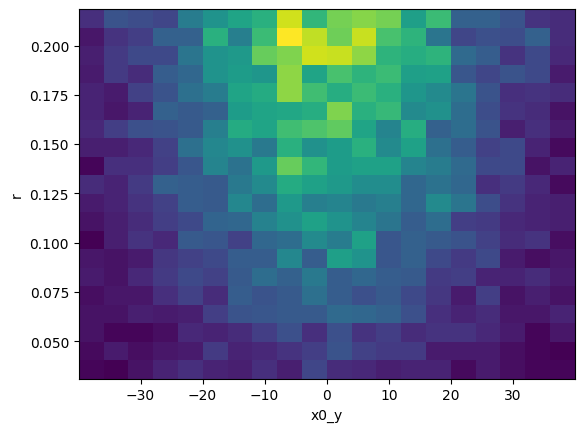

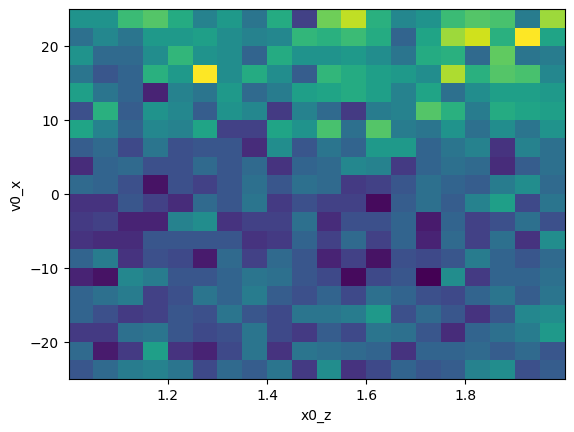

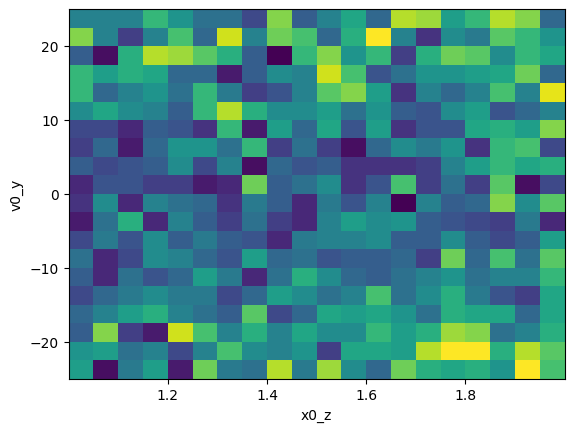

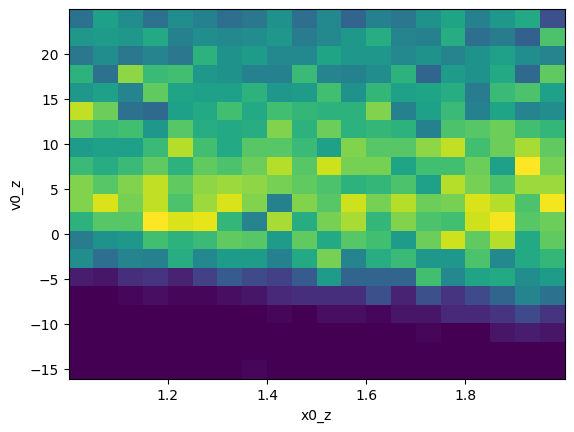

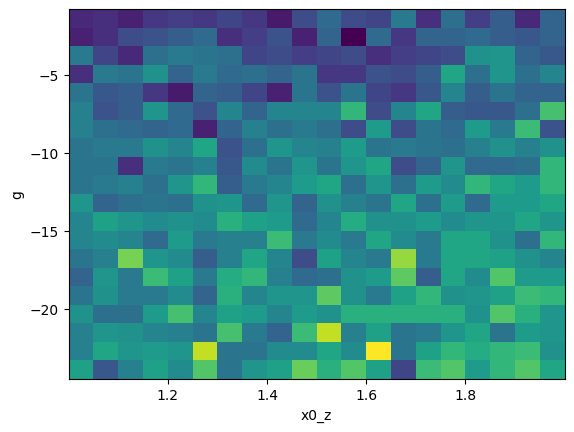

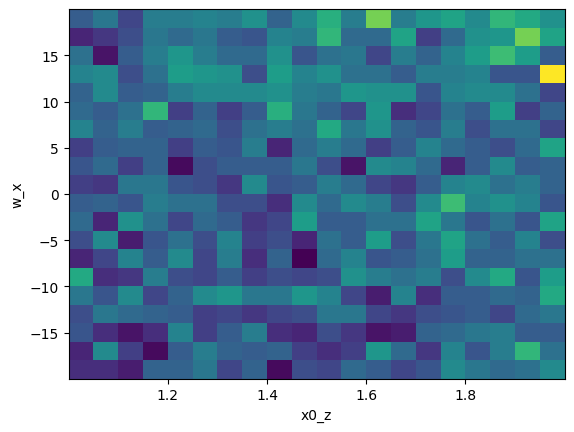

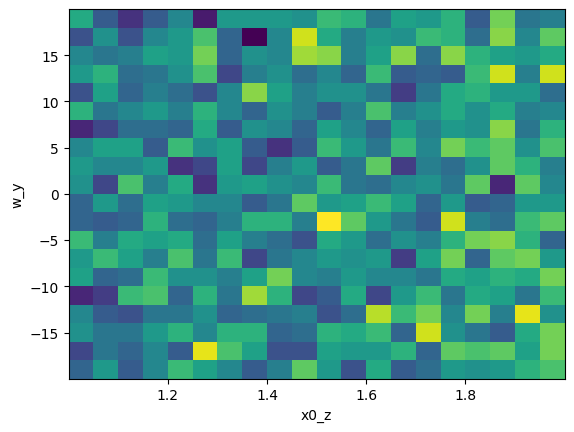

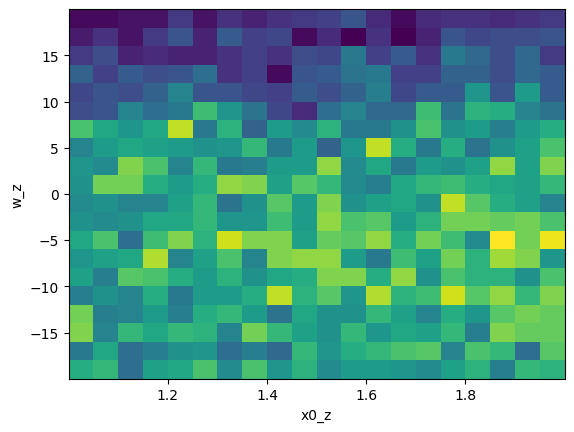

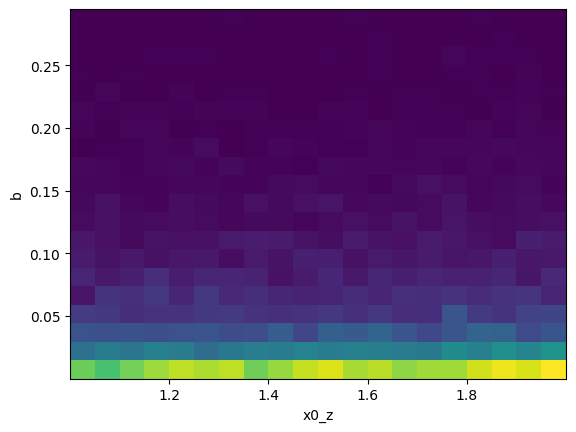

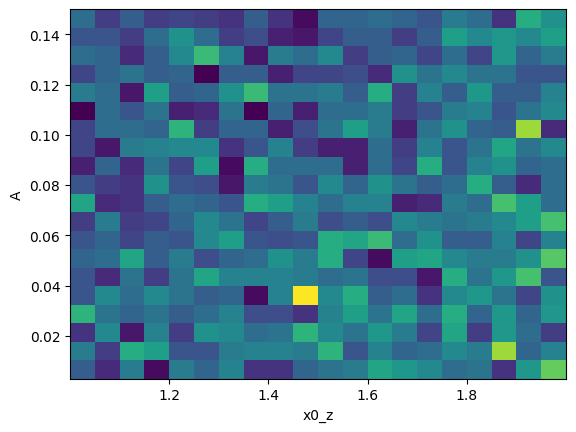

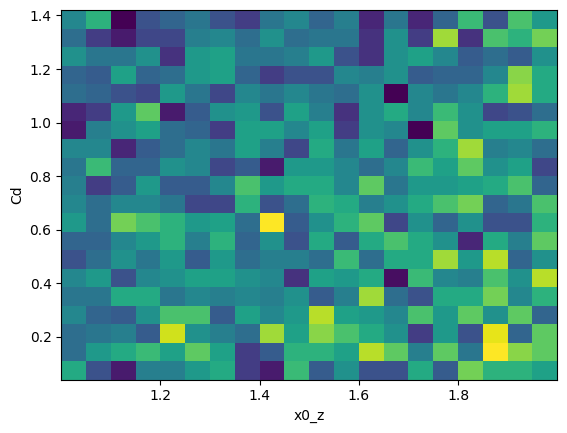

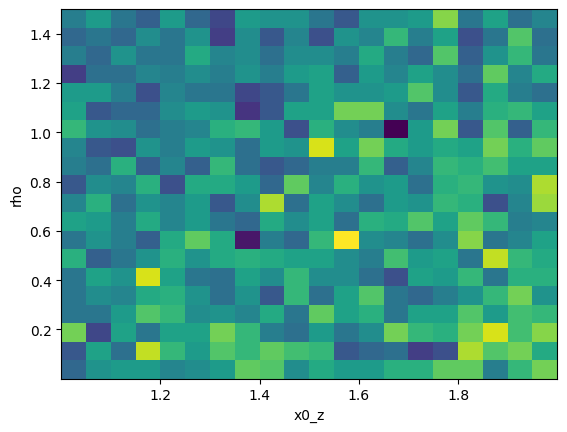

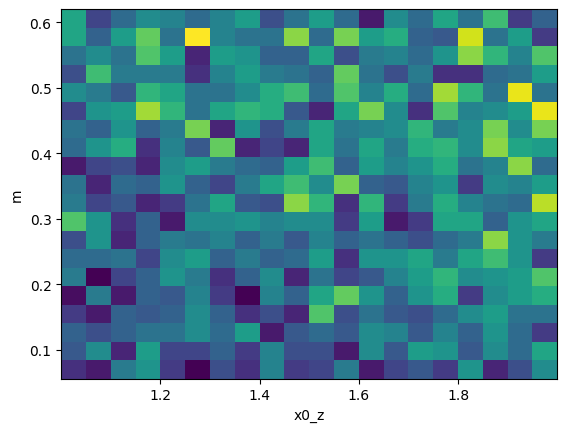

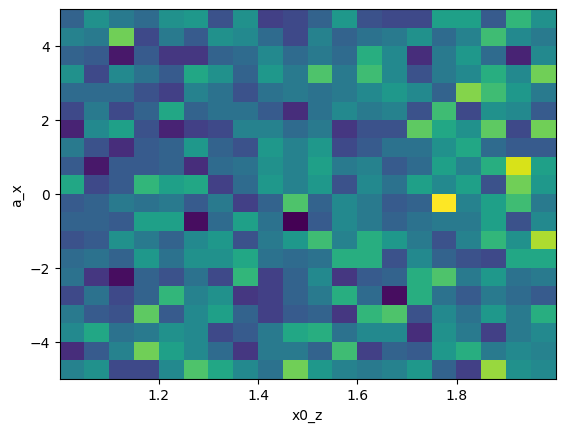

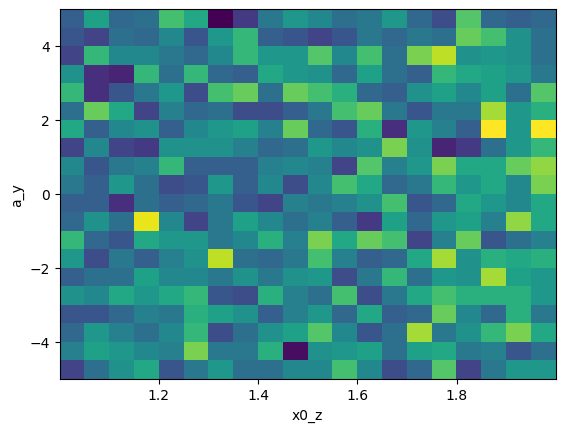

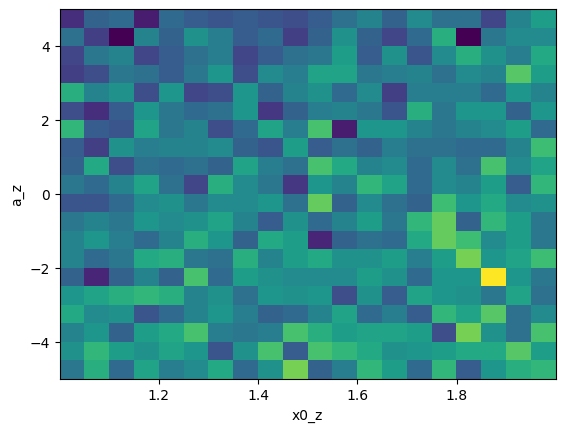

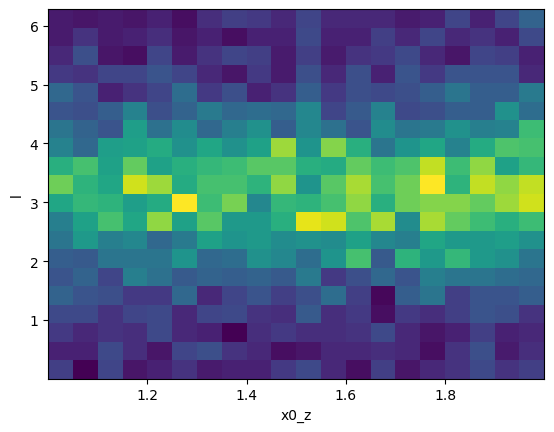

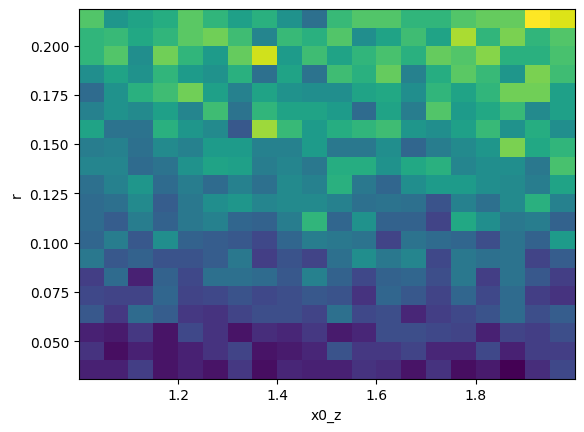

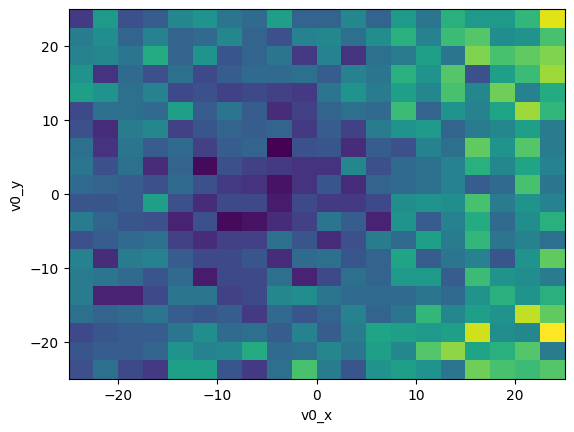

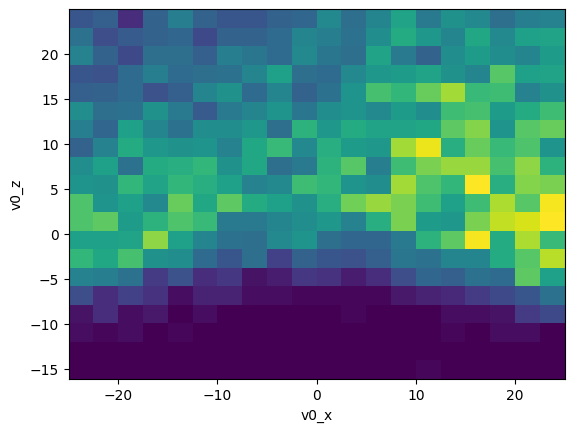

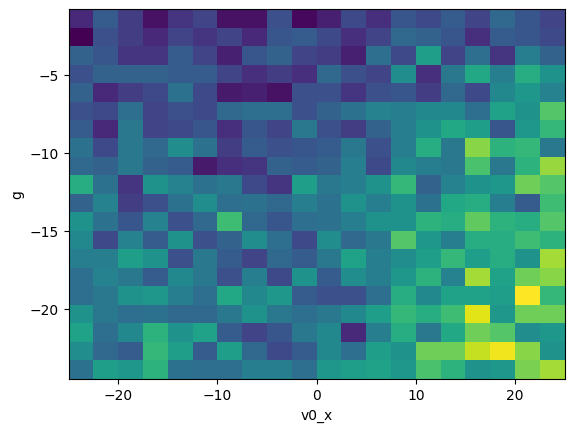

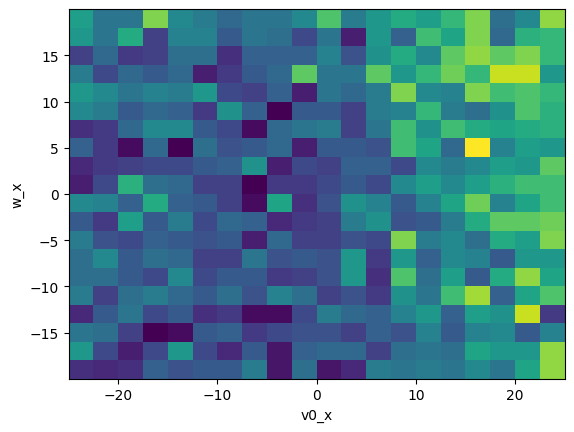

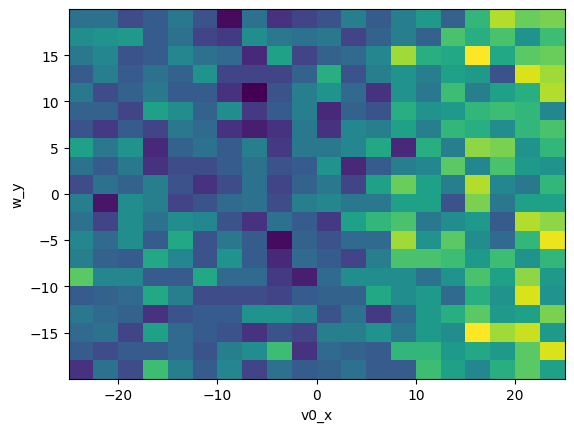

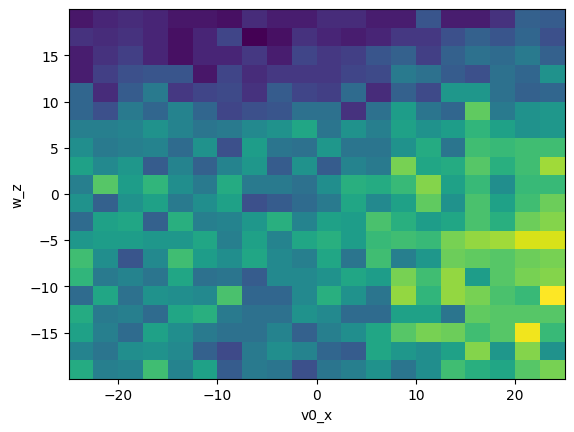

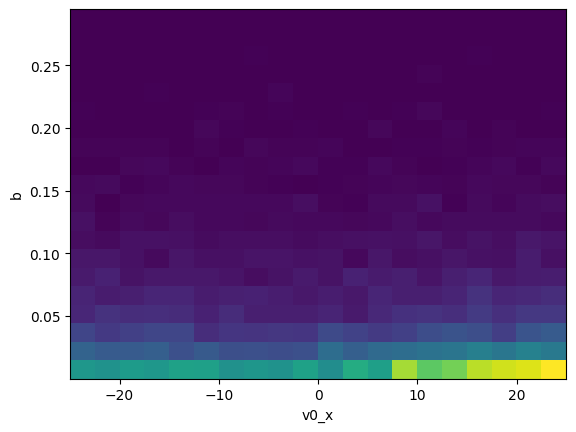

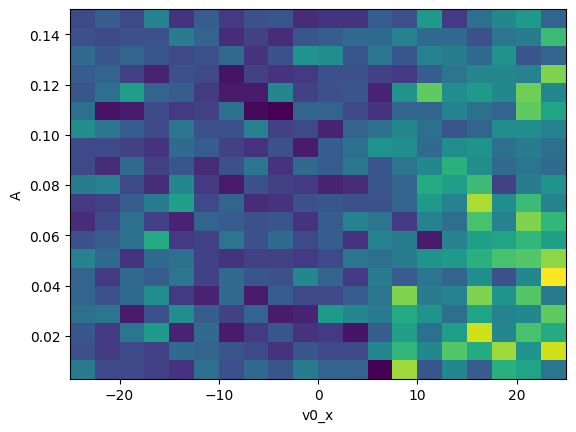

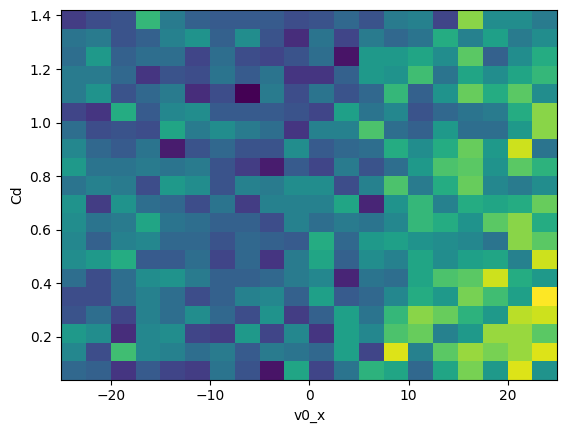

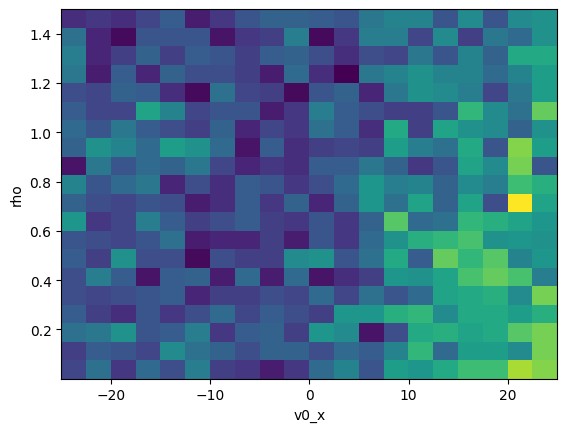

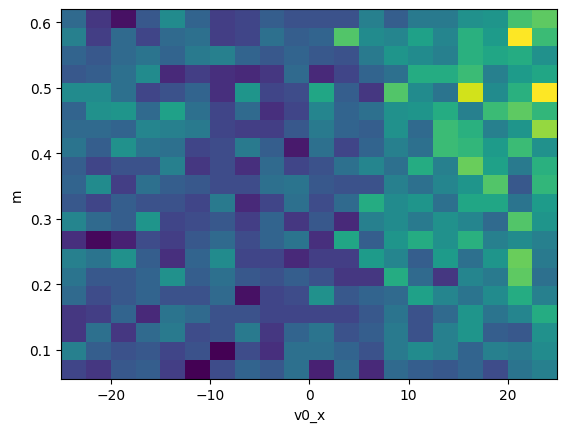

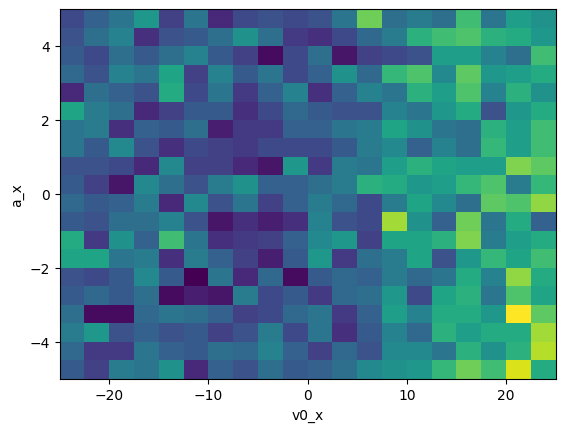

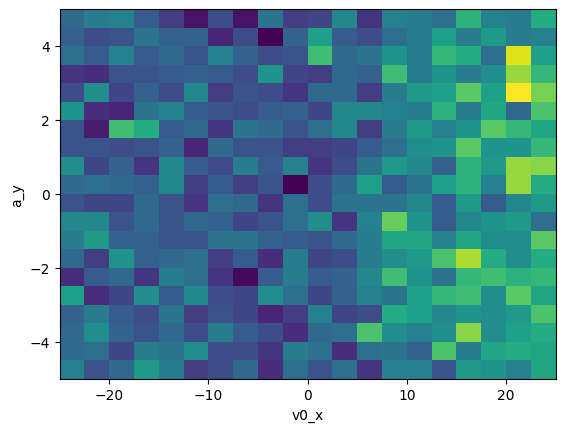

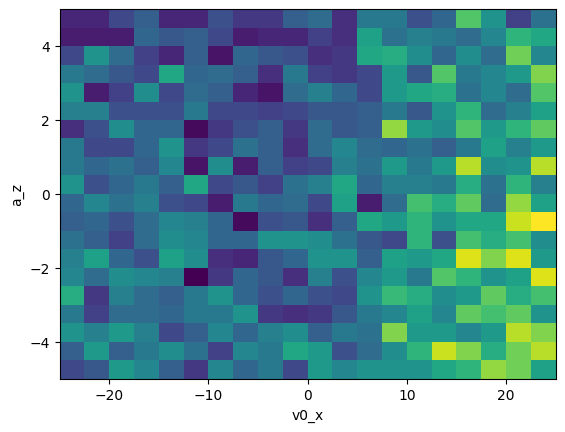

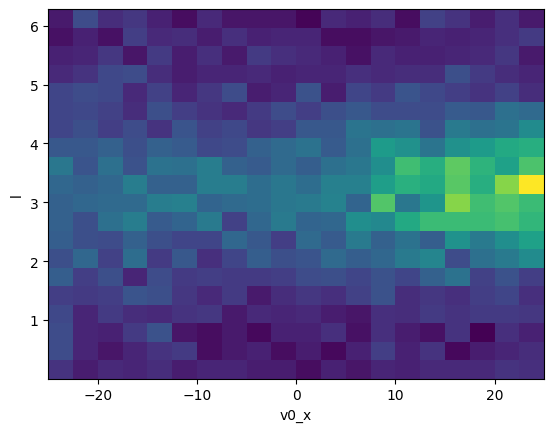

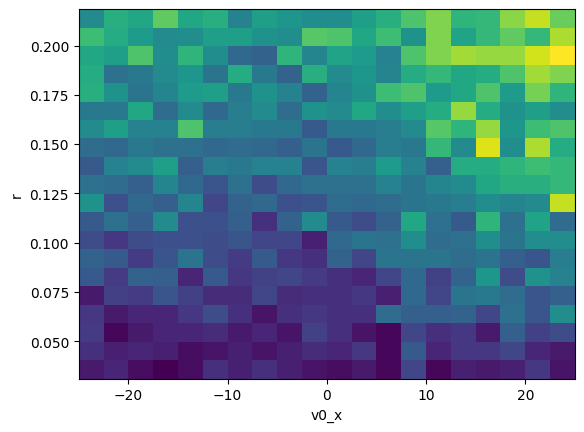

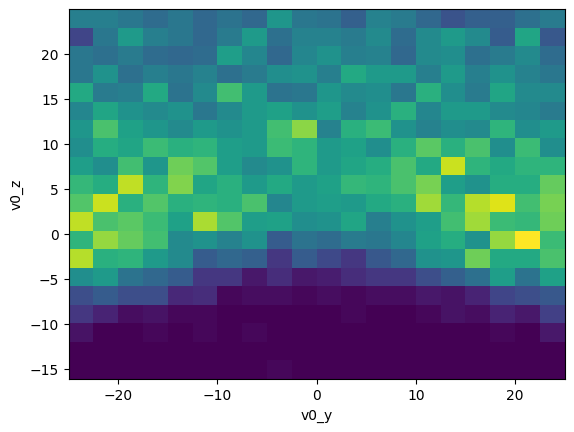

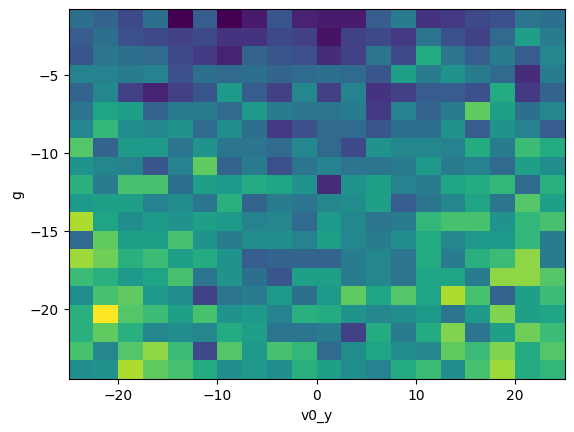

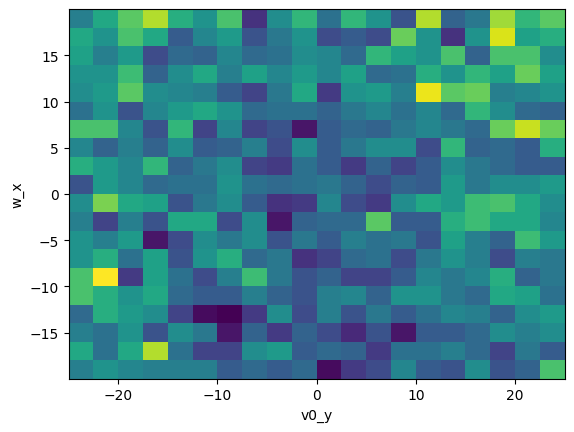

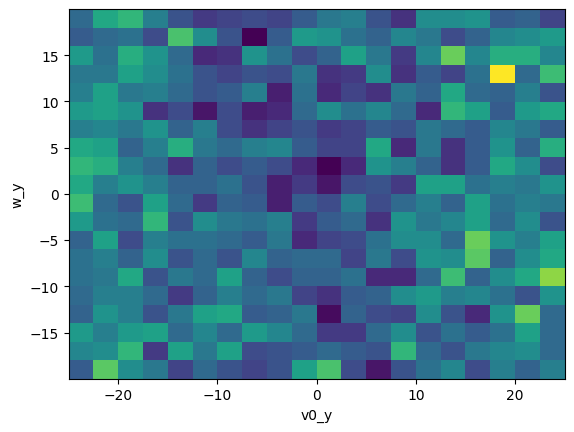

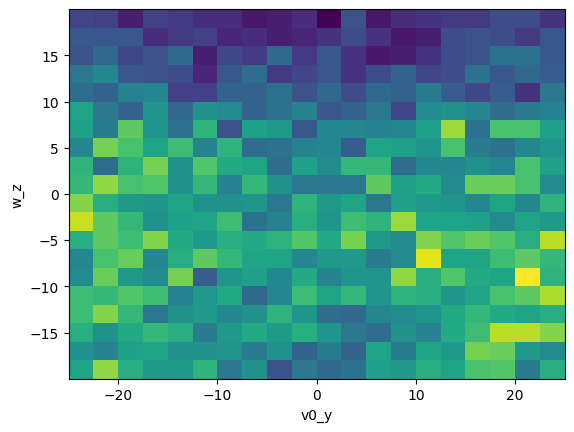

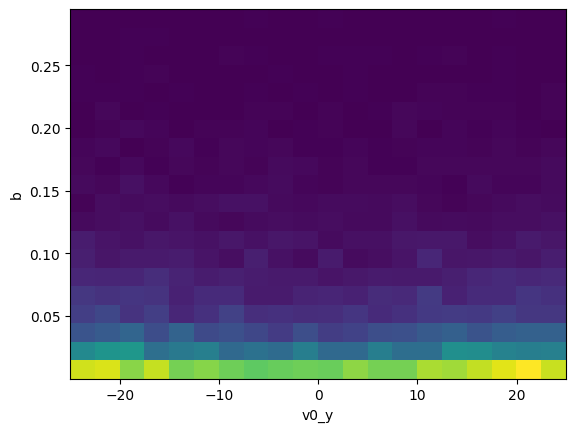

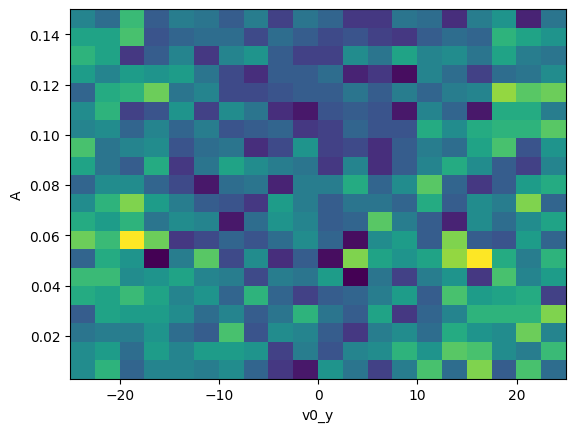

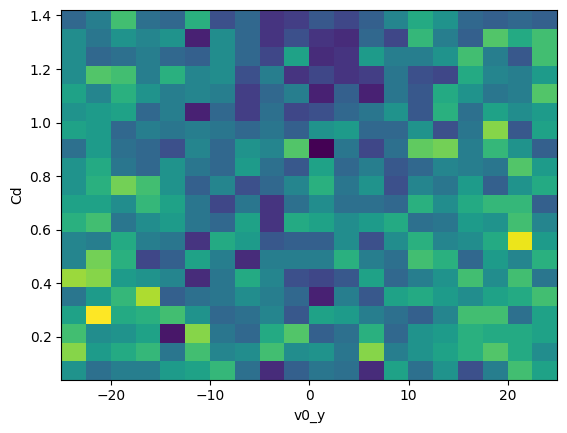

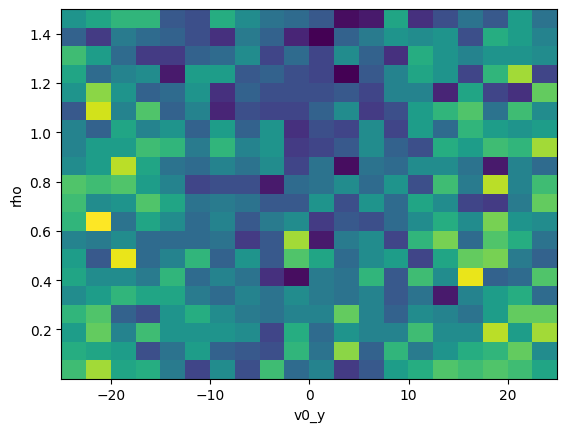

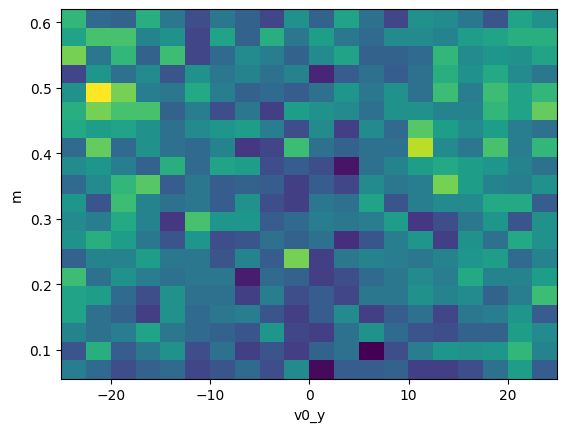

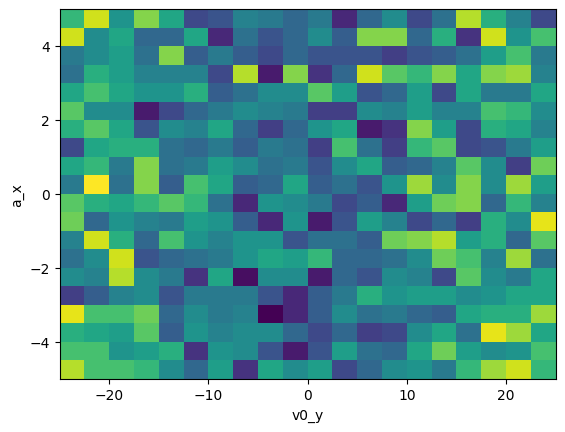

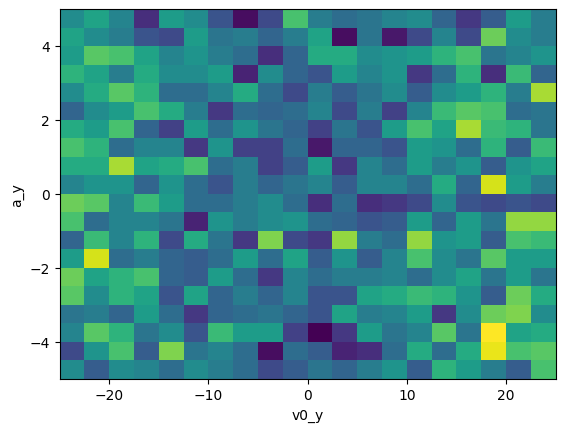

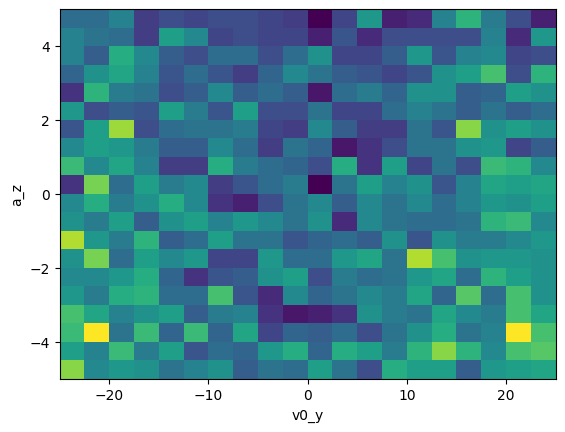

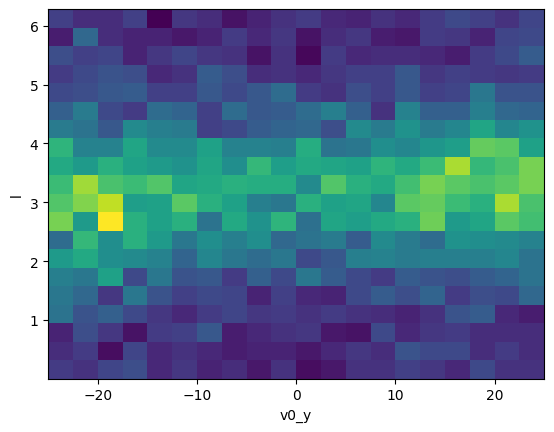

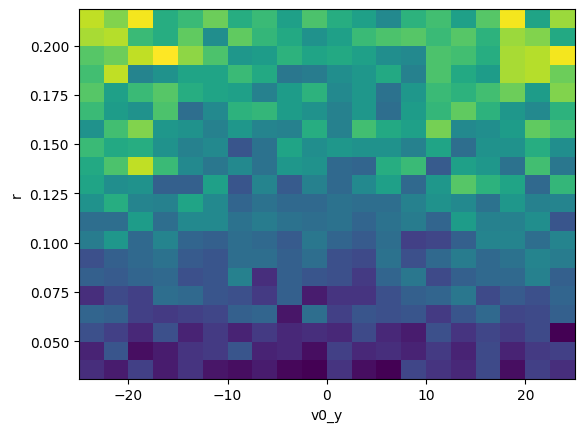

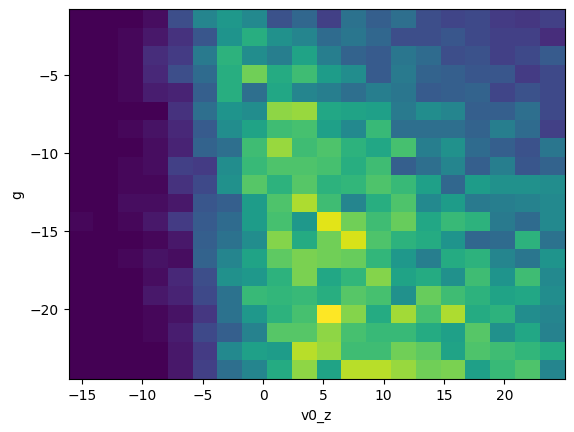

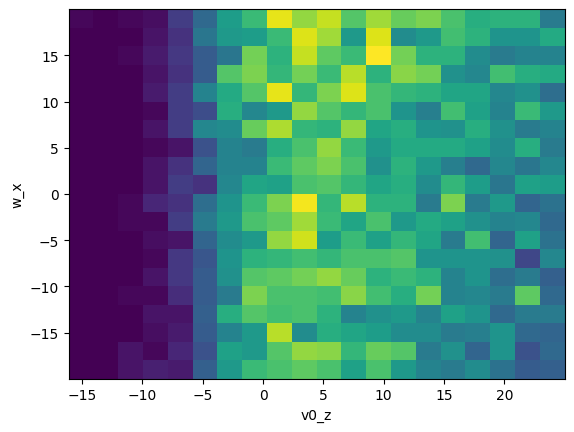

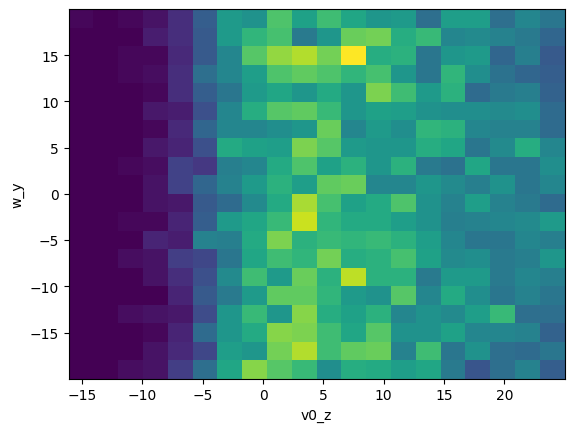

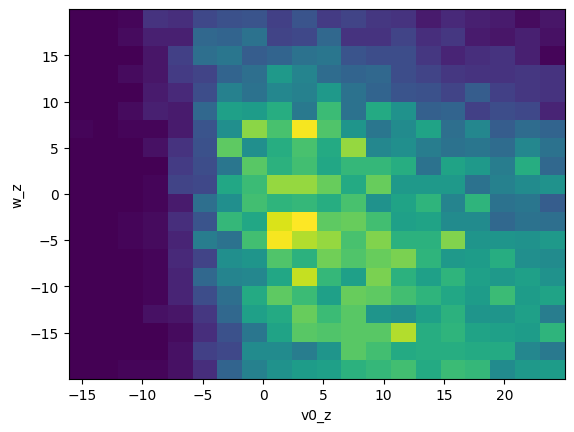

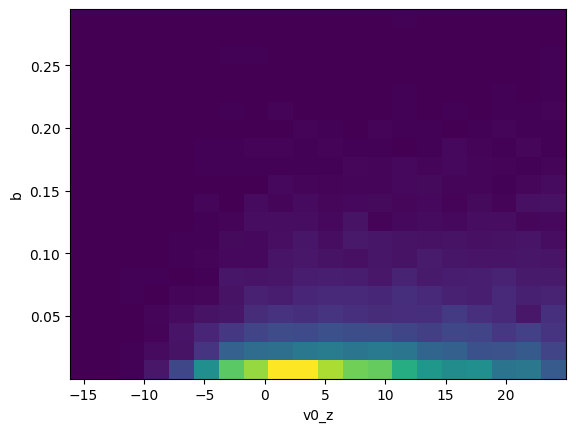

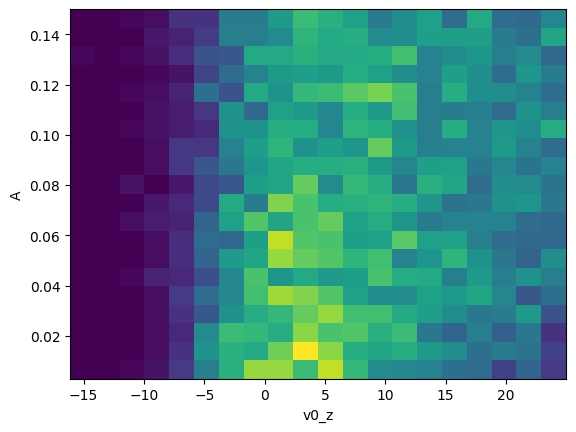

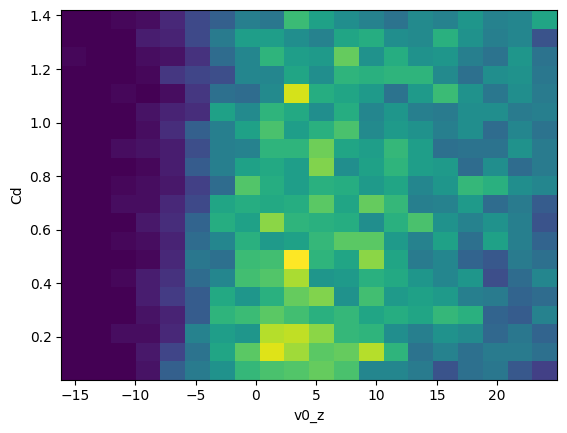

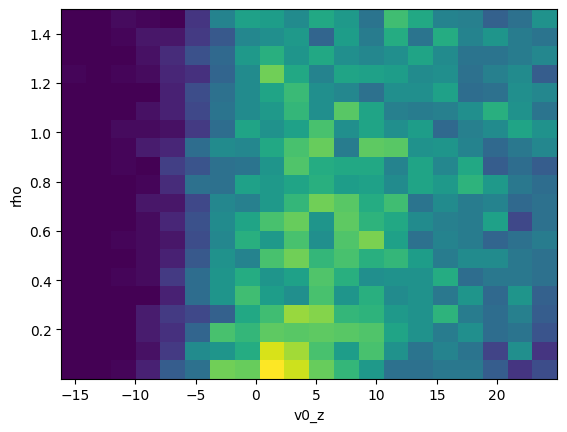

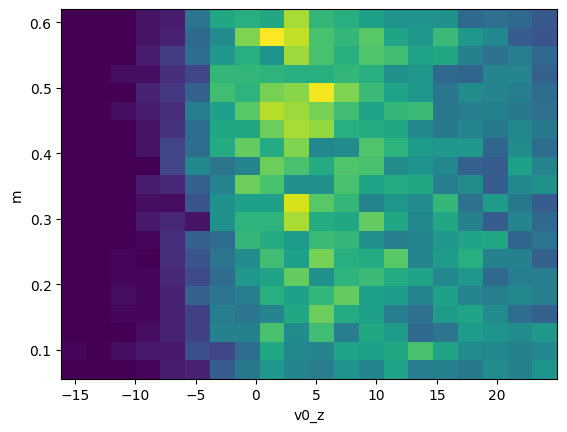

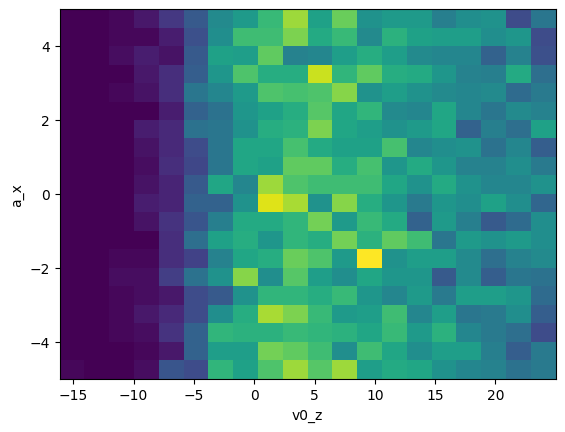

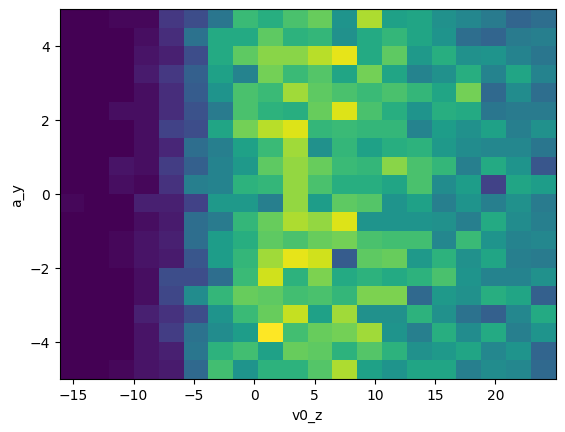

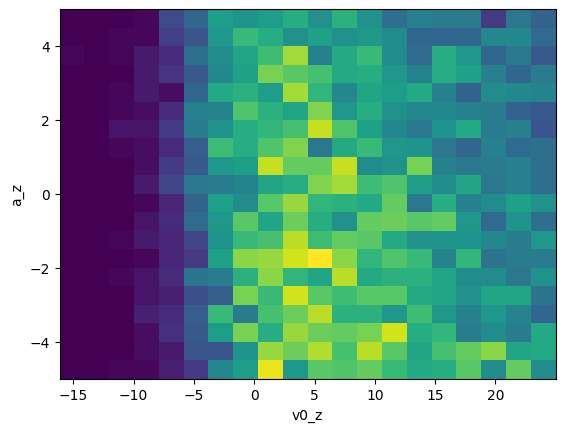

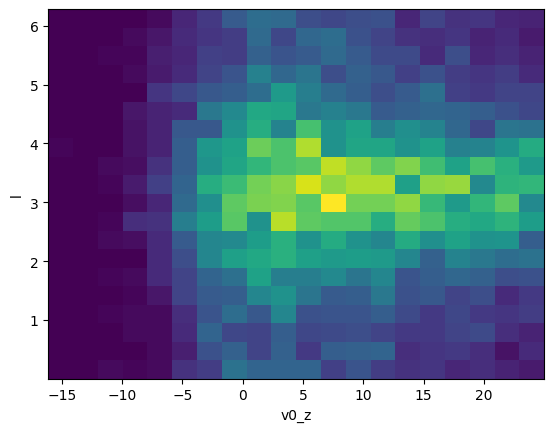

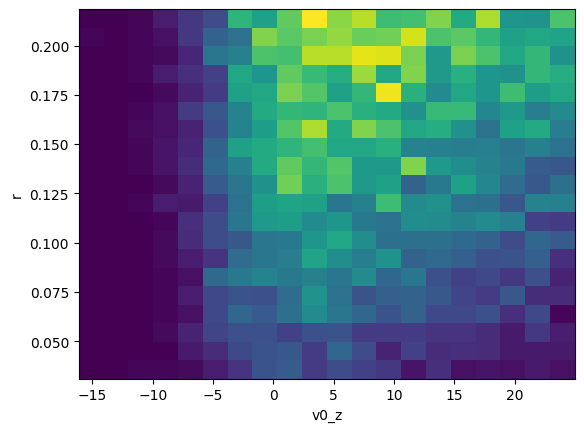

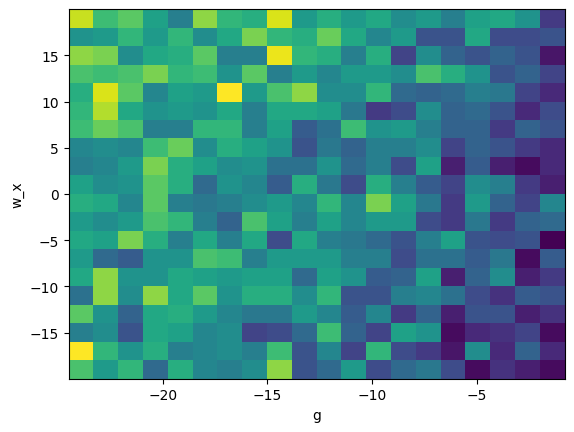

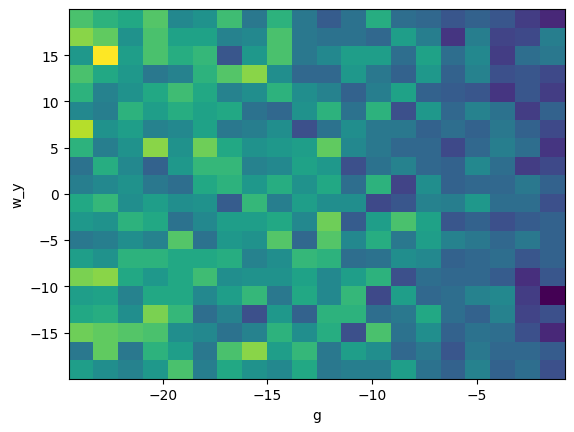

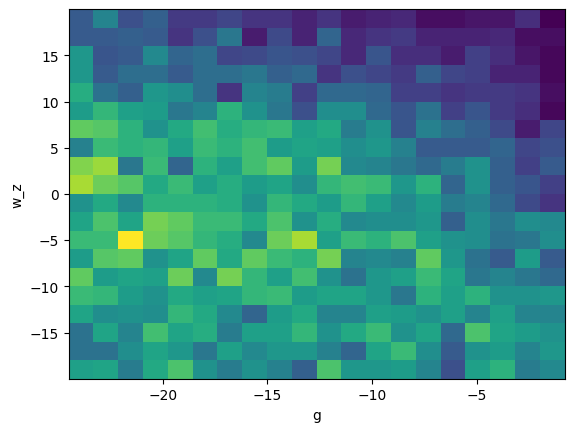

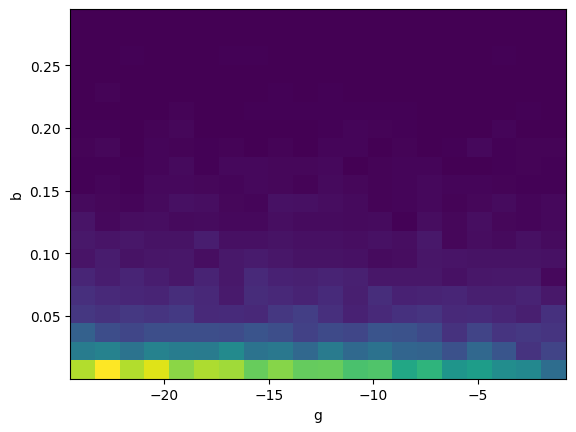

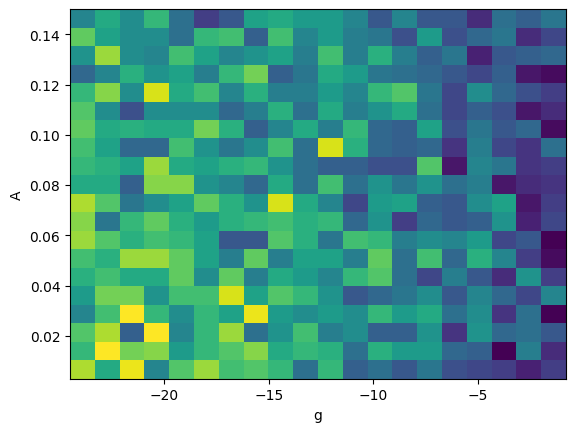

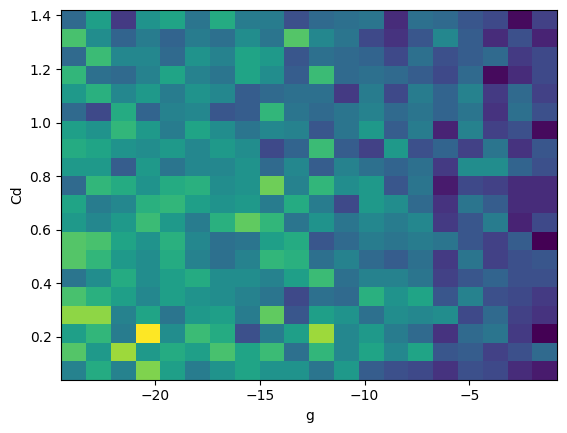

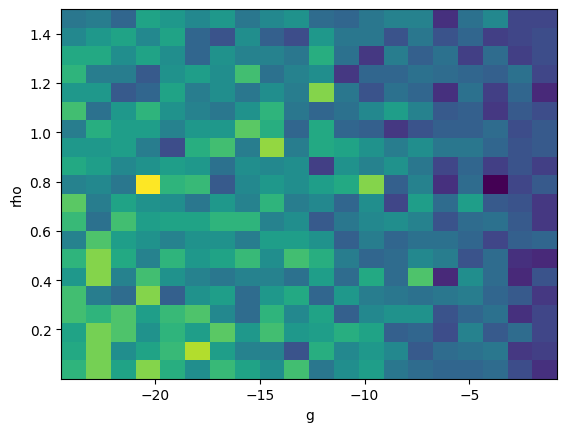

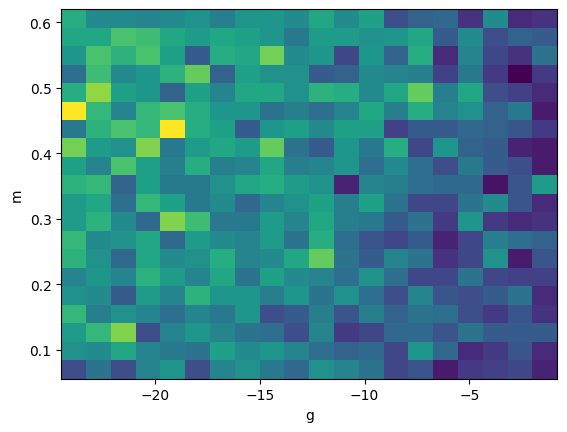

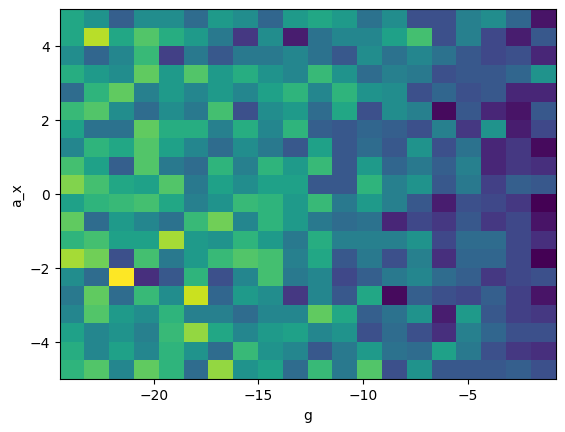

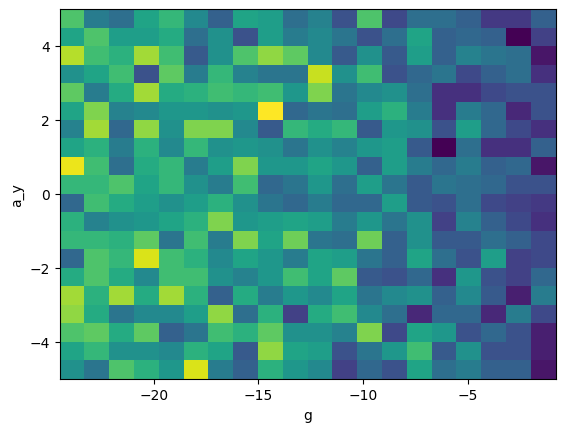

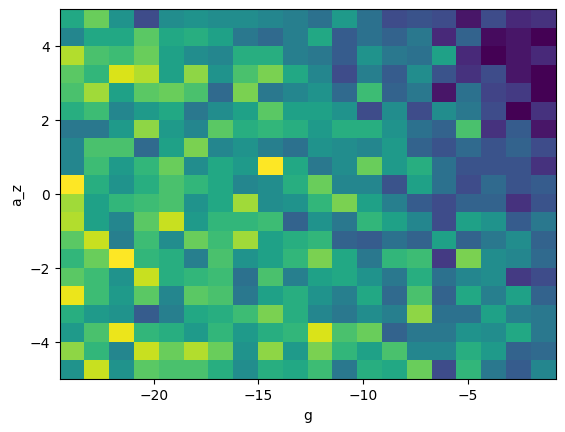

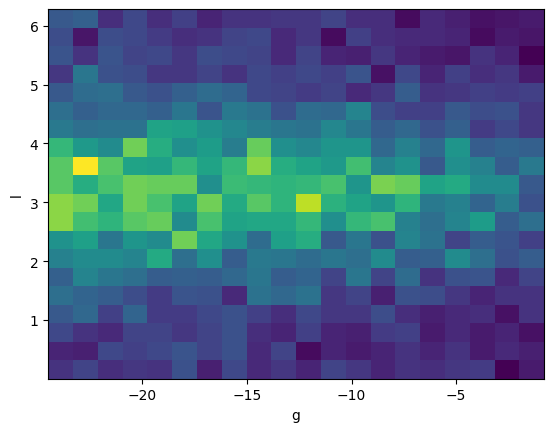

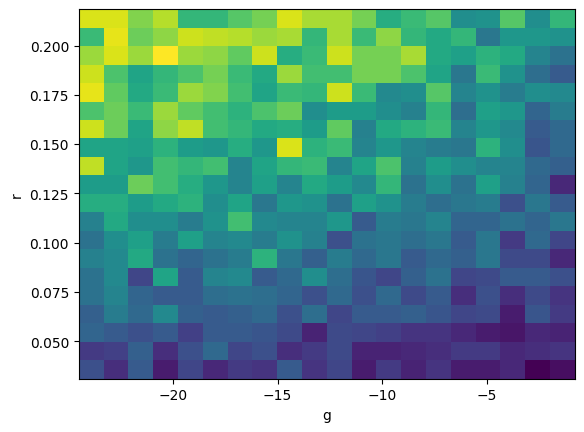

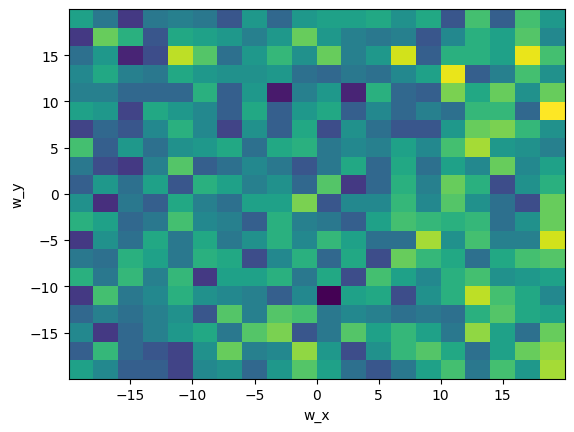

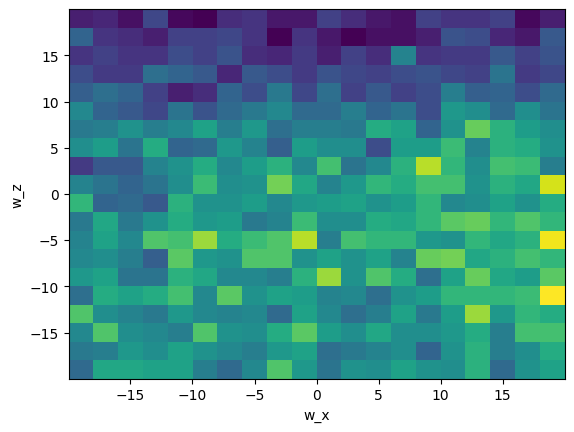

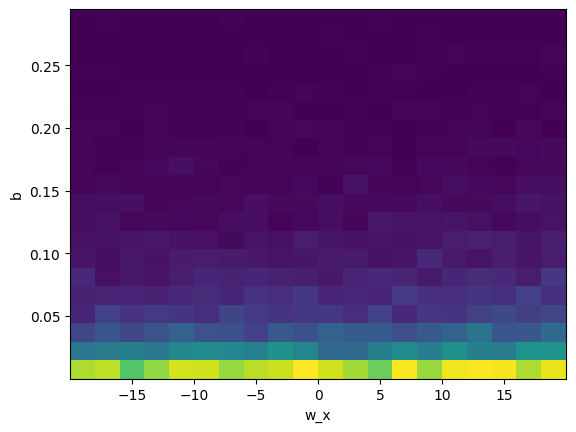

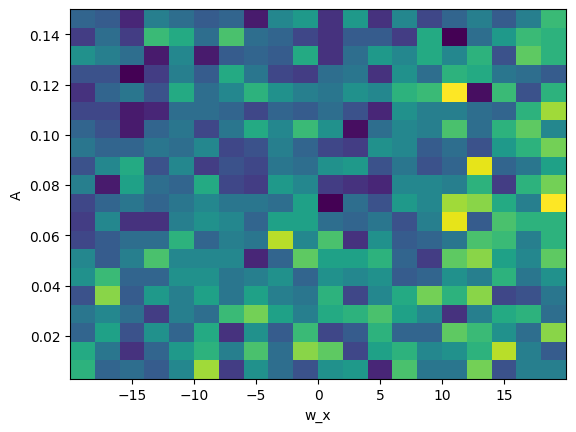

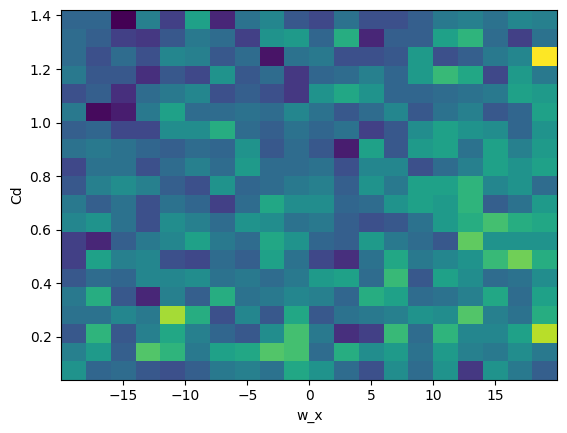

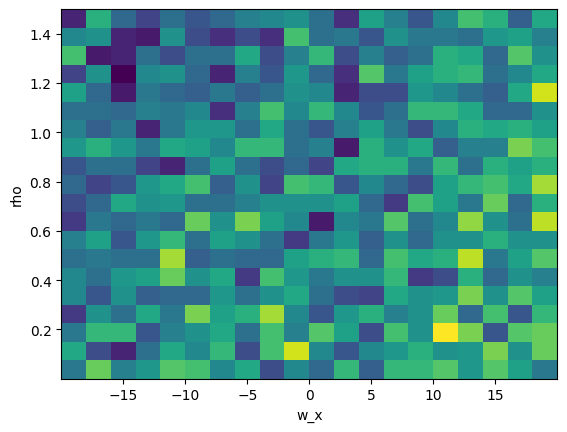

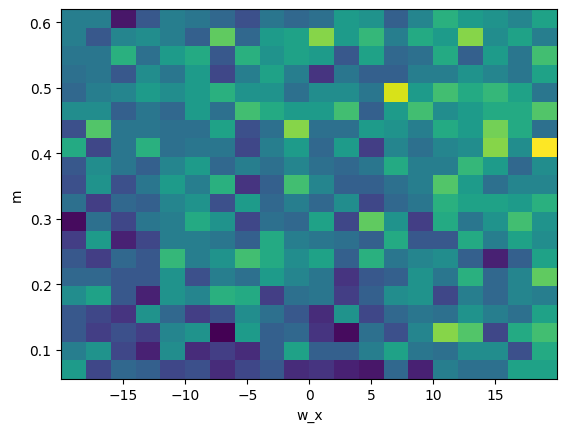

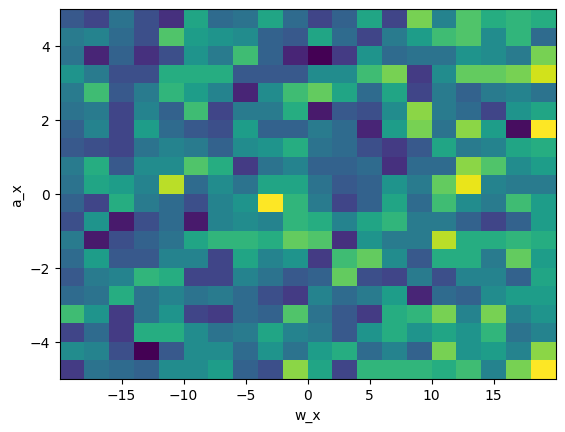

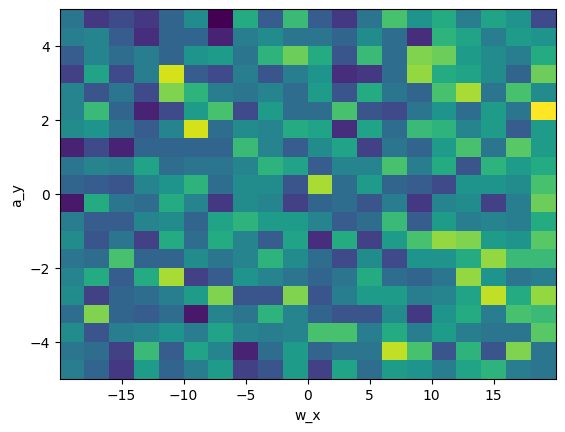

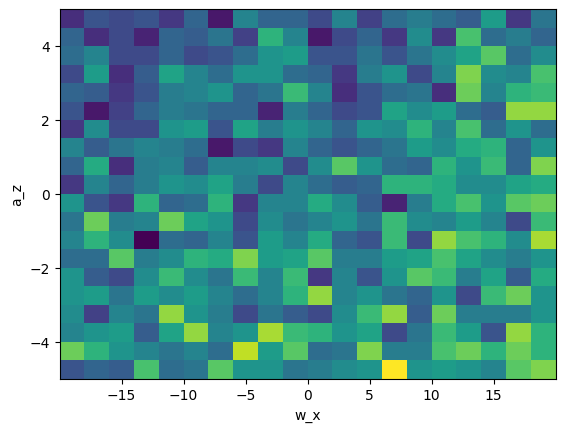

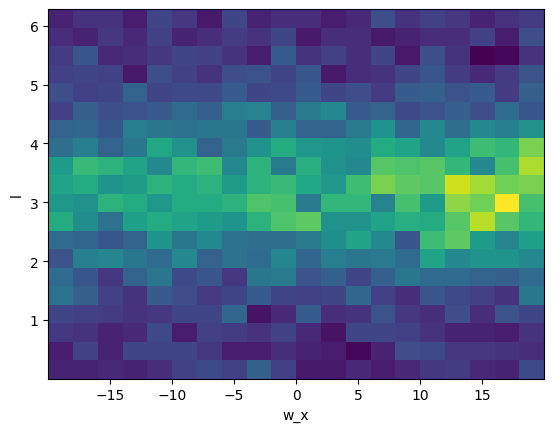

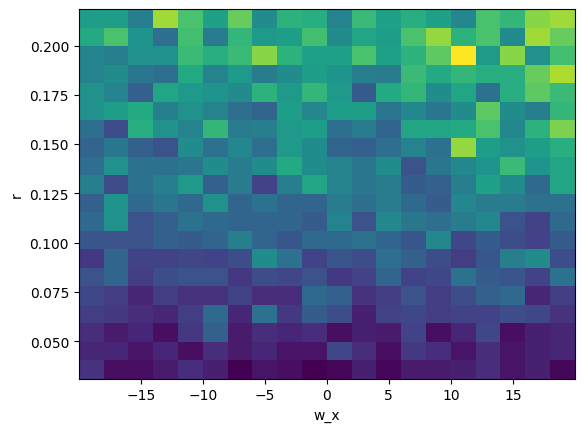

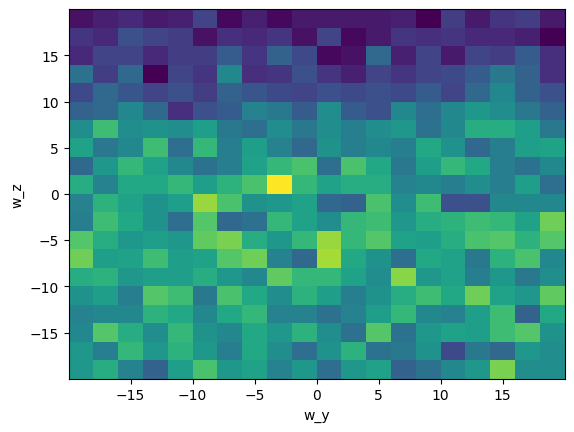

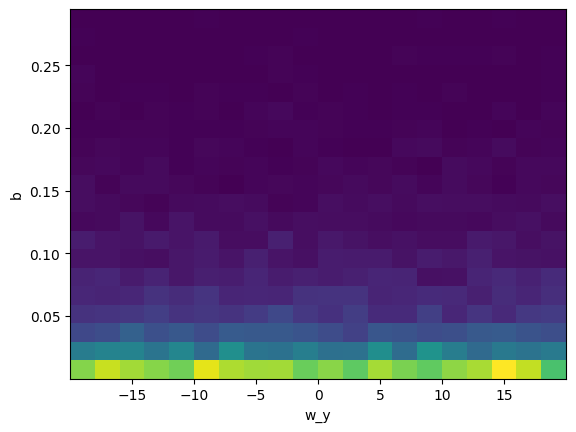

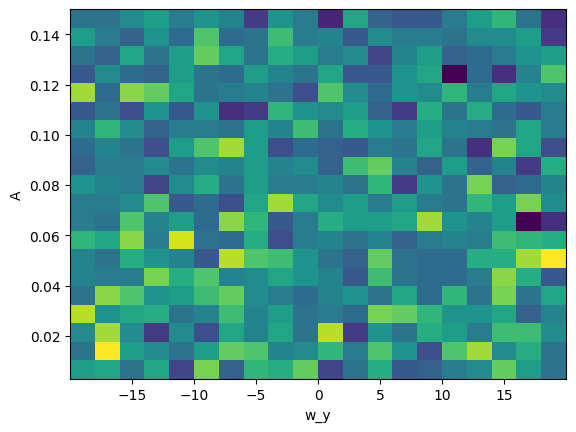

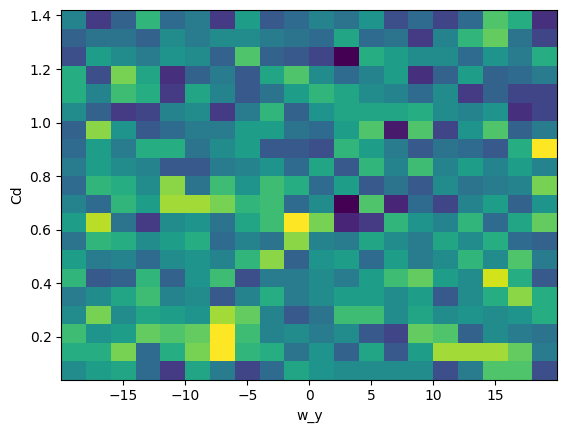

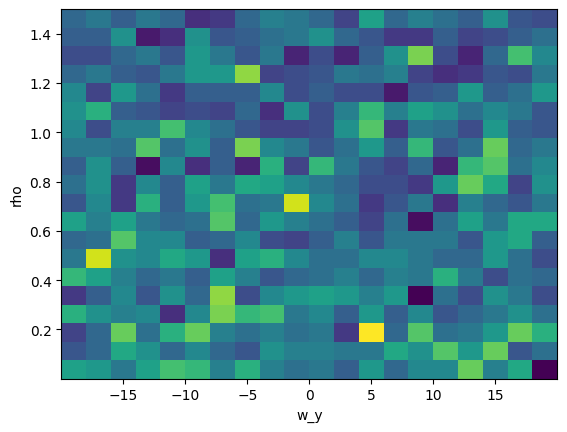

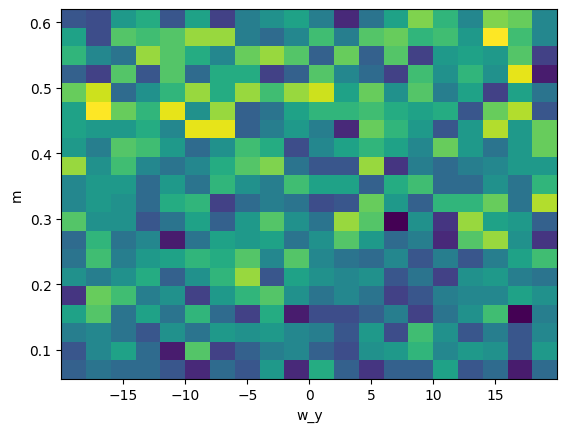

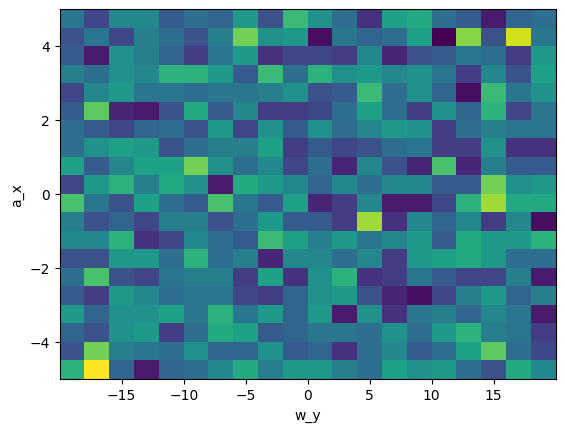

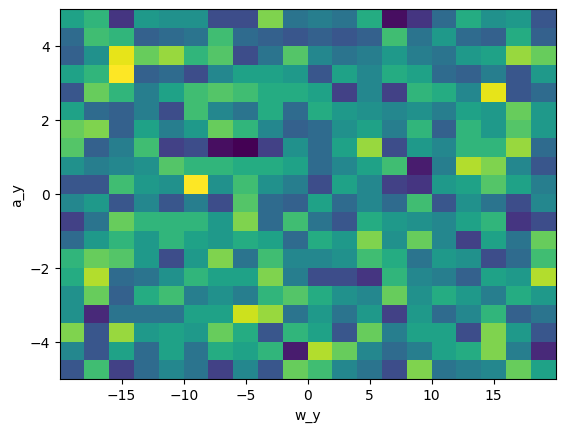

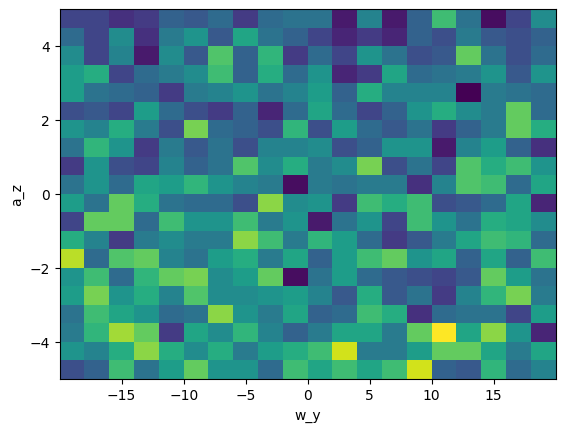

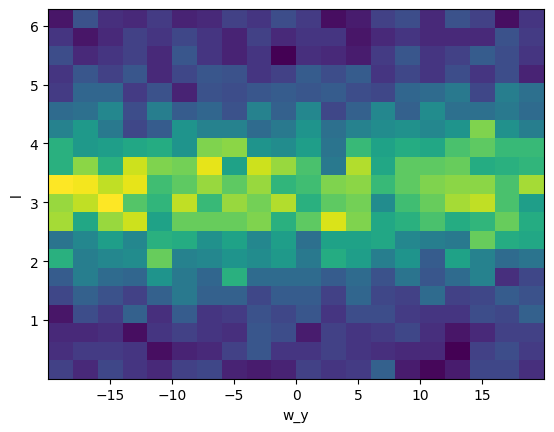

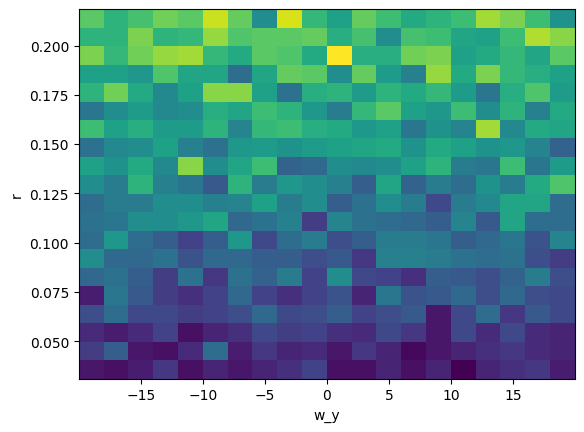

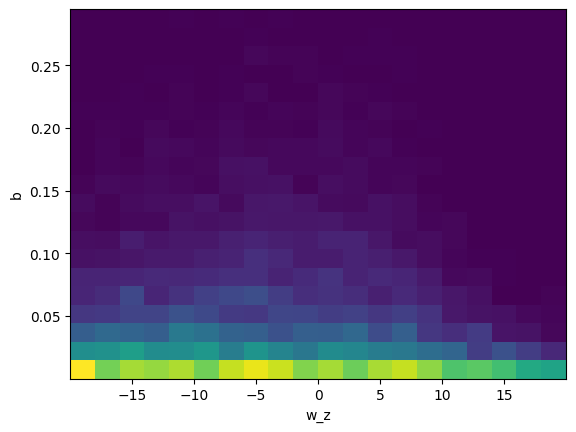

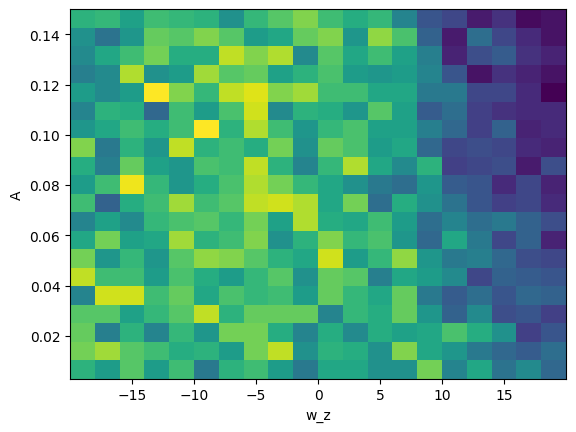

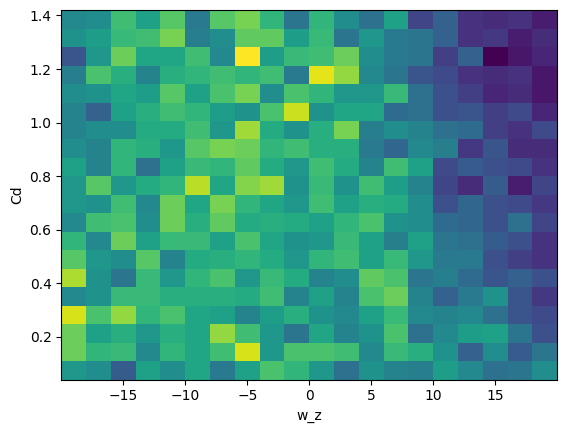

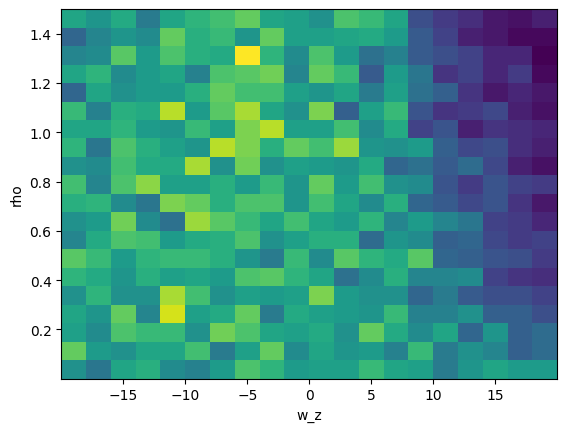

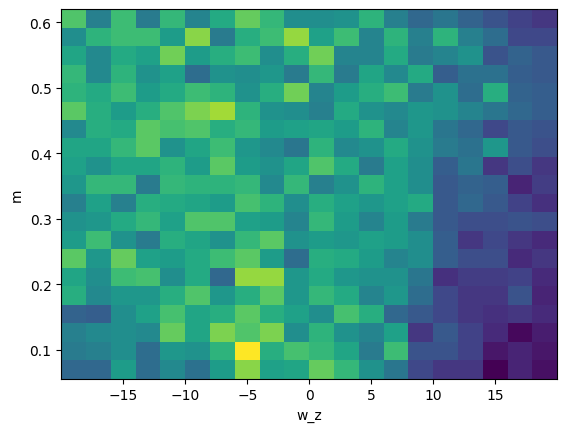

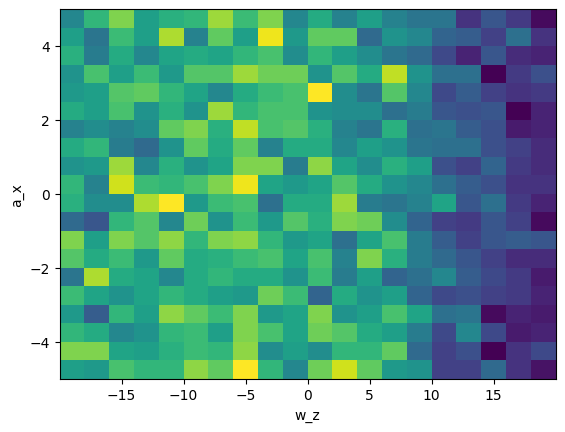

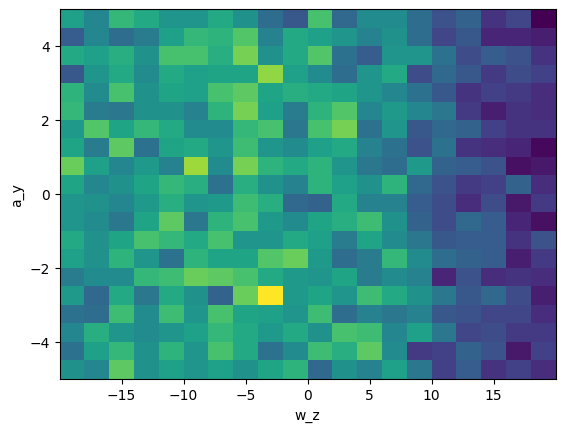

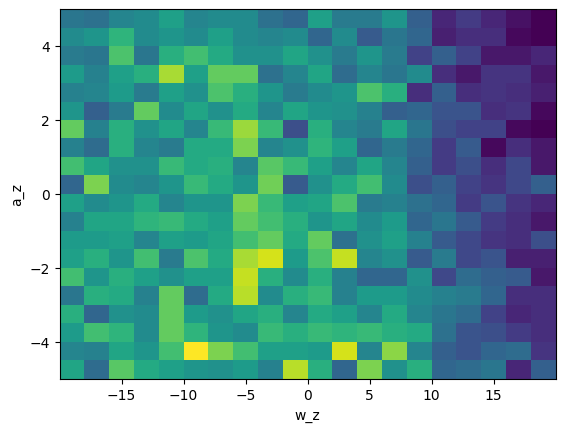

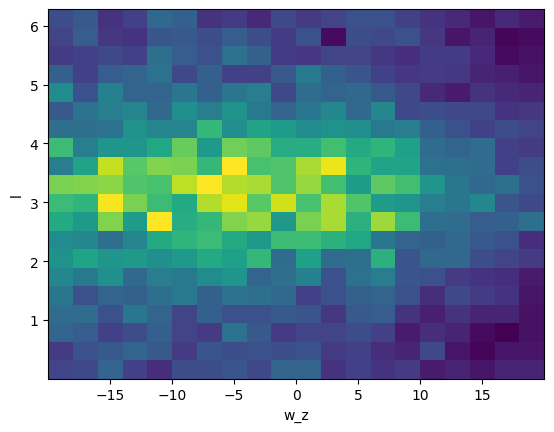

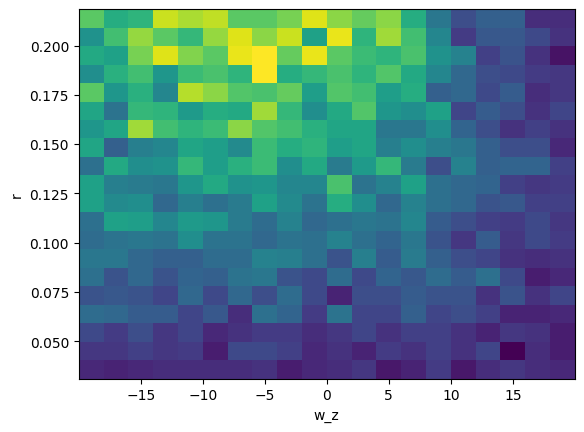

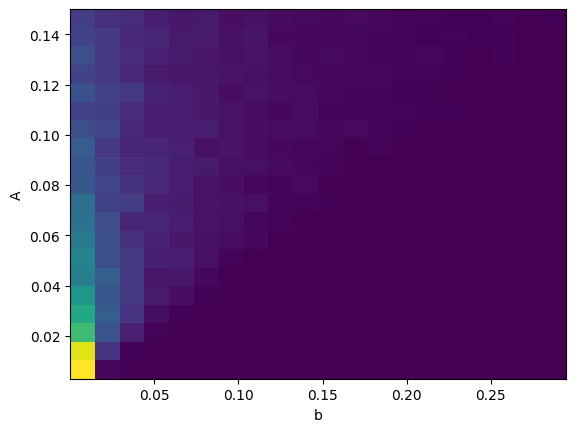

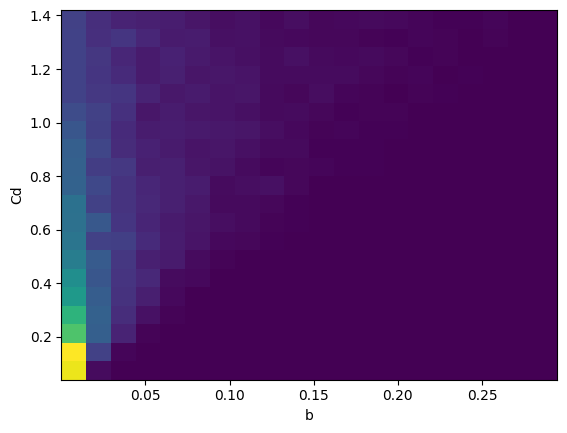

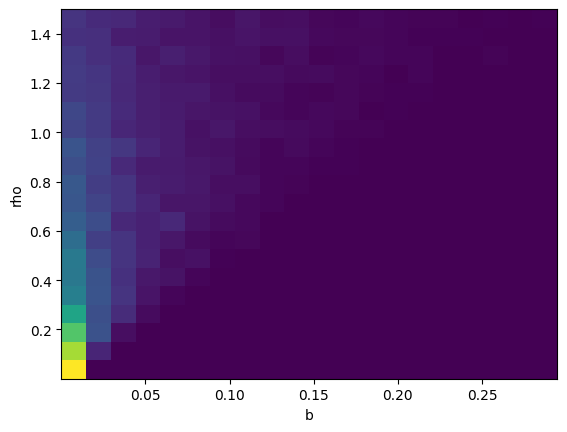

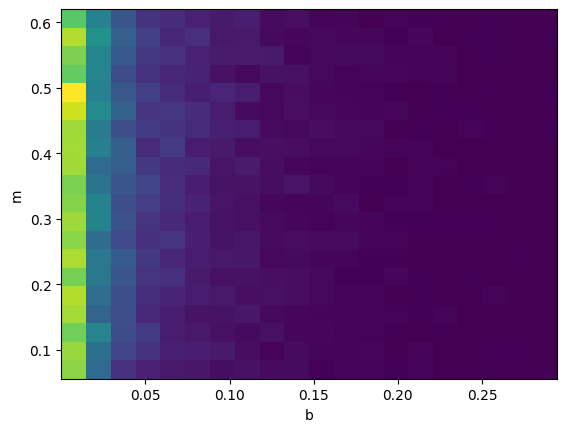

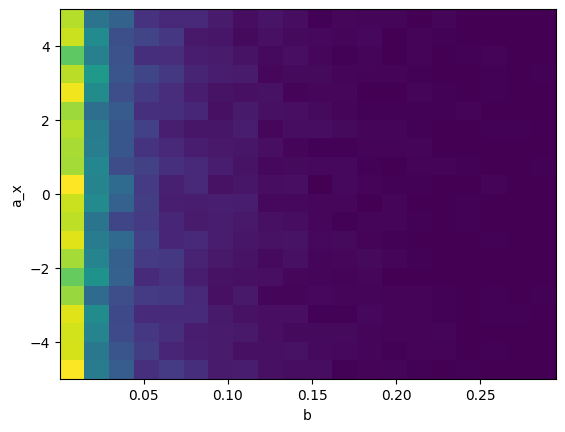

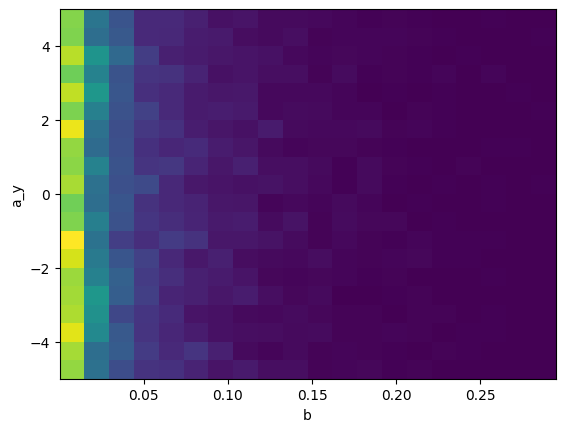

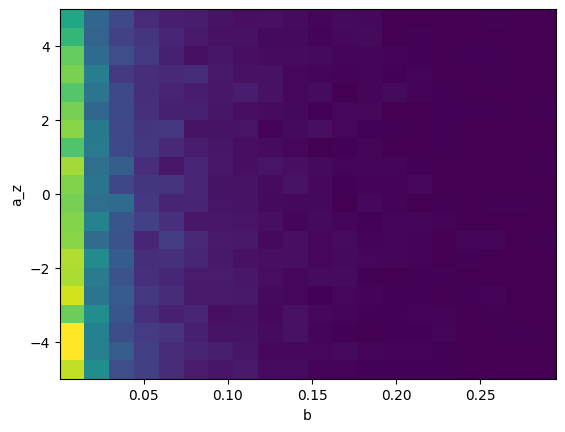

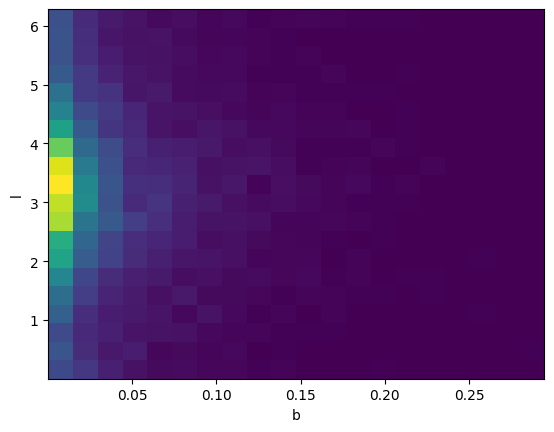

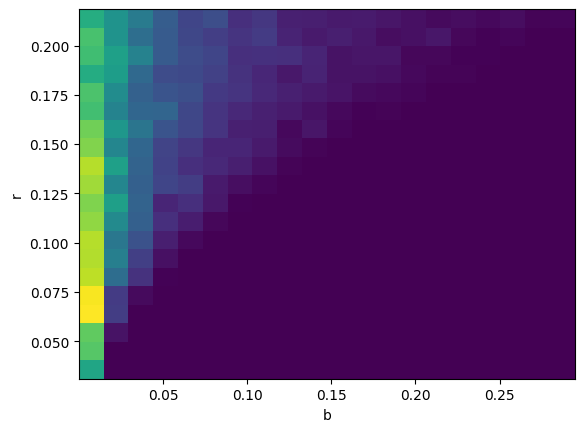

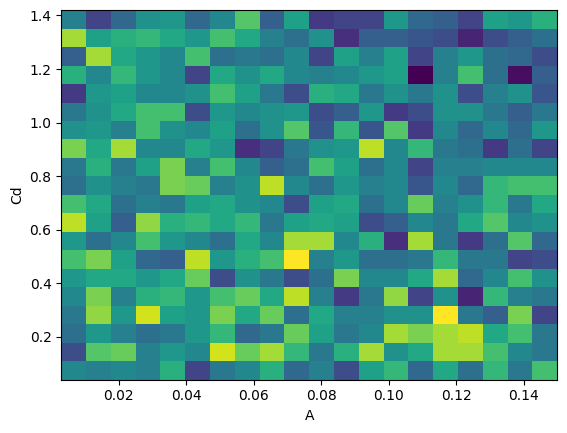

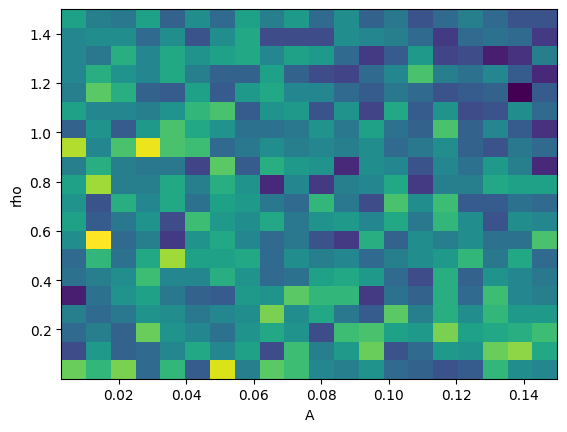

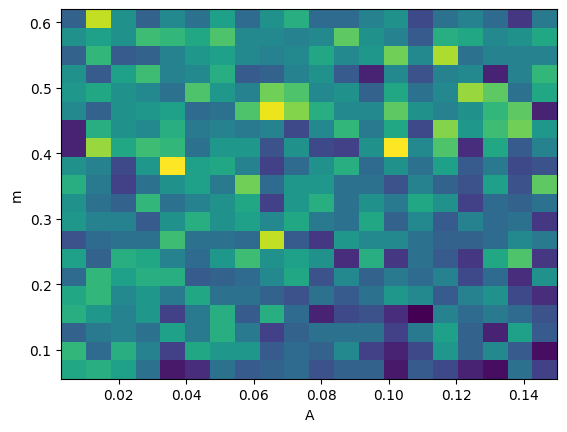

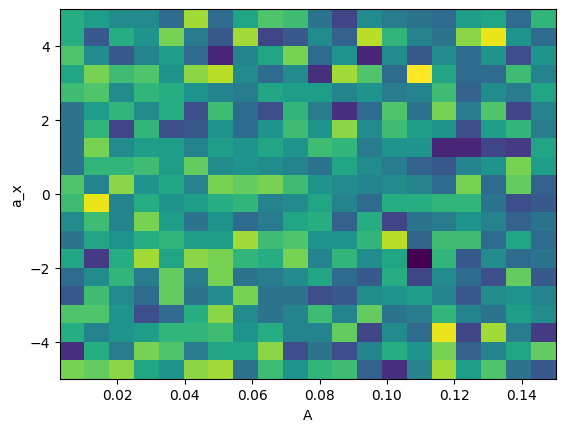

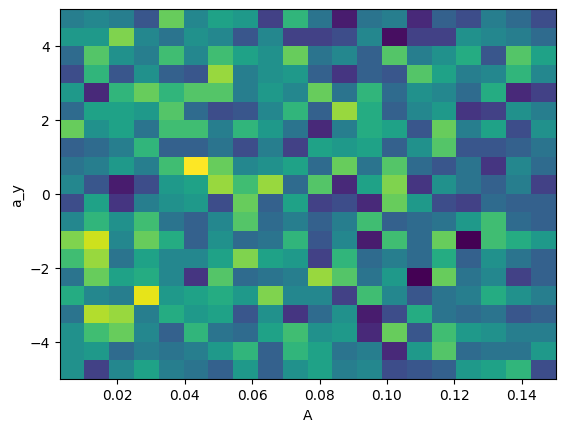

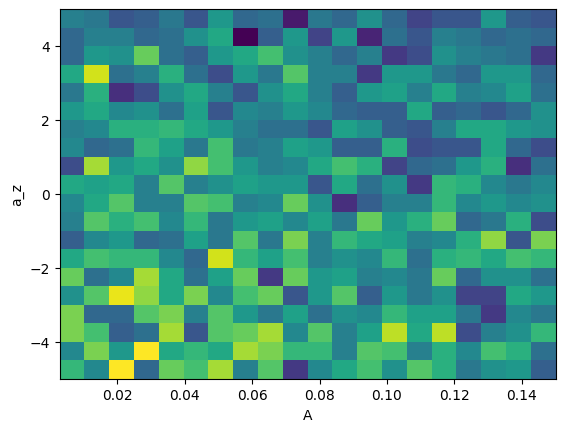

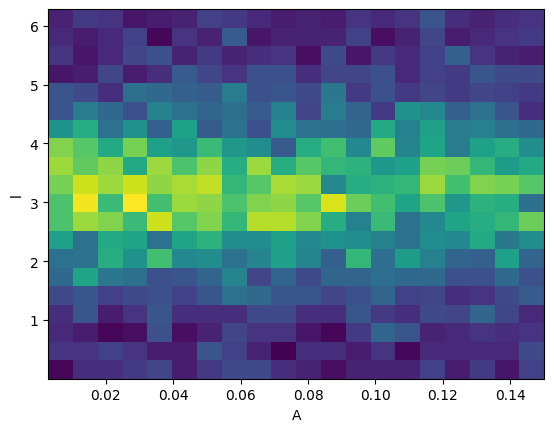

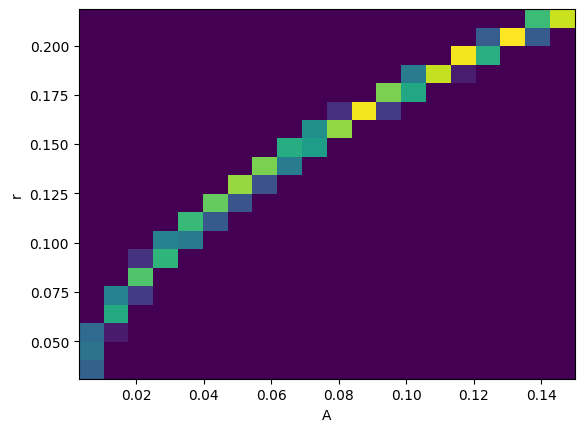

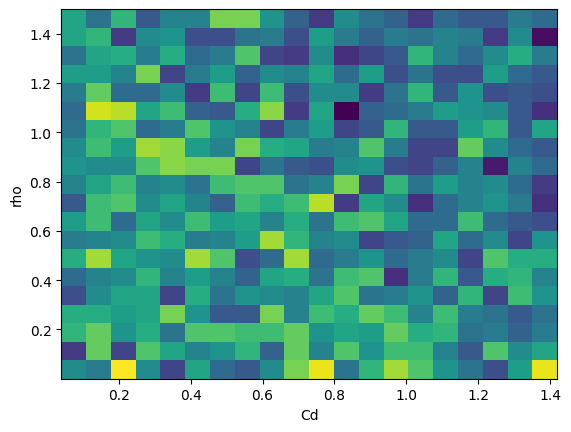

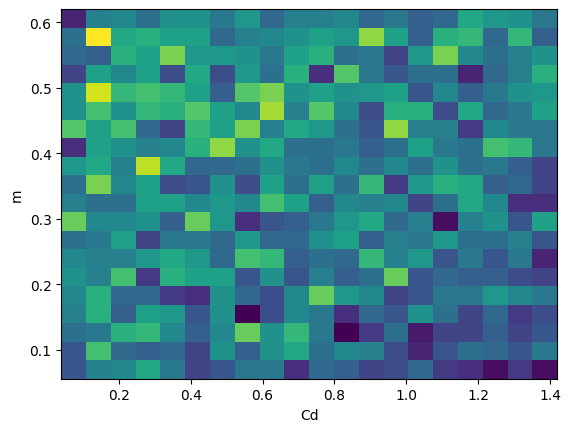

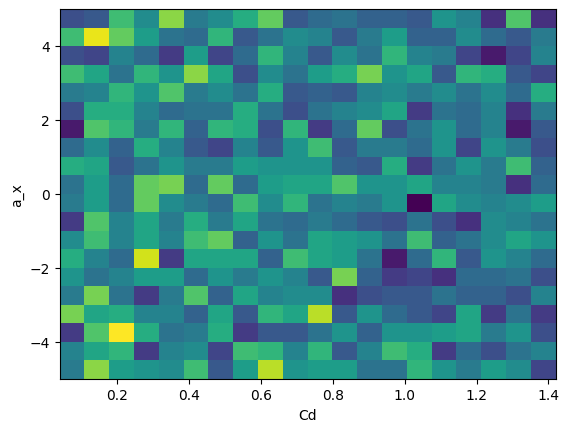

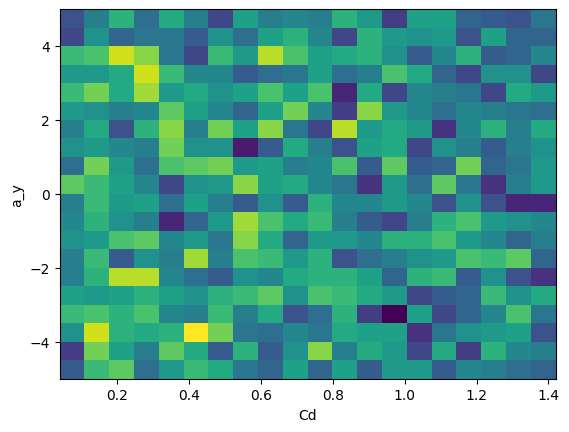

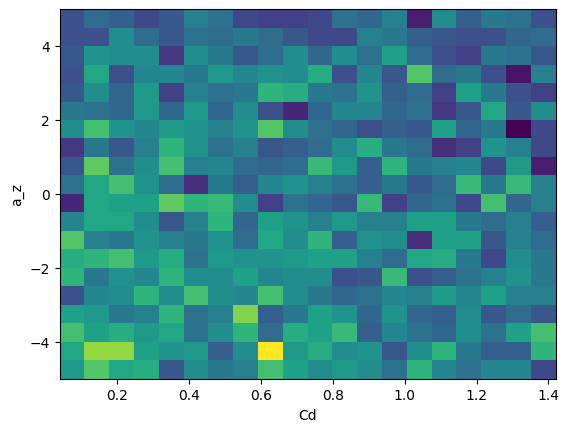

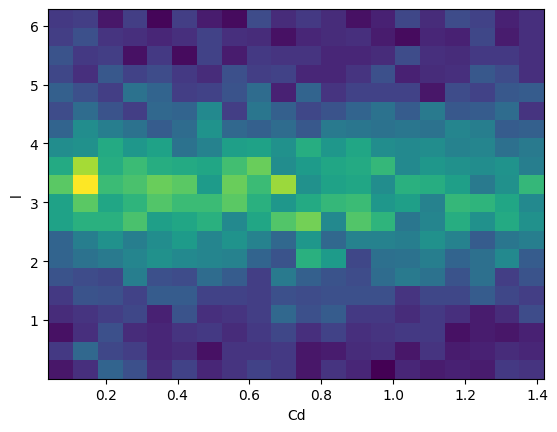

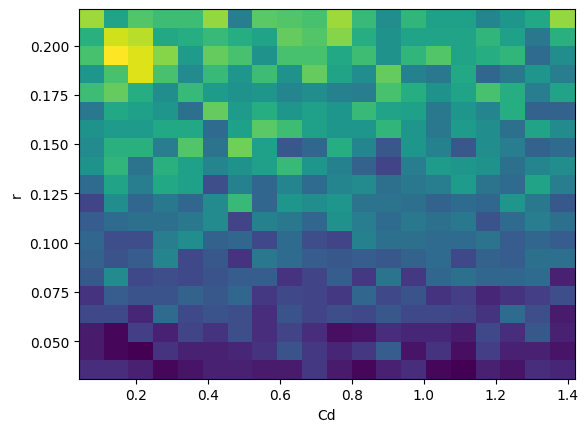

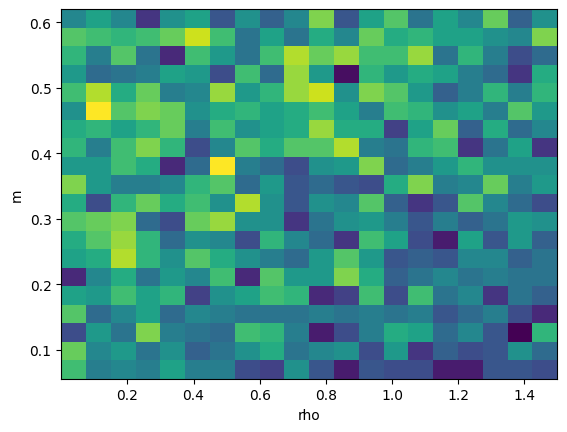

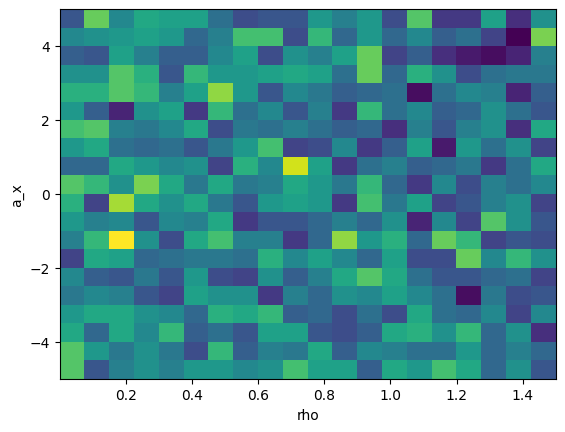

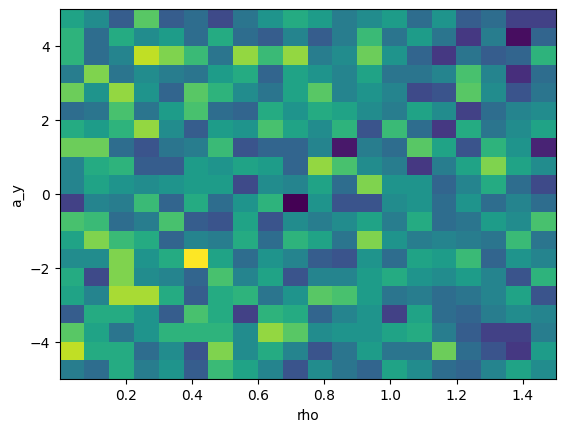

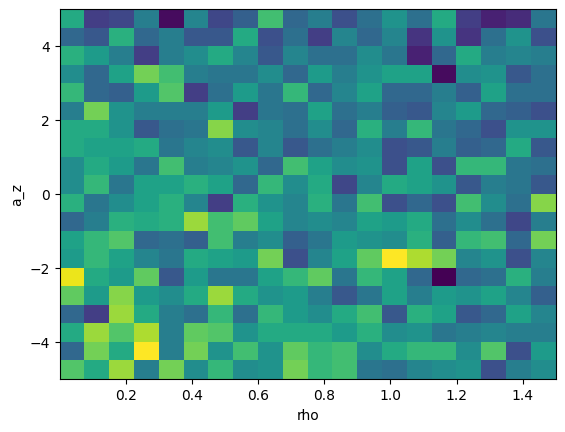

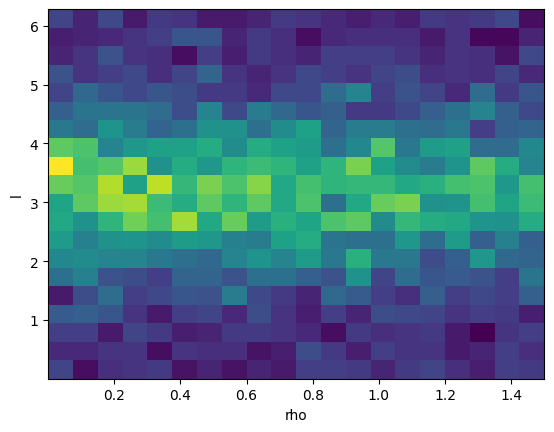

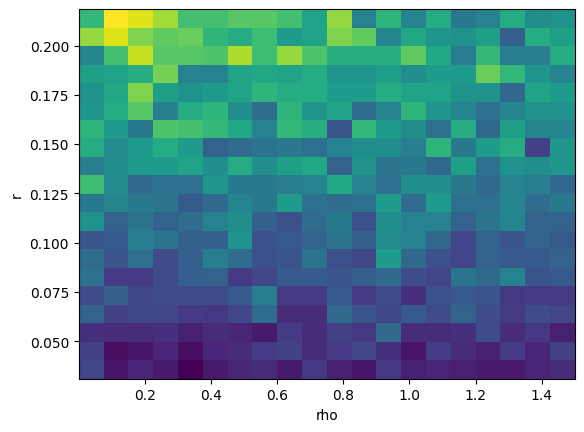

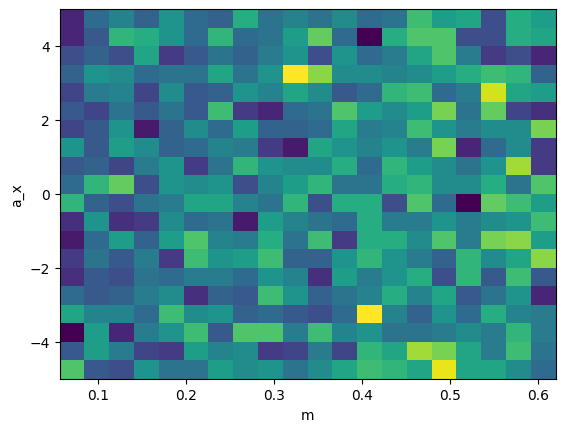

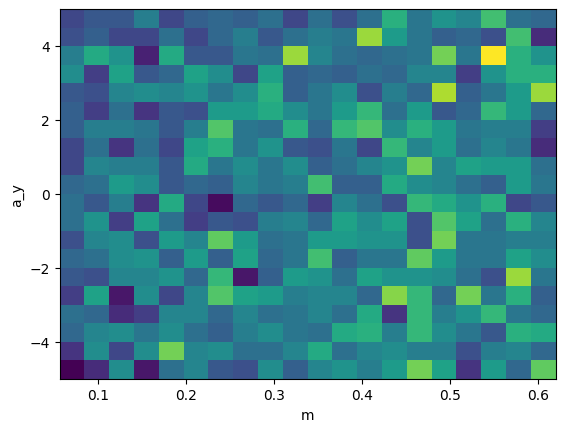

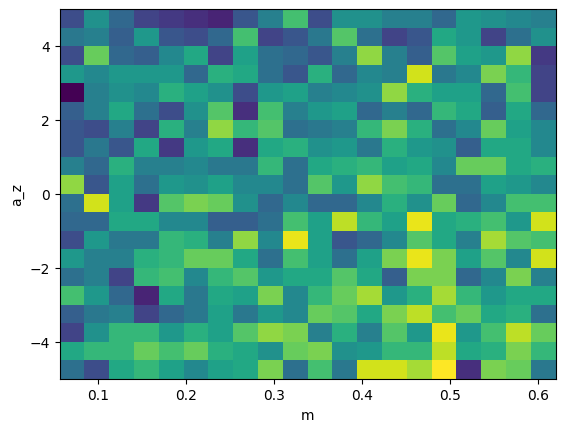

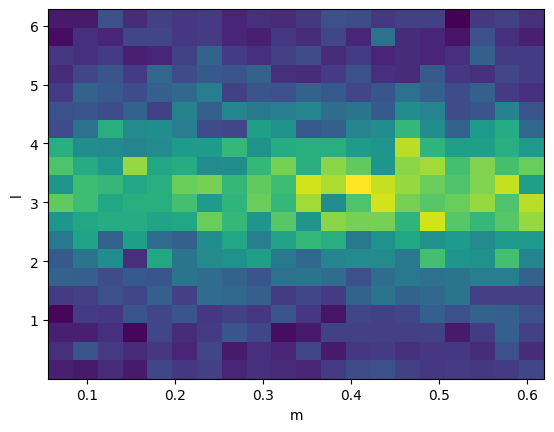

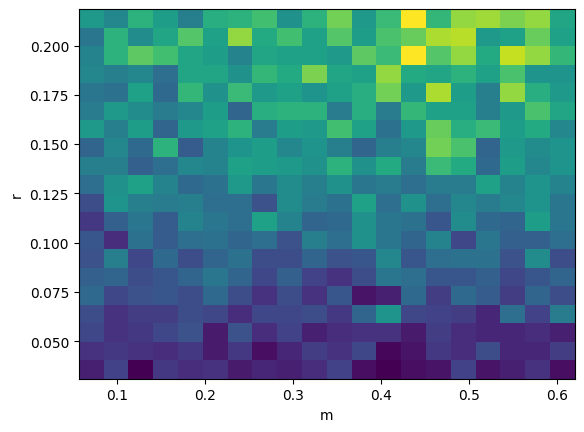

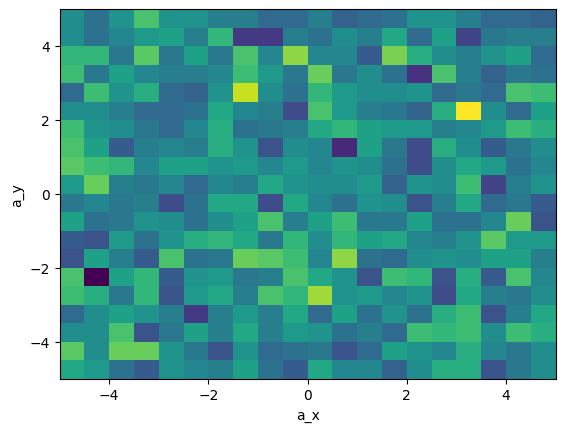

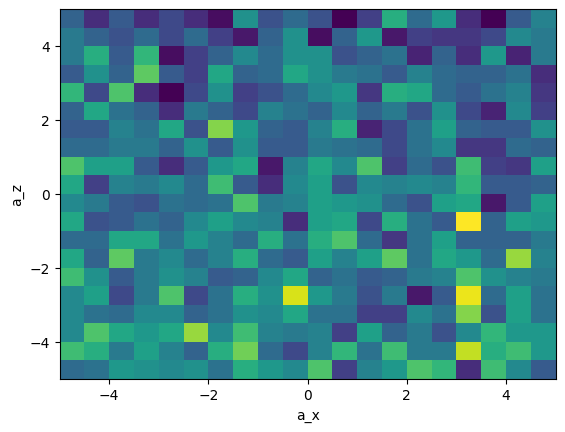

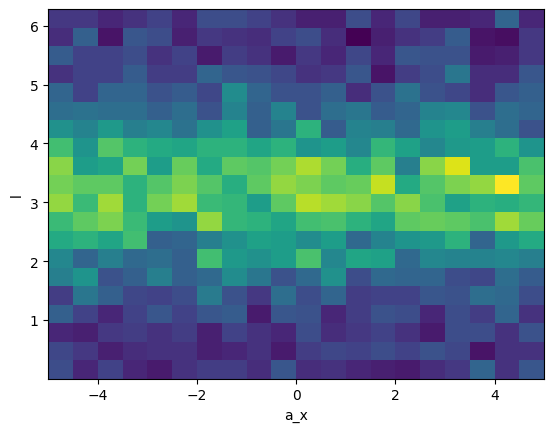

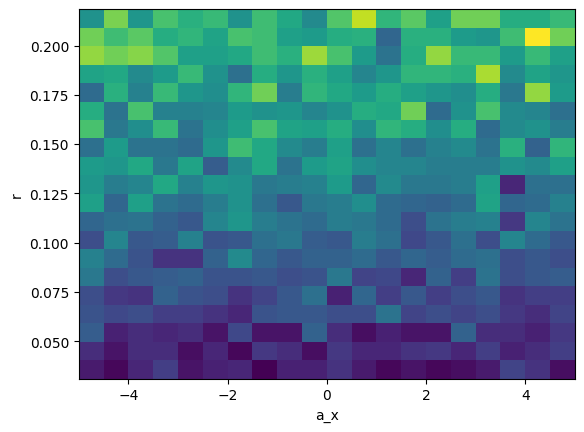

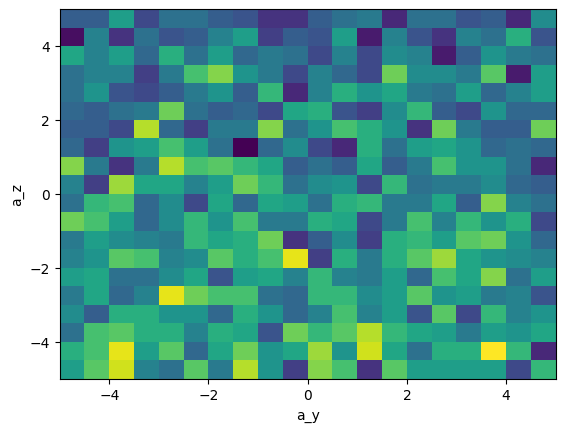

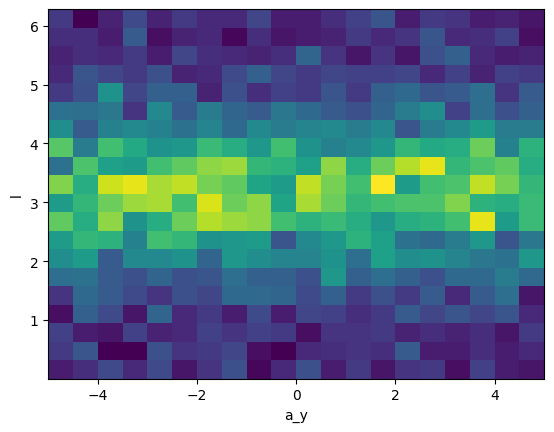

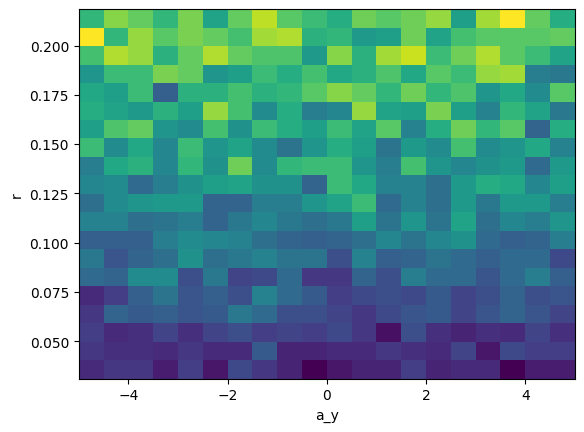

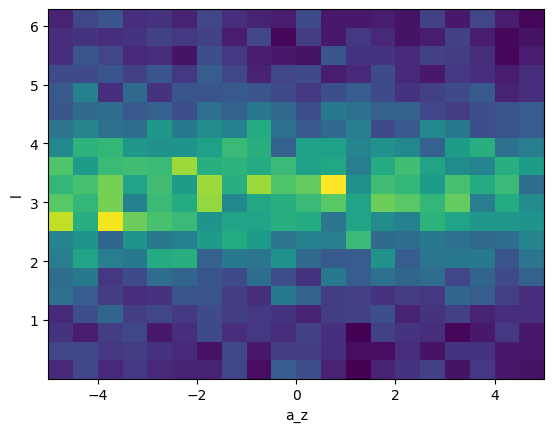

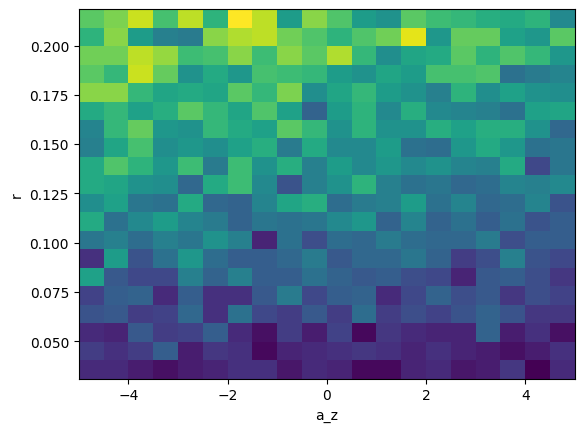

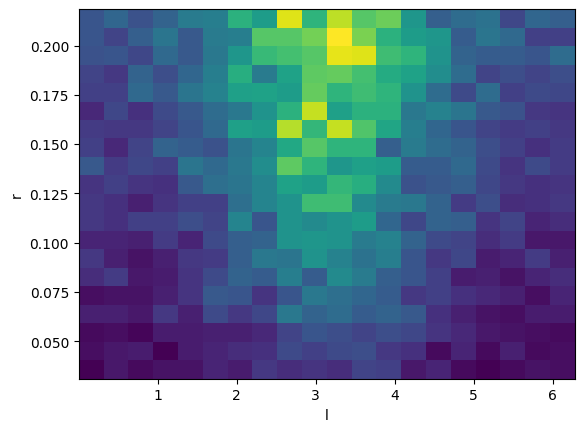

In [8]:
# plot 2d hist of all pairs
for i in range(df.shape[1]):
    for j in range(i + 1, df.shape[1]):
        plt.hist2d(df.iloc[:, i], df.iloc[:, j], bins=20)
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.show()

In [9]:
# save df
df.to_csv('ballistic_parameters.csv', index=False)